In [1]:
import torch
import torch.nn as nn
import random
import torch.nn.functional as func
import time
import numpy as np
torch.pi = torch.acos(torch.zeros(1)).item() * 2  # which is 3.1415927410125732
import matplotlib.pyplot as plt
from datetime import datetime
from torch import autograd
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Aid libraries and function for the extraction of IEEE-118 admitance matrix
!pip install PYPOWER
# !apt install PYPOWER
from pypower.api import case118, makeYbus, case14
from pypower.idx_brch import F_BUS, T_BUS
import numpy as np

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.0/347.0 kB 6.1 MB/s eta 0:00:00


# KalmanFilter #

In [2]:
class KalmanFilter:

    def __init__(self, SystemModel):
        self.F = SystemModel.F;
        self.F_T = torch.transpose(self.F, 0, 1);
        self.m = SystemModel.m

        self.Q = SystemModel.Q;

        self.H = SystemModel.H;
        self.H_T = torch.transpose(self.H, 0, 1);
        self.n = SystemModel.n

        self.R = SystemModel.R;

        self.T = SystemModel.T;
        self.T_test = SystemModel.T_test;

    # Predict

    def Predict(self):
        # Predict the 1-st moment of x
        self.m1x_prior = torch.matmul(self.F, self.m1x_posterior);

        # Predict the 2-nd moment of x
        self.m2x_prior = torch.matmul(self.F, self.m2x_posterior);
        self.m2x_prior = torch.matmul(self.m2x_prior, self.F_T) + self.Q;

        # Predict the 1-st moment of y
        self.m1y = torch.matmul(self.H, self.m1x_prior);

        # Predict the 2-nd moment of y
        self.m2y = torch.matmul(self.H, self.m2x_prior);
        self.m2y = torch.matmul(self.m2y, self.H_T) + self.R;

    # Compute the Kalman Gain
    def KGain(self):
        self.KG = torch.matmul(self.m2x_prior, self.H_T)
        self.KG = torch.matmul(self.KG, torch.inverse(self.m2y))

    # Innovation
    def Innovation(self, y):
        self.dy = y - self.m1y;

    # Compute Posterior
    def Correct(self):
        # Compute the 1-st posterior moment
        self.m1x_posterior = self.m1x_prior + torch.matmul(self.KG, self.dy);

        # Compute the 2-nd posterior moment
        self.m2x_posterior = torch.matmul(self.m2y, torch.transpose(self.KG, 0, 1))
        self.m2x_posterior = self.m2x_prior - torch.matmul(self.KG, self.m2x_posterior)

    def Update(self, y):
        self.Predict();
        self.KGain();
        self.Innovation(y);
        self.Correct();

        return self.m1x_posterior,self.m2x_posterior;

    def InitSequence(self, m1x_0, m2x_0):
        self.m1x_0 = m1x_0
        self.m2x_0 = m2x_0

        #########################

    ### Generate Sequence ###
    #########################
    def GenerateSequence(self, y, T):
        # Pre allocate an array for predicted state and variance
        self.x = torch.empty(size=[self.m, T])
        self.sigma = torch.empty(size=[self.m, self.m, T])

        self.m1x_posterior = self.m1x_0
        self.m2x_posterior = self.m2x_0

        for t in range(0, T):
            yt = torch.unsqueeze(y[:, t], 1);
            xt,sigmat = self.Update(yt);
            self.x[:, t] = torch.squeeze(xt)
            self.sigma[:, :, t] = torch.squeeze(sigmat)

# Linear SystemModel #

In [3]:
class SystemModel_lin:

    def __init__(self, F, q, H, r, T, T_test, outlier_p=0,rayleigh_sigma=10000):

        self.outlier_p = outlier_p
        self.rayleigh_sigma = rayleigh_sigma
        ####################
        ### Motion Model ###
        ####################
        self.F = F
        self.m = self.F.size()[0]

        self.q = q
        self.Q = q * q * torch.eye(self.m)

        #########################
        ### Observation Model ###
        #########################
        self.H = H
        self.n = self.H.size()[0]

        self.r = r
        self.R = r * r * torch.eye(self.n)

        #Assign T and T_test
        self.T = T
        self.T_test = T_test

    #####################
    ### Init Sequence ###
    #####################
    def InitSequence(self, m1x_0, m2x_0):

        self.m1x_0 = m1x_0
        self.m2x_0 = m2x_0


    #########################
    ### Update Covariance ###
    #########################
    def UpdateCovariance_Gain(self, q, r):

        self.q = q
        self.Q = q * q * torch.eye(self.m)

        self.r = r
        self.R = r * r * torch.eye(self.n)

    def UpdateCovariance_Matrix(self, Q, R):

        self.Q = Q

        self.R = R


    #########################
    ### Generate Sequence ###
    #########################
    def GenerateSequence(self, Q_gen, R_gen, T):
        # Pre allocate an array for current state
        self.x = torch.empty(size=[self.m, T])
        # Pre allocate an array for current observation
        self.y = torch.empty(size=[self.n, T])
        # Set x0 to be x previous
        self.x_prev = self.m1x_0

        # Outliers
        if self.outlier_p > 0:
            b_matrix = torch.bernoulli(self.outlier_p *torch.ones(T))

        # Generate Sequence Iteratively
        for t in range(0, T):
            ########################
            #### State Evolution ###
            ########################
            # Process Noise
            if self.q == 0:
                xt = self.F.matmul(self.x_prev)
            else:
                xt = self.F.matmul(self.x_prev)
                mean = torch.zeros([self.m])
                distrib = MultivariateNormal(loc=mean, covariance_matrix=Q_gen)
                eq = distrib.rsample()
                # eq = torch.normal(mean, self.q)
                eq = torch.reshape(eq[:],[self.m,1])
                # Additive Process Noise
                xt = torch.add(xt,eq)

            ################
            ### Emission ###
            ################
            # Observation Noise
            if self.r == 0:
                yt = self.H.matmul(xt)
            else:
                yt = self.H.matmul(xt)
                mean = torch.zeros([self.n])
                distrib = MultivariateNormal(loc=mean, covariance_matrix=R_gen)
                er = distrib.rsample()
                er = torch.reshape(er[:],[self.n,1])
                # mean = torch.zeros([self.n,1])
                # er = torch.normal(mean, self.r)

                # Additive Observation Noise
                yt = torch.add(yt,er)

            # Outliers
            if self.outlier_p > 0:
                if b_matrix[t] != 0:
                    btdt = self.rayleigh_sigma*torch.sqrt(-2*torch.log(torch.rand(self.n,1)))
                    yt = torch.add(yt,btdt)




            ########################
            ### Squeeze to Array ###
            ########################

            # Save Current State to Trajectory Array
            self.x[:, t] = torch.squeeze(xt)

            # Save Current Observation to Trajectory Array
            self.y[:, t] = torch.squeeze(yt)

            ################################
            ### Save Current to Previous ###
            ################################
            self.x_prev = xt

    ######################
    ### Generate Batch ###
    ######################

    def GenerateBatch(self, size, T, randomInit=False, seqInit=False, T_test=0):

        # Allocate Empty Array for Input
        self.Input = torch.empty(size, self.n, T)

        # Allocate Empty Array for Target
        self.Target = torch.empty(size, self.m, T)

        ### Generate Examples
        initConditions = self.m1x_0

        for i in range(0, size):
            # Generate Sequence

            # Randomize initial conditions to get a rich dataset
            if(randomInit):
                variance = 100
                initConditions = torch.rand_like(self.m1x_0) * variance
            if(seqInit):
                initConditions = self.x_prev
                if((i*T % T_test)==0):
                    initConditions = torch.zeros_like(self.m1x_0)

            self.InitSequence(initConditions, self.m2x_0)
            self.GenerateSequence(self.Q, self.R, T)

            # Training sequence input
            self.Input[i, :, :] = self.y

            # Training sequence output
            self.Target[i, :, :] = self.x

# KFTest #


In [4]:

def KFTest(SysModel, test_input, test_target):
    N_T = test_target.size()[0]
    print("N_T = ", N_T)

    # LOSS
    loss_fn = nn.MSELoss(reduction='mean')

    # MSE [Linear]
    MSE_KF_linear_arr = torch.empty(N_T)
    MSE_per_iter = torch.zeros(SysModel.T)
    MSE_finalize = torch.zeros(SysModel.T)

    start = time.time()
    KF = KalmanFilter(SysModel)
    KF.InitSequence(SysModel.m1x_0, SysModel.m2x_0)

    for j in range(0, N_T):
        KF.GenerateSequence(test_input[j, :, :], KF.T_test)
        for t in range(SysModel.T):
          MSE_per_iter[t] = loss_fn(KF.x[:,t], test_target[j, :, t])
        MSE_KF_linear_arr[j] = loss_fn(KF.x, test_target[j, :, :]).item()
        #MSE_KF_linear_arr[j] = loss_fn(test_input[j, :, :], test_target[j, :, :]).item()
        MSE_finalize += MSE_per_iter
    end = time.time()
    t = end - start

    MSE_KF_linear_avg = torch.mean(MSE_KF_linear_arr)
    MSE_KF_dB_avg = 10 * torch.log10(MSE_KF_linear_avg)

    # Standard deviation
    MSE_KF_dB_std = torch.std(MSE_KF_linear_arr, unbiased=True)
    MSE_KF_dB_std = 10 * torch.log10(MSE_KF_dB_std)

    MSE_finalize = MSE_finalize / N_T # average
    MSE_finalize_dB = 10 * torch.log10(MSE_finalize)

    print("Kalman Filter - MSE LOSS:", MSE_KF_dB_avg, "[dB]")
    print("EKF - MSE STD:", MSE_KF_dB_std, "[dB]")
    # Print Run Time
    print("Inference Time:", t)

    return [MSE_finalize_dB, MSE_KF_linear_arr, MSE_KF_linear_avg, MSE_KF_dB_avg]

# Extended Sysmodel #


In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal

# from filing_paths import path_model
# import sys

# sys.path.insert(1, path_model)
# from parameters import delta_t, delta_t_gen, variance


class SystemModel:

    def __init__(self, f, q, h, r, T, T_test, m, n, L, V, V_t, modelname='lor'):

        ####################
        ### Motion Model ###
        ####################
        self.L = L
        self.V = V
        self.V_t = V_t
        self.modelname = modelname

        self.f = f
        self.m = m
        print("m,n = ",m,n)
        self.q = q
        self.Q = q * q * torch.eye(self.m)

        #########################
        ### Observation Model ###
        #########################
        self.h = h
        self.n = n

        self.r = r
        self.R = r * r * torch.eye(self.n)

        # Assign T and T_test
        self.T = T
        self.T_test = T_test

    #####################
    ### Init Sequence ###
    #####################
    def InitSequence(self, m1x_0, m2x_0):

        self.m1x_0 = torch.squeeze(m1x_0)
        self.m2x_0 = torch.squeeze(m2x_0)

    #########################
    ### Update Covariance ###
    #########################
    def UpdateCovariance_Gain(self, q, r):

        self.q = q
        self.Q = q * q * torch.eye(self.m)

        self.r = r
        self.R = r * r * torch.eye(self.n)

    def UpdateCovariance_Matrix(self, Q, R):

        self.Q = Q

        self.R = R

    #########################
    ### Generate Sequence ###
    #########################
    def GenerateSequence(self, Q_gen, R_gen, T):
        # Pre allocate an array for current state
        self.x = torch.empty(size=[self.m, T])
        # Pre allocate an array for current observation
        self.y = torch.empty(size=[self.n, T])
        # Set x0 to be x previous
        self.x_prev = self.m1x_0

        # Generate Sequence Iteratively
        for t in range(0, T):
            ########################
            #### State Evolution ###
            ########################
            # Process Noise
            if self.q == 0:
                xt = self.f(self.x_prev)
            else:
                xt = self.f(self.x_prev)
                mean = torch.zeros([self.m])
                if self.modelname == "pendulum":
                    distrib = MultivariateNormal(loc=mean, covariance_matrix=Q_gen)
                    eq = distrib.rsample()
                else:
                    eq = torch.normal(mean, self.q)

                # Additive Process Noise
                xt = torch.add(xt, eq)

            ################
            ### Emission ###
            ################
            yt = self.h(xt)

            # Observation Noise
            mean = torch.zeros([self.n])
            er = torch.normal(mean, self.r)
            # er = np.random.multivariate_normal(mean, R_gen, 1)
            # er = torch.transpose(torch.tensor(er), 0, 1)

            # Additive Observation Noise
            yt = torch.add(yt, er)

            ########################
            ### Squeeze to Array ###
            ########################

            # Save Current State to Trajectory Array
            self.x[:, t] = torch.squeeze(xt)

            # Save Current Observation to Trajectory Array
            self.y[:, t] = torch.squeeze(yt)

            ################################
            ### Save Current to Previous ###
            ################################
            self.x_prev = xt

    ######################
    ### Generate Batch ###
    ######################
    def GenerateBatch(self, size, T, randomInit=False):

        # Allocate Empty Array for Input
        self.Input = torch.empty(size, self.n, T)

        # Allocate Empty Array for Target
        self.Target = torch.empty(size, self.m, T)

        initConditions = self.m1x_0

        ### Generate Examples
        for i in range(0, size):
            # Generate Sequence
            # Randomize initial conditions to get a rich dataset
            if (randomInit):
                initConditions = torch.rand_like(self.m1x_0) * variance
            self.InitSequence(initConditions, self.m2x_0)
            self.GenerateSequence(self.Q, self.R, T)

            # Training sequence input
            self.Input[i, :, :] = self.y

            # Training sequence output
            self.Target[i, :, :] = self.x


# GSP-KalmanNet #


In [6]:
class GSPKalmanNetNN(torch.nn.Module):

    ###################
    ### Constructor ###
    ###################
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    #############
    ### Build ###
    #############
    def Build(self, ssModel):
        self.V = ssModel.V
        self.V_t = ssModel.V_t
        self.InitSystemDynamics(ssModel.F, ssModel.H)
        # Number of neurons in the 1st hidden layer
        H1_KNet = (ssModel.m + ssModel.n) * 10 * 8     # Here we can reduce the latent space

        # Number of neurons in the 2nd hidden layer
        H2_KNet = (ssModel.m * ssModel.n) * 1 * (4)      # Here we can reduce the latent space

        self.InitKGainNet(H1_KNet, H2_KNet)

    ######################################
    ### Initialize Kalman Gain Network ###
    ######################################
    def InitKGainNet(self, H1, H2):
        # Input Dimensions
        D_in = self.m + self.n  # x(t-1), y(t)

        # Output Dimensions
        D_out = self.n  # Diagonal Kalman Gain ## GSP update 8.3

        ###################
        ### Input Layer ###
        ###################
        # Linear Layer
        self.KG_l1 = torch.nn.Linear(D_in, H1, bias=True)

        # ReLU (Rectified Linear Unit) Activation Function
        self.KG_relu1 = torch.nn.ReLU()

        ###########
        ### GRU ###
        ###########
        # Input Dimension
        self.input_dim = H1
        # Hidden Dimension
        self.hidden_dim = (self.m * self.m + self.n * self.n) * 10
        # Number of Layers
        self.n_layers = 1
        # Batch Size
        self.batch_size = 1
        # Input Sequence Length
        self.seq_len_input = 1
        # Hidden Sequence Length
        self.seq_len_hidden = self.n_layers

        # batch_first = False
        # dropout = 0.1 ;

        # Initialize a Tensor for GRU Input
        # self.GRU_in = torch.empty(self.seq_len_input, self.batch_size, self.input_dim)

        # Initialize a Tensor for Hidden State
        self.hn = torch.randn(self.seq_len_hidden, self.batch_size, self.hidden_dim).to(self.device,non_blocking = True)

        # Iniatialize GRU Layer
        self.rnn_GRU = nn.GRU(self.input_dim, self.hidden_dim, self.n_layers)

        ####################
        ### Hidden Layer ###
        ####################
        self.KG_l2 = torch.nn.Linear(self.hidden_dim, H2, bias=True)

        # ReLU (Rectified Linear Unit) Activation Function
        self.KG_relu2 = torch.nn.ReLU()

        ####################
        ### Output Layer ###
        ####################
        self.KG_l3 = torch.nn.Linear(H2, D_out, bias=True)

    ##################################
    ### Initialize System Dynamics ###
    ##################################
    def InitSystemDynamics(self, F, H):
        # Set State Evolution Matrix
        self.F = self.GFT_matrix(F.to(self.device,non_blocking = True))
        self.F_T = torch.transpose(F, 0, 1)
        self.m = self.F.size()[0]

        # Set Observation Matrix
        self.H = self.GFT_matrix(H.to(self.device,non_blocking = True))
        self.H_T = torch.transpose(H, 0, 1)
        self.n = self.H.size()[0]

    ###########################
    ### Initialize Sequence ###
    ###########################
    # def InitSequence(self, M1_0):
    #     M1_0 = self.GFT(M1_0)
    #     self.m1x_prior = M1_0.to(self.device,non_blocking = True)

    #     self.m1x_posterior = M1_0.to(self.device,non_blocking = True)

    #     self.state_process_posterior_0 = M1_0.to(self.device,non_blocking = True)

    def InitSequence(self, M1_0, T):
        M1_0 = self.GFT(M1_0.squeeze())

        self.m1x_posterior = torch.squeeze(M1_0).to(dev)
        self.m1x_posterior_previous = 0  # for t=0

        self.T = T
        self.x_out = torch.empty(self.m, T)

        self.m1x_prior = M1_0.to(self.device,non_blocking = True)
        self.state_process_posterior_0 = torch.squeeze(M1_0).to(dev)
        self.m1x_prior_previous = self.m1x_posterior

        # KGain saving
        self.i = 0
        self.KGain_array = self.KG_array = torch.zeros((self.T*10, self.m, self.n)).to(dev)

    ######################
    ### Compute Priors ###
    ######################
    def step_prior(self):
        # Compute the 1-st moment of x based on model knowledge and without process noise
        bmm_mul = torch.bmm(self.F.expand(self.state_process_posterior_0.size()[0], -1, -1).type(torch.DoubleTensor).to(dev), self.state_process_posterior_0.unsqueeze(-1).type(torch.DoubleTensor).to(dev)).squeeze(-1)
        self.state_process_prior_0 = bmm_mul

        # Compute the 1-st moment of y based on model knowledge and without noise
        bmm_mul = torch.bmm(self.H.expand(self.state_process_prior_0.size()[0], -1, -1).type(torch.DoubleTensor).to(dev), self.state_process_prior_0.unsqueeze(-1).type(torch.DoubleTensor).to(dev)).squeeze(-1)
        self.obs_process_0 = bmm_mul

        # Predict the 1-st moment of x
        self.m1x_prev_prior = self.m1x_prior.squeeze()
        bmm_mul = torch.bmm(self.F.expand(self.m1x_posterior.size()[0], -1, -1).type(torch.DoubleTensor).to(dev), self.m1x_posterior.unsqueeze(-1).type(torch.DoubleTensor).to(dev)).squeeze(-1)
        self.m1x_prior = bmm_mul

        # Predict the 1-st moment of y
        bmm_mul = torch.bmm(self.H.expand(self.m1x_prior.size()[0], -1, -1).type(torch.DoubleTensor).to(dev), self.m1x_prior.unsqueeze(-1).type(torch.DoubleTensor).to(dev)).squeeze(-1)
        self.m1y = bmm_mul


    ##############################
    ### Kalman Gain Estimation ###
    ##############################
    def step_KGain_est(self, y):

      # Reshape and Normalize the difference in X prior
      # Featture 4: x_t|t - x_t|t-1
      #dm1x = self.m1x_prior - self.state_process_prior_0
      dm1x = self.m1x_posterior - self.m1x_prev_prior
      dm1x_reshape = torch.squeeze(dm1x)
      dm1x_norm = func.normalize(dm1x_reshape, p=2, dim=0, eps=1e-12, out=None)

      # Feature 2: yt - y_t+1|t
      dm1y = y.squeeze() - torch.squeeze(self.m1y)
      dm1y_norm = func.normalize(dm1y, p=2, dim=0, eps=1e-12, out=None)

      # KGain Net Input
      KGainNet_in = torch.cat([dm1y_norm, dm1x_norm], dim=1)
      # Kalman Gain Network Step
      KG = self.KGain_step(KGainNet_in)
      # Reshape Kalman Gain to a Matrix
      KG = torch.diag_embed(KG)
      self.KGain = torch.reshape(KG, (-1,self.m, self.n))

    #######################
    ### Kalman Net Step ###
    #######################
    def KNet_step(self, y):
        # Compute Priors
        self.step_prior()

        # Compute Kalman Gain
        self.step_KGain_est(y)

        # Innovation
        y_obs = torch.squeeze(y)
        dy = y_obs - self.m1y
        # Compute the 1-st posterior moment
        # bmm_mul = torch.bmm(self.F.expand(self.state_process_posterior_0.size()[0], -1, -1).type(torch.DoubleTensor).to(dev), self.state_process_posterior_0.unsqueeze(-1).type(torch.DoubleTensor).to(dev)).squeeze(-1)
        INOV = torch.matmul(self.KGain.float(), dy.unsqueeze(-1).float()).squeeze()
        self.m1x_posterior = self.m1x_prior + INOV

        # return
        return torch.squeeze(self.m1x_posterior)

    ########################
    ### Kalman Gain Step ###
    ########################
    def KGain_step(self, KGainNet_in):

        ###################
        ### Input Layer ###
        ###################
        L1_out = self.KG_l1(KGainNet_in.type(torch.FloatTensor).to(dev))
        La1_out = self.KG_relu1(L1_out)

        ###########
        ### GRU ###
        ###########
        GRU_in = torch.empty(self.seq_len_input, self.batch_size, self.input_dim).to(self.device,non_blocking = True)
        GRU_in[0, :, :] = La1_out
        GRU_out, self.hn = self.rnn_GRU(GRU_in, self.hn)
        # GRU_out_reshape = torch.reshape(GRU_out, (1, self.hidden_dim))

        ####################
        ### Hidden Layer ###
        ####################
        L2_out = self.KG_l2(GRU_out)
        La2_out = self.KG_relu2(L2_out)

        ####################
        ### Output Layer ###
        ####################
        L3_out = self.KG_l3(La2_out)
        return L3_out

    ###############
    ### Forward ###
    ###############
    def forward(self, yt):
        yt = self.GFT(yt.squeeze())
        yt = yt.to(self.device,non_blocking = True)
        return self.IGFT(self.KNet_step(yt))

    #########################
    ### Init Hidden State ###
    #########################
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_()
        self.hn = hidden.data

    def GFT(self, input):
        # return torch.matmul(self.V_t, input.to(dev)).type(torch.FloatTensor)
        return self.BMM_multipy(self.V_t,input.to(dev)).type(torch.FloatTensor)

    def IGFT(self, input):
        # return torch.matmul(self.V, input.to(dev)).type(torch.FloatTensor)
        return self.BMM_multipy(self.V,input.to(dev)).type(torch.FloatTensor)

    def GFT_matrix(self, input):
        return torch.matmul(torch.matmul(self.V_t, input.to(dev)), self.V).type(torch.FloatTensor)
        # return self.BMM_multipy(self.V_t,input.to(dev)).type(torch.FloatTensor)

    def IGFT_matrix(self, input):
        return torch.matmul(torch.matmul(self.V, input.to(dev)), self.V).type(torch.FloatTensor)

    def BMM_multipy(self,a,b):
        try:
          return torch.bmm(a.expand(b.size()[0], -1, -1).type(torch.DoubleTensor).to(dev), b.unsqueeze(-1).type(torch.DoubleTensor).to(dev)).squeeze(-1)
        except:
          print(a.shape,b.shape)


# **Ex Kalmannet**

In [7]:

nGRU = 2
class ExtendedKalmanNetNN(torch.nn.Module):

    ###################
    ### Constructor ###
    ###################
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    ######################################
    ### Initialize Kalman Gain Network ###
    ######################################

    def Build(self, ssModel, infoString='fullInfo'):

        self.InitSystemDynamics(ssModel.f, ssModel.h, ssModel.m, ssModel.n, infoString='fullInfo')
        self.InitSequence(ssModel.m1x_0, ssModel.T)

        # Number of neurons in the 1st hidden layer
        # H1_KNet = (ssModel.m + ssModel.n) * (10) * 8
        H1_KNet = (ssModel.m + ssModel.n) * 8
        # Number of neurons in the 2nd hidden layer
        H2_KNet = (ssModel.m * ssModel.n)  * 1 * 2

        self.InitKGainNet(H1_KNet, H2_KNet)

    def InitKGainNet(self, H1, H2):
        # Input Dimensions (+1 for time input)
        D_in = self.m + self.m + self.n  # F1,3,4
        # Output Dimensions
        D_out = self.m * self.n  # Kalman Gain

        ###################
        ### Input Layer ###
        ###################
        # Linear Layer
        self.KG_l1 = torch.nn.Linear(D_in, H1, bias=True) #.type(torch.DoubleTensor)
        # ReLU (Rectified Linear Unit) Activation Function
        self.KG_relu1 = torch.nn.ReLU()
        ###########
        ### GRU ###
        ###########

        # Input Dimension
        self.input_dim = H1
        # Hidden Dimension
        self.hidden_dim = ((self.n * self.n) + (self.m * self.m)) * 8
        # Number of Layers
        self.n_layers = nGRU
        # Batch Size
        self.batch_size = 1
        # Input Sequence Length
        self.seq_len_input = 1
        # Hidden Sequence Length
        self.seq_len_hidden = self.n_layers

        # batch_first = False
        # dropout = 0.1 ;

        # Initialize a Tensor for GRU Input
        # self.GRU_in = torch.empty(self.seq_len_input, self.batch_size, self.input_dim)

        # Initialize a Tensor for Hidden State
        self.hn = torch.randn(self.seq_len_hidden, self.batch_size, self.hidden_dim)

        # Iniatialize GRU Layer
        self.rnn_GRU = nn.GRU(self.input_dim, self.hidden_dim, self.n_layers, dropout=0)

        ####################
        ### Hidden Layer ###
        ####################
        self.KG_l2 = torch.nn.Linear(self.hidden_dim, H2, bias=True)

        # ReLU (Rectified Linear Unit) Activation Function
        self.KG_relu2 = torch.nn.ReLU()

        ####################
        ### Output Layer ###
        ####################
        self.KG_l3 = torch.nn.Linear(H2, D_out, bias=True)
    ##################################
    ### Initialize System Dynamics ###
    ##################################
    def InitSystemDynamics(self, f, h, m, n, infoString='fullInfo'):

        if (infoString == 'partialInfo'):
            self.fString = 'ModInacc'
            self.hString = 'ObsInacc'
        else:
            self.fString = 'ModAcc'
            self.hString = 'ObsAcc'

        # Set State Evolution Function
        self.f = f
        self.m = m

        # Set Observation Function
        self.h = h
        self.n = n

    ###########################
    ### Initialize Sequence ###
    ###########################
    def InitSequence(self, M1_0, T):

        self.m1x_posterior = torch.squeeze(M1_0).to(dev)
        self.m1x_posterior_previous = 0  # for t=0

        self.T = T
        self.x_out = torch.empty(self.m, T)

        self.state_process_posterior_0 = torch.squeeze(M1_0).to(dev)
        self.m1x_prior_previous = self.m1x_posterior

        # KGain saving
        self.i = 0
        self.KGain_array = self.KG_array = torch.zeros((self.T*1000, self.m, self.n)).to(dev)

    ######################
    ### Compute Priors ###
    ######################
    def step_prior(self):
        # Predict the 1-st moment of x
        self.m1x_prior = torch.squeeze(self.f(self.m1x_posterior))

        # Predict the 1-st moment of y
        self.m1y = self.h(self.m1x_prior)

        # Update Jacobians
        # self.JFt = get_Jacobian(self.m1x_posterior, self.fString)
        # self.JHt = get_Jacobian(self.m1x_prior, self.hString)

        self.state_process_prior_0 = torch.squeeze(self.f(self.state_process_posterior_0))
        self.obs_process_0 = torch.unsqueeze(self.h(self.state_process_prior_0),-1)

    ##############################
    ### Kalman Gain Estimation ###
    ##############################
    def step_KGain_est(self, y):
        # Feature 1: yt - yt-1
        try:
            my_f1_0 = y - torch.squeeze(self.y_previous.to(dev)).to(dev)
        except:
            # print(torch.squeeze(self.obs_process_0).shape)
            my_f1_0 = y - self.obs_process_0.to(dev).to(dev)  # when t=0
        # my_f1_reshape = torch.squeeze(my_f1_0)
        y_f1_norm = func.normalize(my_f1_0, p=2, dim=0, eps=1e-12, out=None)

        # Feature 2: yt - y_t+1|t
        # my_f2_0 = y - torch.squeeze(self.m1y)
        # my_f2_reshape = torch.squeeze(my_f2_0)
        # y_f2_norm = func.normalize(my_f2_reshape, p=2, dim=0, eps=1e-12, out=None)
        # print("1",self.m1x_posterior)
        # print("2",self.m1x_posterior_previous)
        # print("3",self.m1x_prior_previous)
        # Feature 3: x_t|t - x_t-1|t-1
        self.m1x_posterior = self.m1x_posterior.reshape(-1,14,1)
        # self.m1x_posterior_previous = self.m1x_posterior_previous.reshape(-1,10,1)
        m1x_f3_0 = self.m1x_posterior - self.m1x_posterior_previous
        m1x_f3_reshape = torch.squeeze(m1x_f3_0)
        # m1x_f3_reshape = m1x_f3_0
        m1x_f3_norm = func.normalize(m1x_f3_reshape, p=2, dim=0, eps=1e-12, out=None)
        m1x_f3_norm = m1x_f3_norm.unsqueeze(-1)
        # Reshape and Normalize m1x Posterior
        # m1x_post_0 = self.m1x_posterior - self.state_process_posterior_0 # Option 1

        # Featture 4: x_t|t - x_t|t-1

        m1x_f4_0 = self.m1x_posterior.squeeze() - self.m1x_prior_previous
        # m1x_reshape = torch.squeeze(self.m1x_posterior) # Option 3
        m1x_f4_reshape = torch.squeeze(m1x_f4_0)
        # m1x_f4_reshape = m1x_f4_0
        m1x_f4_norm = func.normalize(m1x_f4_reshape, p=2, dim=0, eps=1e-12, out=None)
        m1x_f4_norm = m1x_f4_norm.unsqueeze(-1)

        # Normalize y
        # my_0 = y - torch.squeeze(self.obs_process_0) # Option 1
        # my_0 = y - torch.squeeze(self.m1y) # Option 2
        # my_0 = y
        # y_norm = func.normalize(my_0, p=2, dim=0, eps=1e-12, out=None)
        # y_norm = func.normalize(y, p=2, dim=0, eps=1e-12, out=None);

        # Input for counting
        count_norm = func.normalize(torch.tensor([self.i]).float(), dim=0, eps=1e-12, out=None)
        # KGain Net Input
        # KGainNet_in = torch.cat([y_f1_norm.to(dev), m1x_f3_norm.to(dev), m1x_f4_norm.to(dev)], dim=0).type(torch.FloatTensor)
        KGainNet_in = torch.cat([y_f1_norm.to(dev), m1x_f3_norm.to(dev), m1x_f4_norm.to(dev)], dim=1).type(torch.FloatTensor)

        # KGainNet_in = torch.cat([y_f1_norm.to(dev), m1x_f3_norm.to(dev)],dim=0).type(torch.FloatTensor) # m1x_f4_norm.to(dev)], dim=0).type(torch.FloatTensor)
        KGainNet_in = KGainNet_in.to(dev)
        # Kalman Gain Network Step
        KG = self.KGain_step(KGainNet_in.to(dev)).to(dev)
        # Reshape Kalman Gain to a Matrix
        self.KGain = torch.reshape(KG, (-1, self.m, self.n)).type(torch.FloatTensor).to(dev)

    #######################
    ### Kalman Net Step ###
    #######################
    def KNet_step(self, y):
        # Compute Priors
        self.step_prior()

        # Compute Kalman Gain
        self.step_KGain_est(y.to(dev))
        # Save KGain in array
        self.KGain_array[self.i:self.i+self.KGain.shape[0]] = self.KGain.to(dev)
        self.i += 1

        # Innovation
        # y_obs = torch.unsqueeze(y, 1)
        dy = torch.squeeze(y).to(dev) - self.m1y.to(dev)

        # Compute the 1-st posterior moment
        INOV = torch.matmul(self.KGain.float().to(dev), dy.unsqueeze(-1).float())
        self.m1x_posterior_previous = self.m1x_posterior.to(dev)
        self.m1x_posterior = self.m1x_prior.unsqueeze(-1).to(dev) +INOV.to(dev)

        self.state_process_posterior_0 = self.state_process_prior_0.to(dev)
        self.m1x_prior_previous = self.m1x_prior.to(dev)
        self.y_previous = y.to(dev)

        # return
        return torch.squeeze(self.m1x_posterior)

    ########################
    ### Kalman Gain Step ###
    ########################
    def KGain_step(self, KGainNet_in):

        def expand_dim(x):
            expanded = torch.empty(self.seq_len_input, self.batch_size, x.shape[-1]).to(self.device)
            expanded[0, :, :] = x
            return expanded

        # obs_diff = expand_dim(obs_diff)
        # obs_innov_diff = expand_dim(obs_innov_diff)
        # fw_evol_diff = expand_dim(fw_evol_diff)
        # fw_update_diff = expand_dim(fw_update_diff)

        ###################
        ### Input Layer ###
        ###################
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.1)
        # Reshape KGainNet_in to match the input shape expected by KG_l1
        KGainNet_in = KGainNet_in.view(KGainNet_in.size(0), -1)
        L1_out = self.KG_l1(KGainNet_in)
        La1_out = self.KG_relu1(L1_out)
        # La1_out = self.dropout1(self.KG_relu1(L1_out))

        ###########
        ### GRU ###
        ###########
        GRU_in = torch.zeros(self.seq_len_input, self.batch_size, self.input_dim)
        GRU_in[0, :, :] = La1_out.to(dev)
        GRU_out, self.hn = self.rnn_GRU(GRU_in.type(torch.FloatTensor).to(dev), self.hn.type(torch.FloatTensor).to(dev))
        # GRU_out_reshape = torch.reshape(GRU_out, (1, self.hidden_dim))

        ####################
        ### Hidden Layer ###
        ####################
        L2_out = self.KG_l2(GRU_out)
        La2_out = self.KG_relu2(L2_out)

        ####################
        ### Output Layer ###
        ####################
        L3_out = self.KG_l3(La2_out)
        return L3_out

    ###############
    ### Forward ###
    ###############
    def forward(self, y):
        # yt = torch.squeeze(y)
        if True in torch.isnan(y):
          print(" ####################### Obsrevations contains nan!!")
        '''
        for t in range(0, self.T):
            self.x_out[:, t] = self.KNet_step(y[:, t])
        '''
        self.x_out = self.KNet_step(y.to(dev))
        return self.x_out

    #########################
    ### Init Hidden State ###
    #########################

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_()
        self.hn = hidden.data

# ***GSP_EXtended Kalmannet***

In [8]:
"""# **Class: KalmanNet**"""
nGRU = 2
class GSPExtendedKalmanNetNN(torch.nn.Module):

    ###################
    ### Constructor ###
    ###################

    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    ######################################
    ### Initialize Kalman Gain Network ###
    ######################################

    def Build(self, ssModel, infoString='fullInfo'):
        self.V = ssModel.V
        self.V_t = ssModel.V_t
        self.InitSystemDynamics(ssModel.f, ssModel.h, ssModel.m, ssModel.n, infoString='fullInfo')

        # Number of neurons in the 1st hidden layer
        H1_KNet = (ssModel.m + ssModel.n) * 8

        # Number of neurons in the 2nd hidden layer
        H2_KNet = (ssModel.n) * 1 * (4)

        self.InitKGainNet(H1_KNet, H2_KNet)

    def InitKGainNet(self, H1, H2):
        # Input Dimensions (+1 for time input)
        D_in = self.m + self.m + self.n  # F1,3,4

        # Output Dimensions
        D_out = self.n  # Diagonal Kalman Gain

        ###################
        ### Input Layer ###
        ###################

        # Linear Layer
        self.KG_l1 = torch.nn.Linear(D_in, H1, bias=True).type(torch.FloatTensor)

        # ReLU (Rectified Linear Unit) Activation Function
        self.KG_relu1 = torch.nn.ReLU()

        ###########
        ### GRU ###
        ###########

        # Input Dimension
        self.input_dim = H1
        # Hidden Dimension
        # self.hidden_dim = ((self.n * self.n) + (self.m * self.m)) * 10 * 1
        self.hidden_dim = ((self.n + self.m)) * 10
        # Number of Layers
        self.n_layers = nGRU
        # Batch Size
        self.batch_size = 1
        # Input Sequence Length
        self.seq_len_input = 1
        # Hidden Sequence Length
        self.seq_len_hidden = self.n_layers

        # batch_first = False
        # dropout = 0.1 ;

        # Initialize a Tensor for GRU Input
        # self.GRU_in = torch.empty(self.seq_len_input, self.batch_size, self.input_dim)

        # Initialize a Tensor for Hidden State
        self.hn = torch.randn(self.seq_len_hidden, self.batch_size, self.hidden_dim)

        # Iniatialize GRU Layer
        self.rnn_GRU = nn.GRU(self.input_dim, self.hidden_dim, self.n_layers)

        ####################
        ### Hidden Layer ###
        ####################

        self.KG_l2 = torch.nn.Linear(self.hidden_dim, H2, bias=True)


        # ReLU (Rectified Linear Unit) Activation Function
        self.KG_relu2 = torch.nn.ReLU()

        ####################
        ### Output Layer ###
        ####################
        self.KG_l3 = torch.nn.Linear(H2, D_out, bias=True)

    ##################################
    ### Initialize System Dynamics ###
    ##################################
    def InitSystemDynamics(self, f, h, m, n, infoString='fullInfo'):

        if (infoString == 'partialInfo'):
            self.fString = 'ModInacc'
            self.hString = 'ObsInacc'
        else:
            self.fString = 'ModAcc'
            self.hString = 'ObsAcc'

        # Set State Evolution Function
        self.f = f
        self.m = m

        # Set Observation Function
        self.h = h
        self.n = n

    ###########################
    ### Initialize Sequence ###
    ###########################
    def InitSequence(self, M1_0, T):
        M1_0 = self.GFT(M1_0.type(torch.FloatTensor).to(dev))
        self.m1x_posterior = M1_0.unsqueeze(-1)
        self.m1x_posterior_previous = 0  # for t=0

        self.T = T
        self.x_out = torch.zeros(self.m, T)

        self.state_process_posterior_0 = torch.squeeze(M1_0)
        self.m1x_prior_previous = self.m1x_posterior

        # KGain saving
        self.i = 0
        self.KGain_array = self.KG_array = torch.zeros((self.T*1000, self.m, self.n)).to(dev)

    ######################
    ### Compute Priors ###
    ######################
    def step_prior(self):
        # Predict the 1-st moment of x
        temp = self.f(self.BMM_multipy(self.V.type(torch.DoubleTensor), self.m1x_posterior.type(torch.DoubleTensor))).type(torch.DoubleTensor)
        self.m1x_prior = self.BMM_multipy(self.V_t, torch.squeeze(temp).type(torch.FloatTensor).to(dev))

        # Predict the 1-st moment of y
        temp = torch.squeeze(self.h(self.BMM_multipy(self.V, self.m1x_prior)))
        # print(temp.shape)
        self.m1y = self.BMM_multipy(self.V_t, temp)

        # Update Jacobians
        # self.JFt = get_Jacobian(self.m1x_posterior, self.fString)
        # self.JHt = get_Jacobian(self.m1x_prior, self.hString)

        self.state_process_prior_0 = torch.squeeze(self.f(self.state_process_posterior_0))
        self.obs_process_0 = torch.squeeze(self.h(self.state_process_prior_0))

    ##############################
    ### Kalman Gain Estimation ###
    ##############################
    def step_KGain_est(self, y):
        # Feature 1: yt - yt-1
        try:
            my_f1_0 = y.to(dev) - torch.squeeze(self.y_previous).to(dev)
        except:
            my_f1_0 = y.to(dev) - torch.squeeze(self.obs_process_0).to(dev)  # when t=0
        # my_f1_reshape = torch.squeeze(my_f1_0)
        y_f1_norm = func.normalize(my_f1_0.to(dev), p=2, dim=0, eps=1e-12, out=None).to(dev)

        # Feature 2: yt - y_t+1|t
        # my_f2_0 = y - torch.squeeze(self.m1y)
        # my_f2_reshape = torch.squeeze(my_f2_0)
        # y_f2_norm = func.normalize(my_f2_reshape, p=2, dim=0, eps=1e-12, out=None)

        # Feature 3: x_t|t - x_t-1|t-1
        m1x_f3_0 = self.m1x_posterior.to(dev) - self.m1x_posterior_previous
        m1x_f3_reshape = torch.squeeze(m1x_f3_0)
        m1x_f3_norm = func.normalize(m1x_f3_reshape, p=2, dim=0, eps=1e-12, out=None)

        # Reshape and Normalize m1x Posterior
        # m1x_post_0 = self.m1x_posterior - self.state_process_posterior_0 # Option 1

        # Featture 4: x_t|t - x_t|t-1
        try:
          m1x_f4_0 = self.m1x_posterior - self.m1x_prior_previous
        except:
          m1x_f4_0 = self.m1x_posterior - self.m1x_prior_previous.unsqueeze(-1)
        m1x_reshape = torch.squeeze(self.m1x_posterior) # Option 3
        m1x_f4_reshape = torch.squeeze(m1x_reshape)
        m1x_f4_norm = func.normalize(m1x_f4_reshape, p=2, dim=0, eps=1e-12, out=None)

        # Normalize y
        # my_0 = y - torch.squeeze(self.obs_process_0) # Option 1
        # my_0 = y - torch.squeeze(self.m1y) # Option 2
        # my_0 = y
        # y_norm = func.normalize(my_0, p=2, dim=0, eps=1e-12, out=None)
        # y_norm = func.normalize(y, p=2, dim=0, eps=1e-12, out=None);

        # Input for counting
        count_norm = func.normalize(torch.tensor([self.i]).float(), dim=0, eps=1e-12, out=None)

        # KGain Net Input
        KGainNet_in = torch.cat([y_f1_norm.to(dev), m1x_f3_norm.to(dev), m1x_f4_norm.to(dev)], dim=1).type(torch.FloatTensor)

        # KGainNet_in = torch.cat([y_f1_norm.to(dev), m1x_f3_norm.to(dev)],dim=0).type(torch.FloatTensor) # m1x_f4_norm.to(dev)], dim=0).type(torch.FloatTensor)
        KGainNet_in = KGainNet_in.to(dev)
        # Kalman Gain Network Step
        KG = self.KGain_step(KGainNet_in.to(dev)).to(dev)
        KG = torch.diag_embed(KG)
        # Reshape Kalman Gain to a Matrix
        self.KGain = torch.reshape(KG, (-1, self.m, self.n)).type(torch.FloatTensor).to(dev)

    #######################
    ### Kalman Net Step ###
    #######################
    def KNet_step(self, y):
        # Compute Priors
        self.step_prior()

        # Compute Kalman Gain
        self.step_KGain_est(y.to(dev))

        # Save KGain in array
        self.KGain_array[self.i:self.i+self.KGain.shape[0]] = self.KGain.to(dev)
        self.i += 1

        # Innovation
        # y_obs = torch.unsqueeze(y, 1)
        dy = torch.squeeze(y).to(dev) - self.m1y.to(dev)

        # Compute the 1-st posterior moment
        INOV = torch.matmul(self.KGain.float().to(dev), dy.unsqueeze(-1).float())
        self.m1x_posterior_previous = self.m1x_posterior.to(dev)
        self.m1x_posterior = self.m1x_prior.unsqueeze(-1).to(dev) +INOV.to(dev)

        self.state_process_posterior_0 = self.state_process_prior_0
        self.m1x_prior_previous = self.m1x_prior
        self.y_previous = y

        # return
        return torch.squeeze(self.m1x_posterior)

    ########################
    ### Kalman Gain Step ###
    ########################
    def KGain_step(self, KGainNet_in):
        def expand_dim(x):
            expanded = torch.empty(self.seq_len_input, self.batch_size, x.shape[-1]).to(self.device)
            expanded[0, :, :] = x
            return expanded

        ###################
        ### Input Layer ###
        ###################

        KGainNet_in = KGainNet_in.view(KGainNet_in.size(0), -1)
        # print(KGainNet_in.shape)
        L1_out = self.KG_l1(KGainNet_in)
        La1_out = self.KG_relu1(L1_out)

        ###########
        ### GRU ###
        ###########
        GRU_in = torch.zeros(self.seq_len_input, self.batch_size, self.input_dim)
        GRU_in[0, :, :] = La1_out.to(dev)
        GRU_out, self.hn = self.rnn_GRU(GRU_in.type(torch.FloatTensor).to(dev), self.hn.type(torch.FloatTensor).to(dev))
        # GRU_out_reshape = torch.reshape(GRU_out, (1, self.hidden_dim))

        ####################
        ### Hidden Layer ###
        ####################
        L2_out = self.KG_l2(GRU_out)
        La2_out = self.KG_relu2(L2_out)

        ####################
        ### Output Layer ###
        ####################
        L3_out = self.KG_l3(La2_out)
        return L3_out

    ###############
    ### Forward ###
    ###############
    def forward(self, y):
        yt = torch.squeeze(y)
        yt = self.GFT(yt).to(dev)
        # self.x_out = self.KNet_step(yt)
        return self.IGFT(self.KNet_step(yt.to(dev).to(dev)))

    #########################
    ### Init Hidden State ###
    #########################
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_()
        self.hn = hidden.data

    def GFT(self, input):
        return self.BMM_multipy(self.V_t,input.to(dev)).type(torch.FloatTensor)

    def IGFT(self, input):
        # return torch.matmul(self.V, input.to(dev)).type(torch.FloatTensor)
        return self.BMM_multipy(self.V,input.to(dev)).type(torch.FloatTensor)

    def GFT_matrix(self, input):
        return torch.matmul(torch.matmul(self.V_t, input.to(dev)), self.V).type(torch.FloatTensor)
        # return self.BMM_multipy(self.V_t,input.to(dev)).type(torch.FloatTensor)

    def IGFT_matrix(self, input):
        return torch.matmul(torch.matmul(self.V, input.to(dev)), self.V).type(torch.FloatTensor)

    def BMM_multipy(self,a,b):
        if len(b.size())==2:
          b = b.unsqueeze(-1)
        return torch.bmm(a.expand(b.size()[0], -1, -1).type(torch.DoubleTensor).to(dev), b.type(torch.DoubleTensor).to(dev)).squeeze(-1)


# Linear Sys model #


In [9]:

from torch.distributions.multivariate_normal import MultivariateNormal

class SystemModel_KF:

    def __init__(self, F, q, H, r, T, T_test, m, n, L, V, V_t, outlier_p=0, rayleigh_sigma=10000,):

        self.L = L.to(dev)
        self.V = V.to(dev)
        self.V_t = V_t.to(dev)
        self.m = m
        self.n = n

        self.outlier_p = outlier_p
        self.rayleigh_sigma = rayleigh_sigma
        ####################
        ### Motion Model ###
        ####################
        self.F = F
        self.m = self.F.size()[0]

        self.q = q
        self.Q = q * q * torch.eye(self.m).to(dev)

        #########################
        ### Observation Model ###
        #########################
        self.H = H
        self.n = self.H.size()[0]

        self.r = r
        self.R = r * r * torch.eye(self.n).to(dev)

        # Assign T and T_test
        self.T = T
        self.T_test = T_test

    #####################
    ### Init Sequence ###
    #####################
    def InitSequence(self, m1x_0, m2x_0):

        self.m1x_0 = m1x_0
        self.m2x_0 = m2x_0

    #########################
    ### Update Covariance ###
    #########################
    def UpdateCovariance_Gain(self, q, r):

        self.q = q
        self.Q = q * q * torch.eye(self.m)

        self.r = r
        self.R = r * r * torch.eye(self.n)

    def UpdateCovariance_Matrix(self, Q, R):
        self.Q = Q
        self.R = R

    #########################
    ### Generate Sequence ###
    #########################
    def GenerateSequence(self, Q_gen, R_gen, T):
        # Pre allocate an array for current state
        self.x = torch.zeros(size=[self.m, T])
        # Pre allocate an array for current observation
        self.y = torch.zeros(size=[self.n, T])
        # Set x0 to be x previous
        self.x_prev = self.m1x_0

        # Outliers
        if self.outlier_p > 0:
            b_matrix = torch.bernoulli(self.outlier_p * torch.ones(T))

        # Generate Sequence Iteratively
        for t in range(0, T):
            ########################
            #### State Evolution ###
            ########################
            # Process Noise
            if self.q == 0:
                xt = self.F.matmul(self.x_prev)
            else:
                xt = self.F.matmul(self.x_prev)
                mean = torch.zeros([self.m])
                distrib = MultivariateNormal(loc=mean, covariance_matrix=Q_gen)
                eq = distrib.rsample()
                # eq = torch.normal(mean, self.q)
                eq = torch.reshape(eq[:], [self.m, 1])
                # Additive Process Noise
                xt = torch.add(xt, eq)

            ################
            ### Emission ###
            ################
            # Observation Noise
            if self.r == 0:
                yt = self.H.matmul(xt)
            else:
                yt = self.H.matmul(xt)
                mean = torch.zeros([self.n])
                distrib = MultivariateNormal(loc=mean, covariance_matrix=R_gen)
                er = distrib.rsample()
                er = torch.reshape(er[:], [self.n, 1])
                # mean = torch.zeros([self.n,1])
                # er = torch.normal(mean, self.r)

                # Additive Observation Noise
                yt = torch.add(yt, er)

            # Outliers
            if self.outlier_p > 0:
                if b_matrix[t] != 0:
                    btdt = self.rayleigh_sigma * torch.sqrt(-2 * torch.log(torch.rand(self.n, 1)))
                    yt = torch.add(yt, btdt)

            ########################
            ### Squeeze to Array ###
            ########################

            # Save Current State to Trajectory Array
            self.x[:, t] = torch.squeeze(xt)

            # Save Current Observation to Trajectory Array
            self.y[:, t] = torch.squeeze(yt)

            ################################
            ### Save Current to Previous ###
            ################################
            self.x_prev = xt

    ######################
    ### Generate Batch ###
    ######################

    def GenerateBatch(self, size, T, randomInit=False, seqInit=False, T_test=0):

        # Allocate Empty Array for Input
        self.Input = torch.empty(size, self.n, T)

        # Allocate Empty Array for Target
        self.Target = torch.empty(size, self.m, T)

        ### Generate Examples
        initConditions = self.m1x_0

        for i in range(0, size):
            # Generate Sequence

            # Randomize initial conditions to get a rich dataset
            if (randomInit):
                variance = 100
                initConditions = torch.rand_like(self.m1x_0) * variance
            if (seqInit):
                initConditions = self.x_prev
                if ((i * T % T_test) == 0):
                    initConditions = torch.zeros_like(self.m1x_0)

            self.InitSequence(initConditions, self.m2x_0)
            self.GenerateSequence(self.Q, self.R, T)

            # Training sequence input
            self.Input[i, :, :] = self.y

            # Training sequence output
            self.Target[i, :, :] = self.x


# Pipline KF #


In [10]:
# import torch
# from Plot import Plot
class Pipeline_KF:

    def __init__(self, Time, folderName, modelName):
        super().__init__()
        self.Time = Time
        self.folderName = folderName + '/'
        self.modelName = modelName
        self.modelFileName = self.folderName + "model.pth"  # "model_" + self.modelName
        self.PipelineName = self.folderName + "pipeline"  # _" + self.modelName

    def save(self):
        torch.save(self, self.PipelineName)

    def setssModel(self, ssModel):
        self.ssModel = ssModel

    def setModel(self, model):
        self.model = model

    def setTrainingParams(self, n_Epochs, n_Batch, learningRate, weightDecay):
        self.N_Epochs = n_Epochs  # Number of Training Epochs
        self.N_B = n_Batch  # Number of Samples in Batch
        self.learningRate = learningRate  # Learning Rate
        self.weightDecay = weightDecay  # L2 Weight Regularization - Weight Decay

        # MSE LOSS Function
        self.loss_fn = nn.MSELoss(reduction='mean')

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learningRate, weight_decay=self.weightDecay)

    def NNTrain(self, n_Examples, train_input, train_target, n_CV, cv_input, cv_target):

        self.N_E = n_Examples
        self.N_CV = n_CV

        MSE_cv_linear_batch = torch.empty([self.N_CV])
        self.MSE_cv_linear_epoch = torch.empty([self.N_Epochs])
        self.MSE_cv_dB_epoch = torch.empty([self.N_Epochs])

        MSE_train_linear_batch = torch.empty([self.N_B])
        self.MSE_train_linear_epoch = torch.empty([self.N_Epochs])
        self.MSE_train_dB_epoch = torch.empty([self.N_Epochs])

        ##############
        ### Epochs ###
        ##############

        self.MSE_cv_dB_opt = 1000
        self.MSE_cv_idx_opt = 0

        for ti in range(0, self.N_Epochs):

            #################################
            ### Validation Sequence Batch ###
            #################################

            # Cross Validation Mode
            self.model.eval()

            for j in range(0, self.N_CV):
                y_cv = cv_input[j, :, :]
                # y_cv = cv_input
                self.model.InitSequence(self.ssModel.m1x_0)

                x_out_cv = torch.empty(self.ssModel.m, self.ssModel.T)
                # x_out_cv = torch.empty(self.ssModel.m, 100)
                for t in range(0, self.ssModel.T):
                # for t in range(0, 100):
                    x_out_cv[:, t] = self.model(y_cv[:, t])

                # Compute Training Loss
                MSE_cv_linear_batch[j] = self.loss_fn(x_out_cv, cv_target[j, :, :]).item()
                # MSE_cv_linear_batch[j] = self.loss_fn(x_out_cv, cv_target).item()

            # Average
            self.MSE_cv_linear_epoch[ti] = torch.mean(MSE_cv_linear_batch)
            self.MSE_cv_dB_epoch[ti] = 10 * torch.log10(self.MSE_cv_linear_epoch[ti])

            if (self.MSE_cv_dB_epoch[ti] < self.MSE_cv_dB_opt):
                self.MSE_cv_dB_opt = self.MSE_cv_dB_epoch[ti]
                self.MSE_cv_idx_opt = ti
                torch.save(self.model, self.modelFileName)

            ###############################
            ### Training Sequence Batch ###
            ###############################

            # Training Mode
            self.model.train()

            # Init Hidden State
            self.model.init_hidden()

            Batch_Optimizing_LOSS_sum = 0

            for j in range(0, self.N_B):
            # for j in range(0, 1):
                n_e = random.randint(0, self.N_E - 1)

                y_training = train_input[n_e, :, :]
                self.model.InitSequence(self.ssModel.m1x_0)

                x_out_training = torch.empty(self.ssModel.m, self.ssModel.T)
                # x_out_training = torch.empty(self.ssModel.m, 200)
                for t in range(0, self.ssModel.T):
                # for t in range(0, 200):
                    x_out_training[:, t] = self.model(y_training[:, t])

                # Compute Training Loss
                # LOSS = self.loss_fn(x_out_training, train_target[n_e, :, :])
                LOSS = self.loss_fn(x_out_training, train_target)
                MSE_train_linear_batch[j] = LOSS.item()

                Batch_Optimizing_LOSS_sum = Batch_Optimizing_LOSS_sum + LOSS

            # Average
            self.MSE_train_linear_epoch[ti] = torch.mean(MSE_train_linear_batch)
            self.MSE_train_dB_epoch[ti] = 10 * torch.log10(self.MSE_train_linear_epoch[ti])

            ##################
            ### Optimizing ###
            ##################

            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            self.optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            Batch_Optimizing_LOSS_mean = Batch_Optimizing_LOSS_sum / self.N_B
            Batch_Optimizing_LOSS_mean.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            self.optimizer.step()

            ########################
            ### Training Summary ###
            ########################
            print(ti, "MSE Training :", self.MSE_train_dB_epoch[ti], "[dB]", "MSE Validation :",
                  self.MSE_cv_dB_epoch[ti],
                  "[dB]")

            if (ti > 1):
                d_train = self.MSE_train_dB_epoch[ti] - self.MSE_train_dB_epoch[ti - 1]
                d_cv = self.MSE_cv_dB_epoch[ti] - self.MSE_cv_dB_epoch[ti - 1]
                print("diff MSE Training :", d_train, "[dB]", "diff MSE Validation :", d_cv, "[dB]")

            print("Optimal idx:", self.MSE_cv_idx_opt, "Optimal :", self.MSE_cv_dB_opt, "[dB]")
        self.plot_learning_curve()


    def NNTest(self, n_Test, test_input, test_target):

        self.N_T = n_Test

        self.MSE_test_linear_arr = torch.zeros([self.N_T])
        self.MSE_test_per_iter = torch.zeros(test_target.shape[2])
        self.MSE_finalize = torch.zeros(test_target.shape[2])
        # MSE LOSS Function
        loss_fn = nn.MSELoss(reduction='mean')

        self.model = torch.load(self.modelFileName)

        self.model.eval()

        torch.no_grad()

        start = time.time()

        for j in range(0, self.N_T):

            y_mdl_tst = test_input[j, :, :]
            # y_mdl_tst = test_input
            self.model.InitSequence(self.ssModel.m1x_0)

            x_out_test = torch.empty(self.ssModel.m, self.ssModel.T)
            # x_out_test = torch.empty(self.ssModel.m, 100)

            for t in range(0, self.ssModel.T):
            # for t in range(0, 100):
                x_out_test[:, t] = self.model(y_mdl_tst[:, t])
                self.MSE_test_per_iter[t] = loss_fn(x_out_test[:,t],test_target[j,:,t])

            self.MSE_test_linear_arr[j] = loss_fn(x_out_test, test_target[j, :, :]).item()
            self.MSE_finalize += self.MSE_test_per_iter
            # self.MSE_test_linear_arr[j] = loss_fn(x_out_test, test_target).item()

        end = time.time()
        t = end - start

        # Average
        self.MSE_test_linear_avg = torch.mean(self.MSE_test_linear_arr)
        self.MSE_test_dB_avg = 10 * torch.log10(self.MSE_test_linear_avg)
        self.MSE_finalize = self.MSE_finalize/self.N_T
        self.MSE_finalize_dB = 10 * torch.log10(self.MSE_finalize)

        # Standard deviation
        self.MSE_test_dB_std = torch.std(self.MSE_test_linear_arr, unbiased=True)
        self.MSE_test_dB_std = 10 * torch.log10(self.MSE_test_dB_std)

        # Print MSE Cross Validation
        str = self.modelName + "-" + "MSE Test:"
        print(str, self.MSE_test_dB_avg, "[dB]")
        str = self.modelName + "-" + "STD Test:"
        print(str, self.MSE_test_dB_std, "[dB]")
        # Print Run Time
        print("Inference Time:", t)

        return [self.MSE_finalize_dB, self.MSE_test_linear_arr, self.MSE_test_linear_avg, self.MSE_test_dB_avg, x_out_test]

    def PlotTrain_KF(self, MSE_KF_linear_arr, MSE_KF_dB_avg):

        self.Plot = Plot(self.folderName, self.modelName)

        self.Plot.NNPlot_epochs(self.N_Epochs, MSE_KF_dB_avg,
                                self.MSE_test_dB_avg, self.MSE_cv_dB_epoch, self.MSE_train_dB_epoch)

        self.Plot.NNPlot_Hist(MSE_KF_linear_arr, self.MSE_test_linear_arr)

    def plot_learning_curve(self):
        iters_sub = [i for i in range(self.N_Epochs)]
        plt.title("Learning Curve: Accuracy per Iteration")
        plt.plot(iters_sub, self.MSE_train_dB_epoch.cpu(), label="Train")
        plt.plot(iters_sub, self.MSE_cv_dB_epoch.cpu(), label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy - MSE")
        plt.legend(loc='best')
        plt.show()

# KalmanNet nn #


In [12]:

class KalmanNetNN(torch.nn.Module):

    ###################
    ### Constructor ###
    ###################
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    #############
    ### Build ###
    #############
    def Build(self, ssModel):

        self.InitSystemDynamics(ssModel.F, ssModel.H)

        # Number of neurons in the 1st hidden layer
        # H1_KNet = (ssModel.m + ssModel.n) * (10) * 8
        H1_KNet = (ssModel.m + ssModel.n) * 8

        # Number of neurons in the 2nd hidden layer
        H2_KNet = (ssModel.m * ssModel.n) * 1 * (4)

        self.InitKGainNet(H1_KNet, H2_KNet)

    ######################################
    ### Initialize Kalman Gain Network ###
    ######################################
    def InitKGainNet(self, H1, H2):
        # Input Dimensions
        D_in = self.m + self.n  # x(t-1), y(t)

        # Output Dimensions
        D_out = self.m * self.n  # Kalman Gain

        ###################
        ### Input Layer ###
        ###################
        # Linear Layer
        self.KG_l1 = torch.nn.Linear(D_in, H1, bias=True)

        # ReLU (Rectified Linear Unit) Activation Function
        self.KG_relu1 = torch.nn.ReLU()

        ###########
        ### GRU ###
        ###########
        # Input Dimension
        self.input_dim = H1
        # Hidden Dimension
        self.hidden_dim = (self.m * self.m + self.n * self.n) * 10
        # Number of Layers
        self.n_layers = 1
        # Batch Size
        self.batch_size = 1
        # Input Sequence Length
        self.seq_len_input = 1
        # Hidden Sequence Length
        self.seq_len_hidden = self.n_layers

        # batch_first = False
        # dropout = 0.1 ;

        # Initialize a Tensor for GRU Input
        # self.GRU_in = torch.empty(self.seq_len_input, self.batch_size, self.input_dim)

        # Initialize a Tensor for Hidden State
        self.hn = torch.randn(self.seq_len_hidden, self.batch_size, self.hidden_dim).to(self.device,non_blocking = True)

        # Iniatialize GRU Layer
        self.rnn_GRU = nn.GRU(self.input_dim, self.hidden_dim, self.n_layers)

        ####################
        ### Hidden Layer ###
        ####################
        self.KG_l2 = torch.nn.Linear(self.hidden_dim, H2, bias=True)

        # ReLU (Rectified Linear Unit) Activation Function
        self.KG_relu2 = torch.nn.ReLU()

        ####################
        ### Output Layer ###
        ####################
        self.KG_l3 = torch.nn.Linear(H2, D_out, bias=True)

    ##################################
    ### Initialize System Dynamics ###
    ##################################
    def InitSystemDynamics(self, F, H):
        # Set State Evolution Matrix
        self.F = F.to(self.device,non_blocking = True)
        self.F_T = torch.transpose(F, 0, 1)
        self.m = self.F.size()[0]

        # Set Observation Matrix
        self.H = H.to(self.device,non_blocking = True)
        self.H_T = torch.transpose(H, 0, 1)
        self.n = self.H.size()[0]

    ###########################
    ### Initialize Sequence ###
    ###########################
    # def InitSequence(self, M1_0):
    #     self.m1x_prior = M1_0.to(self.device,non_blocking = True)

    #     self.m1x_posterior = M1_0.to(self.device,non_blocking = True)

    #     self.state_process_posterior_0 = M1_0.to(self.device,non_blocking = True)

    def InitSequence(self, M1_0, T):

        self.m1x_posterior = torch.squeeze(M1_0).to(dev)
        self.m1x_posterior_previous = 0  # for t=0

        self.T = T
        self.x_out = torch.empty(self.m, T)

        self.m1x_prior = M1_0.to(self.device,non_blocking = True)
        self.state_process_posterior_0 = torch.squeeze(M1_0).to(dev)
        self.m1x_prior_previous = self.m1x_posterior

        # KGain saving
        self.i = 0
        self.KGain_array = self.KG_array = torch.zeros((self.T*10, self.m, self.n)).to(dev)

    ######################
    ### Compute Priors ###
    ######################
    def step_prior(self):
        # Compute the 1-st moment of x based on model knowledge and without process noise
        bmm_mul = torch.bmm(self.F.expand(self.state_process_posterior_0.size()[0], -1, -1).type(torch.DoubleTensor).to(dev), self.state_process_posterior_0.unsqueeze(-1).type(torch.DoubleTensor).to(dev)).squeeze(-1)
        self.state_process_prior_0 = bmm_mul

        # Compute the 1-st moment of y based on model knowledge and without noise
        bmm_mul = torch.bmm(self.H.expand(self.state_process_prior_0.size()[0], -1, -1).type(torch.DoubleTensor).to(dev), self.state_process_prior_0.unsqueeze(-1).type(torch.DoubleTensor).to(dev)).squeeze(-1)
        self.obs_process_0 = bmm_mul

        # Predict the 1-st moment of x
        self.m1x_prev_prior = self.m1x_prior.squeeze()
        bmm_mul = torch.bmm(self.F.expand(self.m1x_posterior.size()[0], -1, -1).type(torch.DoubleTensor).to(dev), self.m1x_posterior.unsqueeze(-1).type(torch.DoubleTensor).to(dev)).squeeze(-1)
        self.m1x_prior = bmm_mul

        # Predict the 1-st moment of y
        bmm_mul = torch.bmm(self.H.expand(self.m1x_prior.size()[0], -1, -1).type(torch.DoubleTensor).to(dev), self.m1x_prior.unsqueeze(-1).type(torch.DoubleTensor).to(dev)).squeeze(-1)
        self.m1y = bmm_mul


    ##############################
    ### Kalman Gain Estimation ###
    ##############################
    def step_KGain_est(self, y):

        # Reshape and Normalize the difference in X prior
        # Featture 4: x_t|t - x_t|t-1
        #dm1x = self.m1x_prior - self.state_process_prior_0
        dm1x = self.m1x_posterior - self.m1x_prev_prior
        dm1x_reshape = torch.squeeze(dm1x)
        dm1x_norm = func.normalize(dm1x_reshape, p=2, dim=0, eps=1e-12, out=None)

        # Feature 2: yt - y_t+1|t
        dm1y = y.squeeze() - torch.squeeze(self.m1y)
        dm1y_norm = func.normalize(dm1y, p=2, dim=0, eps=1e-12, out=None)

        # KGain Net Input
        KGainNet_in = torch.cat([dm1y_norm, dm1x_norm], dim=1)

        # Kalman Gain Network Step
        KG = self.KGain_step(KGainNet_in)
        # Reshape Kalman Gain to a Matrix
        self.KGain = torch.reshape(KG, (-1,self.m, self.n))

    #######################
    ### Kalman Net Step ###
    #######################
    def KNet_step(self, y):
        # Compute Priors
        self.step_prior()

        # Compute Kalman Gain
        self.step_KGain_est(y)

        # Innovation
        y_obs = torch.squeeze(y)
        dy = y_obs - self.m1y
        # Compute the 1-st posterior moment
        # bmm_mul = torch.bmm(self.F.expand(self.state_process_posterior_0.size()[0], -1, -1).type(torch.DoubleTensor).to(dev), self.state_process_posterior_0.unsqueeze(-1).type(torch.DoubleTensor).to(dev)).squeeze(-1)
        INOV = torch.matmul(self.KGain.float(), dy.unsqueeze(-1).float()).squeeze()
        self.m1x_posterior = self.m1x_prior + INOV

        # return
        return torch.squeeze(self.m1x_posterior)

    ########################
    ### Kalman Gain Step ###
    ########################
    def KGain_step(self, KGainNet_in):

        ###################
        ### Input Layer ###
        ###################
        L1_out = self.KG_l1(KGainNet_in.type(torch.FloatTensor).to(dev))
        La1_out = self.KG_relu1(L1_out)

        ###########
        ### GRU ###
        ###########
        GRU_in = torch.empty(self.seq_len_input, self.batch_size, self.input_dim).to(self.device,non_blocking = True)
        GRU_in[0, :, :] = La1_out
        GRU_out, self.hn = self.rnn_GRU(GRU_in, self.hn)
        # GRU_out_reshape = torch.reshape(GRU_out, (1, self.hidden_dim))

        ####################
        ### Hidden Layer ###
        ####################
        L2_out = self.KG_l2(GRU_out)
        La2_out = self.KG_relu2(L2_out)

        ####################
        ### Output Layer ###
        ####################
        L3_out = self.KG_l3(La2_out)
        return L3_out

    ###############
    ### Forward ###
    ###############
    def forward(self, yt):
        yt = yt.to(self.device,non_blocking = True)
        return self.KNet_step(yt)

    #########################
    ### Init Hidden State ###
    #########################
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_()
        self.hn = hidden.data

# parameters #


In [13]:
import math

PFandUKF_test = False
if torch.cuda.is_available() and not PFandUKF_test:
    dev = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    torch.set_default_tensor_type('torch.FloatTensor')
    print("Running on the CPU")

r2 = 0.21
vdB = -20  # ratio v=q2/r2
v = 10 ** (vdB / 10)
q2 = torch.mul(v, r2)
q = torch.sqrt(q2)

T = 200 # <=200
T_test = T
m = 10
n = 10
F = torch.eye(10).to(dev)
H = torch.diag(torch.tensor([0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.4])).to(dev)
m1x_0 = torch.ones(m, 1).to(dev)
m2x_0 = 0 * 0 * torch.eye(m).to(dev)


# G = nx.random_regular_graph(3, 10)                         # the graph of the network
# L = nx.laplacian_matrix(G).toarray()
# print('L', L)
L = torch.Tensor([[3, -1,  0,  0,  0,  0, -1,  0,  0, -1],
                  [-1, 2, 0,  0,  0,  0,  0,  0, -1,  0],
                  [0, 0,  2, -1,  0,  0,  0, -1,  0,  0],
                  [0,  0, -1,  3, -1, -1,  0,  0,  0,  0],
                  [0,  0,  0, -1,  3,  0,  0, -1, -1,  0],
                  [0,  0,  0, -1,  0,  3,  0,  0, -1, -1],
                  [-1,  0,  0,  0,  0,  0,  3, -1,  0, -1],
                  [0,  0, -1,  0, -1,  0, -1,  3,  0,  0],
                  [0, -1,  0,  0, -1, -1,  0,  0,  3,  0],
                  [-1,  0,  0,  0,  0, -1, -1,  0,  0,  3]]).to(dev)

# L = torch.Tensor([[6, -1, 0, -1, -1, -1, -1, 0, 0, -1],
#                   [-1, 6, 0, -1, 0, -1, -1, -1, 0, -1],
#                   [0, 0, 6, -1, -1, -1, 0, -1, -1, -1],
#                   [-1, -1, -1, 6, -1, 0, -1, 0, 0, -1],
#                   [-1, 0, -1, -1, 6, 0, -1, -1, -1, 0],
#                   [-1, -1, -1, 0, 0, 6, 0, -1, -1, -1],
#                   [-1, -1, 0, -1, -1, 0, 6, -1, -1, 0],
#                   [0, -1, -1, 0, -1, -1, -1, 6, -1, 0],
#                   [0, 0, -1, 0, -1, -1, -1, -1, 6, -1],
#                   [-1, -1, -1, -1, 0, -1, 0, 0, -1, 6]])


# # print("L \n",L)                                  # the laplacian matrix of the graph
# L = torch.eye(10)
W, V = np.linalg.eig(L.cpu())
V = torch.from_numpy(V).type(torch.FloatTensor).to(dev)
V_t = torch.transpose(V, 0, 1).to(dev)
L = torch.tensor(L).type(torch.FloatTensor).to(dev)

Running on the GPU


<ipython-input-13-3487eb0e6385>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L).type(torch.FloatTensor).to(dev)


# Model #


In [14]:

torch.pi = torch.acos(torch.zeros(1)).item() * 2  # which is 3.1415927410125732
# from filing_paths import path_model
import sys

# sys.path.insert(1, path_model)

def f(x):
    # B = x.size()[0]
    # if len(x.shape) != 3:
    #   x = x.unsqueeze(-1)
    # temp = torch.bmm(F.expand(B, -1, -1).type(torch.DoubleTensor).to(dev), x.type(torch.DoubleTensor).to(dev)).squeeze(-1)
    # return temp.reshape(-1,10,1).type(torch.FloatTensor).to(dev)
    return torch.matmul(F.type(torch.DoubleTensor), x.type(torch.DoubleTensor))

def h(x):
    # B = x.size()[0]
    # if len(x.shape) != 3:
    #   x = x.unsqueeze(-1)
    # temp = torch.bmm(H.expand(B, -1, -1).type(torch.DoubleTensor).to(dev), x.type(torch.DoubleTensor).to(dev)).squeeze(-1)
    # return temp.reshape(-1,10,1).type(torch.FloatTensor).to(dev)
    return torch.matmul(H.type(torch.DoubleTensor), x.type(torch.DoubleTensor))

def Naive(x):
    H_inv = torch.inverse(H.to(dev))
    return torch.matmul(H_inv.type(torch.DoubleTensor), x.type(torch.DoubleTensor)).to(dev)

def getJacobian(x, a):
    try:
        if (x.size()[1] == 1):
            y = torch.reshape((x.T), [x.size()[0]])
    except:
        y = torch.reshape((x.T), [x.size()[0]])

    if (a == 'ObsAcc'):
        g = h
    elif (a == 'ModAcc'):
        g = f

    Jac = autograd.functional.jacobian(g, y)
    Jac = Jac.view(-1, m)

    return Jac.to(dev)


# EKF #


In [15]:
# from filing_paths import path_model
# import sys
#
# sys.path.insert(1, path_model)
# print(sys.path)
class ExtendedKalmanFilter:

    def __init__(self, SystemModel, equation=13, model='regular', mode='full'):
        self.L = SystemModel.L.to(dev)
        self.V = SystemModel.V.to(dev)
        self.V_t = SystemModel.V_t.to(dev)
        self.f = SystemModel.f
        self.m = SystemModel.m
        self.r = SystemModel.r

        # Has to be transformed because of EKF non-linearity
        self.Q = SystemModel.Q
        self.Q_gsp = torch.matmul(self.V_t.to(dev), self.Q.to(dev))
        self.Q_gsp = torch.matmul(self.Q_gsp.to(dev), self.V.to(dev)).to(dev)

        self.h = SystemModel.h
        self.n = SystemModel.n

        # Has to be transofrmed because of EKF non-linearity
        self.R = SystemModel.R
        self.R_gsp = torch.matmul(self.V_t.to(dev), self.R.to(dev))  # add
        self.R_gsp = torch.matmul(self.R_gsp.to(dev), self.V).to(dev)   # add

        self.T = SystemModel.T
        self.T_test = SystemModel.T_test

        # Pre allocate KG array
        self.KG_array = torch.zeros((self.T_test, self.m, self.n)).to(dev)
        self.model = model
        self.equation = equation
        # Full knowledge about the model or partial? (Should be made more elegant)
        if (mode == 'full'):
            self.fString = 'ModAcc'
            self.hString = 'ObsAcc'
        elif (mode == 'partial'):
            self.fString = 'ModInacc'
            self.hString = 'ObsInacc'

    # Predict
    def Predict(self):
        # Predict the 1-st moment of x
        self.m1x_prior = torch.matmul(self.V_t.float().to(dev), torch.squeeze(self.f(torch.matmul(self.V.float().to(dev), self.m1x_posterior.float().to(dev))).float()).to(dev))  # X_hat t|t-1 (equation 21)
        # Compute the Jacobians
        # if self.model == 'pypower':
        #     self.UpdateJacobians(pypower_getJacobian(torch.matmul(self.V, self.m1x_posterior), self.fString),
        #                          pypower_getJacobian(torch.matmul(self.V, self.m1x_prior), self.hString))
        if self.model == 'NonLinear':
            self.UpdateJacobians(pypower_getJacobian(torch.matmul(self.V, self.m1x_posterior.float().to(dev)), self.fString),
                                 pypower_getJacobian(torch.matmul(self.V, self.m1x_prior.float().to(dev)), self.hString))
        else:
            self.UpdateJacobians(pypower_getJacobian(torch.matmul(self.V, self.m1x_posterior.float().to(dev)), self.fString).to(dev),
                                 pypower_getJacobian(torch.matmul(self.V, self.m1x_prior.float().to(dev)), self.hString).to(dev))


        # Predict the 2-nd moment of x
        self.m2x_prior = torch.matmul(self.F.to(dev), self.m2x_posterior.to(dev)).to(dev)
        self.m2x_prior = torch.matmul(self.m2x_prior.to(dev), self.F_T.to(dev)) + self.Q_gsp   # Pt|t-1 (equation 22)

        # Predict the 1-st moment of y
        temp = self.h(torch.matmul(self.V, self.m1x_prior.float()).float()).float()
        self.m1y = torch.squeeze(torch.matmul(self.V_t, torch.squeeze(temp.to(dev))))  # calc for equation 23
        # Predict the 2-nd moment of y
        self.m2y = torch.matmul(self.H.to(dev), self.m2x_prior)
        self.m2y = torch.matmul(self.m2y, self.H_T.to(dev)) + self.R_gsp                               # S (13 in article) calc for KG equation 20

    # Compute the Kalman Gain
    def KGain(self):
        if self.equation == 13:
            self.KG = torch.matmul(self.m2x_prior, self.H_T.to(dev))
            self.KG = torch.matmul(self.KG, torch.inverse(self.m2y+epsilon))    # equation 13
        else:
            self.KG = torch.diag(torch.diagonal(torch.matmul(self.m2x_prior, self.H_T.to(dev))))
            self.KG = torch.matmul(self.KG,torch.inverse(epsilon+torch.diag(torch.diagonal(self.m2y))))    # equation 20
        # Save KalmanGain
        self.KG_array[self.i] = self.KG
        self.i += 1

    # Innovation
    def Innovation(self, y):
        self.dy = y - self.m1y

    # Compute Posterior
    def Correct(self):
        # Compute the 1-st posterior moment
        self.m1x_posterior = self.m1x_prior + torch.matmul(self.KG.to(dev), self.dy.to(dev)).to(dev)   # X_hat_t|t (equation 23)

        # Compute the 2-nd posterior moment
        # self.m2x_posterior = torch.matmul(self.m2y, torch.transpose(self.KG, 0, 1))
        # self.m2x_posterior = self.m2x_prior - torch.matmul(self.KG, self.m2x_posterior)
        I = torch.eye(torch.matmul(self.KG.to(dev), self.H.to(dev)).size()[1]).to(dev) - torch.matmul(self.KG.to(dev), self.H.to(dev)).to(dev)     # I - KG*H
        self.m2x_posterior = torch.matmul(I, self.m2x_prior.to(dev)).to(dev)                                      # (I - KG*H)*P_t|t-1
        self.m2x_posterior = torch.matmul(self.m2x_posterior.to(dev), torch.transpose(I, 0, 1)).to(dev)            # (I - KG*H)* P_t|t-1 * (I - KG*H)^T  (equation 24)
        self.m2x_posterior = self.m2x_posterior.to(dev) + torch.matmul(self.KG.to(dev), torch.matmul(self.R_gsp.to(dev), torch.transpose(self.KG.to(dev), 0, 1).to(dev)).to(dev))

    def Update(self, y):
        self.Predict()
        self.KGain()
        self.Innovation(y)
        self.Correct()

        return self.m1x_posterior, self.m2x_posterior

    def InitSequence(self, m1x_0, m2x_0):
        self.m1x_0 = torch.matmul(self.V_t.type(torch.DoubleTensor), m1x_0.type(torch.DoubleTensor))
        self.m2x_0 = self.GFT(m2x_0)

        #########################

    def UpdateJacobians(self, F1, H1):
        self.F = self.GFT(F1)
        self.F_T = torch.transpose(self.F, 0, 1)
        # print('H1', H1.shape)
        self.H = self.GFT(H1)
        self.H_T = torch.transpose(self.H, 0, 1)
        if torch.isnan(self.F).any():
            print("Variable F contains NaN values.")
        if torch.isnan(self.H).any():
            print("Variable H contains NaN values.")

    ### Generate Sequence ###
    #########################
    def GenerateSequence(self, y, T):
        # Pre allocate an array for predicted state and variance
        self.x = torch.zeros(size=[self.m, T])
        self.sigma = torch.zeros(size=[self.m, self.m, T])
        # Pre allocate KG array
        self.KG_array = torch.zeros((T, self.m, self.n))
        self.i = 0  # Index for KG_array alocation

        self.m1x_posterior = torch.squeeze(self.m1x_0)
        self.m2x_posterior = torch.squeeze(self.m2x_0)

        for t in range(0, T):
            # print(y.shape,self.V_t.shape)
            yt = torch.squeeze(torch.matmul(self.V_t, y[:, t].float()).to(dev)) # + (torch.randn(self.m) * self.r).to(dev)
            xt, sigmat = self.Update(yt)
            self.x[:, t] = torch.squeeze(torch.matmul(self.V, xt))
            self.sigma[:, :, t] = torch.squeeze(sigmat)

    def GFT(self, x):
        return torch.matmul(self.V_t,torch.matmul(x.to(dev), self.V))

    def IGFT(self, x):
        return torch.matmul(self.V, torch.matmul(x.to(dev), self.V_t))

# Pipline **EKF**

In [16]:
class Pipeline_EKF:

    def __init__(self, Time, folderName, modelName):
        super().__init__()
        self.Time = Time
        self.folderName = folderName + '/'
        self.modelName = modelName
        self.modelFileName = self.folderName + "model_" + self.modelName
        self.PipelineName = self.folderName + "pipeline_" + self.modelName

    def save(self):
        torch.save(self, self.PipelineName)

    def setssModel(self, ssModel):
        self.ssModel = ssModel

    def setModel(self, model,checkpoint):
        self.model = model.to('cuda:0')
        self.checkpoint = checkpoint
        try:
          self.model.load_state_dict(checkpoint['model_state_dict'])
          print("pre trained 2")
        except:
          print("not pre trained1")

    def setTrainingParams(self, n_Epochs, n_Batch, learningRate, weightDecay):
        self.N_Epochs = n_Epochs  # Number of Training Epochs
        self.N_B = n_Batch  # Number of Samples in Batch
        self.learningRate = learningRate  # Learning Rate
        self.weightDecay = weightDecay  # L2 Weight Regularization - Weight Decay

        # MSE LOSS Function
        self.loss_fn = nn.MSELoss(reduction='mean')

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learningRate, weight_decay=self.weightDecay)

    def NNTrain(self, n_Examples, train_input, train_target, n_CV, cv_input, cv_target):
        try:
          self.optimizer.load_state_dict(self.checkpoint['optimizer_state_dict'])
          print("pre trained 2")
        except:
          print('not loading2')
        # before training the model
        # try:

        # except:
        #   print("Did not load pre-trained model!")

        self.N_E = n_Examples
        self.N_CV = n_CV

        MSE_cv_linear_batch = torch.zeros([self.N_CV])
        self.MSE_cv_linear_epoch = torch.zeros([self.N_Epochs])
        self.MSE_cv_dB_epoch = torch.zeros([self.N_Epochs])

        MSE_train_linear_batch = torch.zeros([self.N_B])
        self.MSE_train_linear_epoch = torch.zeros([self.N_Epochs])
        self.MSE_train_dB_epoch = torch.zeros([self.N_Epochs])

        ##############
        ### Epochs ###
        ##############

        self.MSE_cv_dB_opt = 1000
        self.MSE_cv_idx_opt = 0

        for ti in range(0, self.N_Epochs):

            ###############################
            ### Training Sequence Batch ###
            ###############################
            self.optimizer.zero_grad()

            # Training Mode
            self.model.train()
            self.model.batch_size = self.N_B

            # Init Hidden State
            self.model.init_hidden()

            # Init Training Batch tensors
            y_training_batch = torch.zeros([self.N_B, self.ssModel.n, self.ssModel.T]).to(dev)
            train_target_batch = torch.zeros([self.N_B, self.ssModel.m, self.ssModel.T]).to(dev)
            x_out_training_batch = torch.zeros([self.N_B, self.ssModel.m, self.ssModel.T]).to(dev)
            Batch_Optimizing_LOSS_sum = 0
            check = True

            # Randomly select N_B training sequences
            n_e = random.sample(range(self.N_E), k=self.N_B)
            ii = 0
            for index in n_e:
                y_training_batch[ii,:,:] = train_input[index]
                train_target_batch[ii,:,:] = train_target[index]
                ii += 1

            self.model.InitSequence(\
                self.ssModel.m1x_0.reshape(1,self.ssModel.m,1).repeat(self.N_B,1,1), self.ssModel.T)

            MSE_trainbatch_linear_LOSS = 0
            # Forward Computation
            for t in range(0, self.ssModel.T):
              x_out_training_batch[:, :, t] = torch.squeeze(self.model(torch.unsqueeze(y_training_batch[:, :, t],2)))
            MSE_trainbatch_linear_LOSS = self.loss_fn(x_out_training_batch, train_target_batch)

            # dB Loss
            self.MSE_train_linear_epoch[ti] = MSE_trainbatch_linear_LOSS.item()
            self.MSE_train_dB_epoch[ti] = 10 * torch.log10(self.MSE_train_linear_epoch[ti])

            ##################
            ### Optimizing ###
            ##################

            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            MSE_trainbatch_linear_LOSS.backward(retain_graph=True)
            # torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1)
            # Calling the step function on an Optimizer makes an update to its
            # parameters
            self.optimizer.step()
            # self.scheduler.step(self.MSE_cv_dB_epoch[ti])

            #################################
            ### Validation Sequence Batch ###
            #################################

            # Cross Validation Mode
            self.model.eval()
            self.model.batch_size = self.N_CV
            # Init Hidden State
            self.model.init_hidden()
            with torch.no_grad():

                self.ssModel.T_test = cv_input.size()[-1] # T_test is the maximum length of the CV sequences
                x_out_cv_batch = torch.empty([self.N_CV, self.ssModel.m, self.ssModel.T_test]).to(dev)

                # Init Sequence
                self.model.InitSequence(\
                    self.ssModel.m1x_0.reshape(1,self.ssModel.m,1).repeat(self.N_CV,1,1), self.ssModel.T_test)

                for t in range(0, self.ssModel.T_test):
                    x_out_cv_batch[:, :, t] = torch.squeeze(self.model(torch.unsqueeze(cv_input[:, :, t],2)))

                # Compute CV Loss
                MSE_cvbatch_linear_LOSS = 0
                MSE_cvbatch_linear_LOSS = self.loss_fn(x_out_cv_batch, cv_target)

                # dB Loss
                self.MSE_cv_linear_epoch[ti] = MSE_cvbatch_linear_LOSS.item()
                self.MSE_cv_dB_epoch[ti] = 10 * torch.log10(self.MSE_cv_linear_epoch[ti])

                if (self.MSE_cv_dB_epoch[ti] < self.MSE_cv_dB_opt):
                    self.MSE_cv_dB_opt = self.MSE_cv_dB_epoch[ti]
                    self.MSE_cv_idx_opt = ti

                    # torch.save(self.model, path_results + 'best-model.pt')

            ########################
            ### Training Summary ###
            ########################
            print(ti, "MSE Training :", self.MSE_train_dB_epoch[ti], "[dB]", "MSE Validation :", self.MSE_cv_dB_epoch[ti],
                  "[dB]")

            if (ti > 1):
                d_train = self.MSE_train_dB_epoch[ti] - self.MSE_train_dB_epoch[ti - 1]
                d_cv = self.MSE_cv_dB_epoch[ti] - self.MSE_cv_dB_epoch[ti - 1]
                print("diff MSE Training :", d_train, "[dB]", "diff MSE Validation :", d_cv, "[dB]")
            print("Optimal idx:", self.MSE_cv_idx_opt, "Optimal :", self.MSE_cv_dB_opt, "[dB]")
        self.plot_learning_curve()

        #     for j in range(0, self.N_B):
        #         # n_e = random.randint(0, self.N_E - 1)
        #         random_traj = random.sample(range(self.N_E+1), self.N_B)
        #         index_tensor = torch.tensor(random_traj)
        #         y_training = train_input[index_tensor, :, :]
        #         # self.model.InitSequence(self.ssModel.m1x_0, self.ssModel.T)
        #         self.model.InitSequence(\
        #         self.ssModel.m1x_0.reshape(1,self.ssModel.m,1).repeat(self.N_B,1,1), self.ssModel.T)
        #         x_out_training = torch.zeros([self.N_B, self.ssModel.m, self.ssModel.T]).to(dev)
        #         for t in range(0, self.ssModel.T):
        #             # x_out_training[:, t] = self.model(y_training[:, t])
        #             x_out_training[:, :, t] = torch.squeeze(self.model(torch.unsqueeze(y_training[:, :, t],2)))
        #         # Compute Training Loss
        #         LOSS = self.loss_fn(x_out_training.to(dev), train_target[index_tensor, :, :])
        #         if torch.isnan(LOSS) and check:
        #           print(y_training[:, t])
        #           check = False
        #         MSE_train_linear_batch[j] = LOSS.item()
        #         Batch_Optimizing_LOSS_sum = Batch_Optimizing_LOSS_sum + LOSS

        #     # Average
        #     self.MSE_train_linear_epoch[ti] = torch.mean(MSE_train_linear_batch)
        #     self.MSE_train_dB_epoch[ti] = 10 * torch.log10(self.MSE_train_linear_epoch[ti])

        #     ##################
        #     ### Optimizing ###
        #     ##################

        #     # Before the backward pass, use the optimizer object to zero all of the
        #     # gradients for the variables it will update (which are the learnable
        #     # weights of the model). This is because by default, gradients are
        #     # accumulated in buffers( i.e, not overwritten) whenever .backward()
        #     # is called. Checkout docs of torch.autograd.backward for more details.
        #     # self.optimizer.zero_grad()

        #     Batch_Optimizing_LOSS_sum = Batch_Optimizing_LOSS_sum
        #     # Backward pass: compute gradient of the loss with respect to model
        #     # parameters
        #     # Batch_Optimizing_LOSS_mean = (Batch_Optimizing_LOSS_sum.float() / self.N_B)
        #     Batch_Optimizing_LOSS_mean = (Batch_Optimizing_LOSS_sum / self.N_B)
        #     Batch_Optimizing_LOSS_mean.backward()
        #     ### gradient clipping ###
        #     # nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1000)
        #     #########################
        #     # Calling the step function on an Optimizer makes an update to its
        #     # parameters
        #     self.optimizer.step()

        #     ########################
        #     ### Training Summary ###
        #     ########################
        #     print(ti, "MSE Training :", self.MSE_train_dB_epoch[ti], "[dB]", "MSE Validation :",
        #           self.MSE_cv_dB_epoch[ti],
        #           "[dB]")

        #     if (ti > 1):
        #         d_train = self.MSE_train_dB_epoch[ti] - self.MSE_train_dB_epoch[ti - 1]
        #         d_cv = self.MSE_cv_dB_epoch[ti] - self.MSE_cv_dB_epoch[ti - 1]
        #         print("diff MSE Training :", d_train, "[dB]", "diff MSE Validation :", d_cv, "[dB]")

        #     print("Optimal idx:", self.MSE_cv_idx_opt, "Optimal :", self.MSE_cv_dB_opt, "[dB]")
        # self.plot_learning_curve()

    def NNTest(self,n_Test ,test_input, test_target):
        # Load model
        # if load_model:
        #     self.model = torch.load(load_model_path, map_location=self.device)
        # else:
        #     self.model = torch.load(path_results+'best-model.pt', map_location=self.device)

        self.N_T = test_input.shape[0]
        # SysModel.T_test = test_input.size()[-1]
        self.MSE_test_linear_arr = torch.zeros([self.N_T])
        SysModel = self.ssModel
        x_out_test = torch.zeros([self.N_T, SysModel.m,SysModel.T_test]).to(dev)

        # if MaskOnState:
        #     mask = torch.tensor([True,False,False])
        #     if SysModel.m == 2:
        #         mask = torch.tensor([True,False])

        # MSE LOSS Function
        loss_fn = nn.MSELoss(reduction='mean')

        # Test mode
        self.model.eval()
        self.model.batch_size = self.N_T
        # Init Hidden State
        self.model.init_hidden()
        torch.no_grad()

        start = time.time()
        self.model.InitSequence(SysModel.m1x_0.reshape(1,SysModel.m,1).repeat(self.N_T,1,1), SysModel.T_test)

        for t in range(0, SysModel.T_test):
            x_out_test[:,:, t] = torch.squeeze(self.model(torch.unsqueeze(test_input[:,:, t],2)))

        end = time.time()
        t = end - start

        # MSE loss
        # print("Estimation: ",x_out_test[5,:,SysModel.T_test-1])
        # print("Target: ",test_target[5,:,SysModel.T_test-1])
        for j in range(self.N_T):# cannot use batch due to different length and std computation
          self.MSE_test_linear_arr[j] = loss_fn(x_out_test[j,:,:], test_target[j,:,:]).item()

        # Average
        self.MSE_test_linear_avg = torch.mean(self.MSE_test_linear_arr)
        self.MSE_test_dB_avg = 10 * torch.log10(self.MSE_test_linear_avg)

        # Standard deviation
        self.MSE_test_linear_std = torch.std(self.MSE_test_linear_arr, unbiased=True)

        # Confidence interval
        self.test_std_dB = 10 * torch.log10(self.MSE_test_linear_std + self.MSE_test_linear_avg) - self.MSE_test_dB_avg

        # Print MSE and std
        str = self.modelName + "-" + "MSE Test:"
        print(str, self.MSE_test_dB_avg, "[dB]")
        str = self.modelName + "-" + "STD Test:"
        print(str, self.test_std_dB, "[dB]")
        # Print Run Time
        print("Inference Time:", t)

        return [self.MSE_test_linear_arr, self.MSE_test_linear_avg, self.MSE_test_dB_avg, x_out_test, t]

    # def NNTest(self, n_Test, test_input, test_target):

    #     self.N_T = n_Test

    #     self.MSE_test_linear_arr = torch.empty([self.N_T])
    #     self.MSE_test_per_iter = torch.zeros(test_target.shape[2])
    #     self.MSE_finalize = torch.zeros(test_target.shape[2])
    #     # MSE LOSS Function
    #     loss_fn = nn.MSELoss(reduction='mean')

    #     self.model = torch.load(self.modelFileName)

    #     self.model.eval()

    #     torch.no_grad()

    #     x_out_array = torch.empty(self.N_T, self.ssModel.m, self.ssModel.T_test)

    #     start = time.time()
    #     x_out_test = torch.zeros([self.N_T, self.ssModel.m,self.N_T]).to(dev)
    #     for j in range(0, self.N_T):

    #         y_mdl_tst = test_input[j, :, :]
    #         self.model.InitSequence(self.ssModel.m1x_0, self.ssModel.T_test)
    #         # x_out_test = torch.empty(self.ssModel.m, self.ssModel.T_test)
    #         for t in range(0, self.ssModel.T_test):
    #           x_out_test[j,:, t] = torch.squeeze(self.model(torch.unsqueeze(test_input[j,:, t],2)))
    #           self.MSE_test_per_iter[t] = loss_fn(x_out_test[j,:,t],test_target[j,:,t])

    #         self.MSE_test_linear_arr[j] = loss_fn(x_out_test, test_target[j, :, :]).item()
    #         self.MSE_finalize += self.MSE_test_per_iter
    #         x_out_array[j, :, :] = x_out_test

    #     end = time.time()
    #     t = end - start

    #     # Average
    #     self.MSE_test_linear_avg = torch.mean(self.MSE_test_linear_arr)
    #     self.MSE_test_dB_avg = 10 * torch.log10(self.MSE_test_linear_avg)

    #     self.MSE_finalize = self.MSE_finalize/self.N_T
    #     self.MSE_finalize_dB = 10 * torch.log10(self.MSE_finalize)

    #     # Standard deviation
    #     self.MSE_test_dB_std = torch.std(self.MSE_test_linear_arr, unbiased=True)
    #     self.MSE_test_dB_std = 10 * torch.log10(self.MSE_test_dB_std)

    #     # Print MSE Cross Validation
    #     str = self.modelName + "-" + "MSE Test:"
    #     print(str, self.MSE_test_dB_avg, "[dB]")
    #     str = self.modelName + "-" + "STD Test:"
    #     print(str, self.MSE_test_dB_std, "[dB]")
    #     # Print Run Time
    #     print("Inference Time:", t)

    #     return [self.MSE_finalize_dB, self.MSE_test_linear_arr, self.MSE_test_linear_avg, self.MSE_test_dB_avg, x_out_array]

    def plot_learning_curve(self):
        iters_sub = [i for i in range(self.N_Epochs)]
        plt.title("Learning Curve: Accuracy per Iteration")
        plt.plot(iters_sub, self.MSE_train_dB_epoch.cpu(), label="Train")
        plt.plot(iters_sub, self.MSE_cv_dB_epoch.cpu(), label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy - MSE")
        plt.legend(loc='best')
        plt.show()

# BatchedPipeline EKF

In [17]:
"""
This file contains the class Pipeline_EKF,
which is used to train and test KalmanNet.
"""
class Batched_Pipeline_EKF:

    def __init__(self, Time, folderName, modelName):
        super().__init__()
        self.Time = Time
        self.folderName = folderName + '/'
        self.modelName = modelName
        self.modelFileName = self.folderName + "model_" + self.modelName + ".pt"
        self.PipelineName = self.folderName + "pipeline_" + self.modelName + ".pt"

    def save(self):
        torch.save(self, self.PipelineName)

    def setssModel(self, ssModel):
        self.ssModel = ssModel

    def setModel(self, model):
        self.model = model

    def setTrainingParams(self, n_Epochs, n_Batch, learningRate, weightDecay, alpha):
        self.N_steps = n_Epochs  # Number of Training Steps
        self.N_B = n_Batch # Number of Samples in Batch
        self.learningRate = learningRate # Learning Rate
        self.weightDecay = weightDecay # L2 Weight Regularization - Weight Decay
        self.alpha = alpha # Composition loss factor

        # MSE LOSS Function
        self.loss_fn = nn.MSELoss(reduction='mean')

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learningRate, weight_decay=self.weightDecay)

    def NNTrain(self, SysModel, cv_input, cv_target, train_input, train_target, path_results, \
        MaskOnState=False, randomInit=False,cv_init=None,train_init=None,\
        train_lengthMask=None,cv_lengthMask=None):

        self.N_E = len(train_input)
        self.N_CV = len(cv_input)

        self.MSE_cv_linear_epoch = torch.zeros([self.N_steps])
        self.MSE_cv_dB_epoch = torch.zeros([self.N_steps])

        self.MSE_train_linear_epoch = torch.zeros([self.N_steps])
        self.MSE_train_dB_epoch = torch.zeros([self.N_steps])

        ##############
        ### Epochs ###
        ##############

        self.MSE_cv_dB_opt = 1000
        self.MSE_cv_idx_opt = 0

        for ti in range(0, self.N_steps):

            ###############################
            ### Training Sequence Batch ###
            ###############################
            self.optimizer.zero_grad()
            # Training Mode
            self.model.train()
            self.model.batch_size = self.N_B
            # Init Hidden State
            self.model.init_hidden_KNet()

            # Init Training Batch tensors
            y_training_batch = torch.zeros([self.N_B, SysModel.n, SysModel.T]).to(self.device)
            train_target_batch = torch.zeros([self.N_B, SysModel.m, SysModel.T]).to(self.device)
            x_out_training_batch = torch.zeros([self.N_B, SysModel.m, SysModel.T]).to(self.device)
            if self.args.randomLength:
                MSE_train_linear_LOSS = torch.zeros([self.N_B])
                MSE_cv_linear_LOSS = torch.zeros([self.N_CV])

            # Randomly select N_B training sequences
            assert self.N_B <= self.N_E # N_B must be smaller than N_E
            n_e = random.sample(range(self.N_E), k=self.N_B)
            ii = 0
            for index in n_e:
                if self.args.randomLength:
                    y_training_batch[ii,:,train_lengthMask[index,:]] = train_input[index,:,train_lengthMask[index,:]]
                    train_target_batch[ii,:,train_lengthMask[index,:]] = train_target[index,:,train_lengthMask[index,:]]
                else:
                    y_training_batch[ii,:,:] = train_input[index]
                    train_target_batch[ii,:,:] = train_target[index]
                ii += 1

            # Init Sequence
            if(randomInit):
                train_init_batch = torch.empty([self.N_B, SysModel.m,1]).to(self.device)
                ii = 0
                for index in n_e:
                    train_init_batch[ii,:,0] = torch.squeeze(train_init[index])
                    ii += 1
                self.model.InitSequence(train_init_batch, SysModel.T)
            else:
                self.model.InitSequence(\
                SysModel.m1x_0.reshape(1,SysModel.m,1).repeat(self.N_B,1,1), SysModel.T)

            # Forward Computation
            for t in range(0, SysModel.T):
                x_out_training_batch[:, :, t] = torch.squeeze(self.model(torch.unsqueeze(y_training_batch[:, :, t],2)))

            # Compute Training Loss
            MSE_trainbatch_linear_LOSS = 0
            if (self.args.CompositionLoss):
                y_hat = torch.zeros([self.N_B, SysModel.n, SysModel.T])
                for t in range(SysModel.T):
                    y_hat[:,:,t] = torch.squeeze(SysModel.h(torch.unsqueeze(x_out_training_batch[:,:,t])))

                if(MaskOnState):### FIXME: composition loss, y_hat may have different mask with x
                    if self.args.randomLength:
                        jj = 0
                        for index in n_e:# mask out the padded part when computing loss
                            MSE_train_linear_LOSS[jj] = self.alpha * self.loss_fn(x_out_training_batch[jj,mask,train_lengthMask[index]], train_target_batch[jj,mask,train_lengthMask[index]])+(1-self.alpha)*self.loss_fn(y_hat[jj,mask,train_lengthMask[index]], y_training_batch[jj,mask,train_lengthMask[index]])
                            jj += 1
                        MSE_trainbatch_linear_LOSS = torch.mean(MSE_train_linear_LOSS)
                    else:
                        MSE_trainbatch_linear_LOSS = self.alpha * self.loss_fn(x_out_training_batch[:,mask,:], train_target_batch[:,mask,:])+(1-self.alpha)*self.loss_fn(y_hat[:,mask,:], y_training_batch[:,mask,:])
                else:# no mask on state
                    if self.args.randomLength:
                        jj = 0
                        for index in n_e:# mask out the padded part when computing loss
                            MSE_train_linear_LOSS[jj] = self.alpha * self.loss_fn(x_out_training_batch[jj,:,train_lengthMask[index]], train_target_batch[jj,:,train_lengthMask[index]])+(1-self.alpha)*self.loss_fn(y_hat[jj,:,train_lengthMask[index]], y_training_batch[jj,:,train_lengthMask[index]])
                            jj += 1
                        MSE_trainbatch_linear_LOSS = torch.mean(MSE_train_linear_LOSS)
                    else:
                        MSE_trainbatch_linear_LOSS = self.alpha * self.loss_fn(x_out_training_batch, train_target_batch)+(1-self.alpha)*self.loss_fn(y_hat, y_training_batch)

            else:# no composition loss
                if(MaskOnState):
                    if self.args.randomLength:
                        jj = 0
                        for index in n_e:# mask out the padded part when computing loss
                            MSE_train_linear_LOSS[jj] = self.loss_fn(x_out_training_batch[jj,mask,train_lengthMask[index]], train_target_batch[jj,mask,train_lengthMask[index]])
                            jj += 1
                        MSE_trainbatch_linear_LOSS = torch.mean(MSE_train_linear_LOSS)
                    else:
                        MSE_trainbatch_linear_LOSS = self.loss_fn(x_out_training_batch[:,mask,:], train_target_batch[:,mask,:])
                else: # no mask on state
                    if self.args.randomLength:
                        jj = 0
                        for index in n_e:# mask out the padded part when computing loss
                            MSE_train_linear_LOSS[jj] = self.loss_fn(x_out_training_batch[jj,:,train_lengthMask[index]], train_target_batch[jj,:,train_lengthMask[index]])
                            jj += 1
                        MSE_trainbatch_linear_LOSS = torch.mean(MSE_train_linear_LOSS)
                    else:
                        MSE_trainbatch_linear_LOSS = self.loss_fn(x_out_training_batch, train_target_batch)

            # dB Loss
            self.MSE_train_linear_epoch[ti] = MSE_trainbatch_linear_LOSS.item()
            self.MSE_train_dB_epoch[ti] = 10 * torch.log10(self.MSE_train_linear_epoch[ti])

            ##################
            ### Optimizing ###
            ##################

            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            MSE_trainbatch_linear_LOSS.backward(retain_graph=True)

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            self.optimizer.step()
            # self.scheduler.step(self.MSE_cv_dB_epoch[ti])

            #################################
            ### Validation Sequence Batch ###
            #################################

            # Cross Validation Mode
            self.model.eval()
            self.model.batch_size = self.N_CV
            # Init Hidden State
            self.model.init_hidden_KNet()
            with torch.no_grad():

                SysModel.T_test = cv_input.size()[-1] # T_test is the maximum length of the CV sequences

                x_out_cv_batch = torch.empty([self.N_CV, SysModel.m, SysModel.T_test]).to(self.device)

                # Init Sequence
                if(randomInit):
                    if(cv_init==None):
                        self.model.InitSequence(\
                        SysModel.m1x_0.reshape(1,SysModel.m,1).repeat(self.N_CV,1,1), SysModel.T_test)
                    else:
                        self.model.InitSequence(cv_init, SysModel.T_test)
                else:
                    self.model.InitSequence(\
                        SysModel.m1x_0.reshape(1,SysModel.m,1).repeat(self.N_CV,1,1), SysModel.T_test)

                for t in range(0, SysModel.T_test):
                    x_out_cv_batch[:, :, t] = torch.squeeze(self.model(torch.unsqueeze(cv_input[:, :, t],2)))

                # Compute CV Loss
                MSE_cvbatch_linear_LOSS = 0
                if(MaskOnState):
                    if self.args.randomLength:
                        for index in range(self.N_CV):
                            MSE_cv_linear_LOSS[index] = self.loss_fn(x_out_cv_batch[index,mask,cv_lengthMask[index]], cv_target[index,mask,cv_lengthMask[index]])
                        MSE_cvbatch_linear_LOSS = torch.mean(MSE_cv_linear_LOSS)
                    else:
                        MSE_cvbatch_linear_LOSS = self.loss_fn(x_out_cv_batch[:,mask,:], cv_target[:,mask,:])
                else:
                    if self.args.randomLength:
                        for index in range(self.N_CV):
                            MSE_cv_linear_LOSS[index] = self.loss_fn(x_out_cv_batch[index,:,cv_lengthMask[index]], cv_target[index,:,cv_lengthMask[index]])
                        MSE_cvbatch_linear_LOSS = torch.mean(MSE_cv_linear_LOSS)
                    else:
                        MSE_cvbatch_linear_LOSS = self.loss_fn(x_out_cv_batch, cv_target)

                # dB Loss
                self.MSE_cv_linear_epoch[ti] = MSE_cvbatch_linear_LOSS.item()
                self.MSE_cv_dB_epoch[ti] = 10 * torch.log10(self.MSE_cv_linear_epoch[ti])

                if (self.MSE_cv_dB_epoch[ti] < self.MSE_cv_dB_opt):
                    self.MSE_cv_dB_opt = self.MSE_cv_dB_epoch[ti]
                    self.MSE_cv_idx_opt = ti

                    torch.save(self.model, path_results + 'best-model.pt')

            ########################
            ### Training Summary ###
            ########################
            print(ti, "MSE Training :", self.MSE_train_dB_epoch[ti], "[dB]", "MSE Validation :", self.MSE_cv_dB_epoch[ti],
                  "[dB]")

            if (ti > 1):
                d_train = self.MSE_train_dB_epoch[ti] - self.MSE_train_dB_epoch[ti - 1]
                d_cv = self.MSE_cv_dB_epoch[ti] - self.MSE_cv_dB_epoch[ti - 1]
                print("diff MSE Training :", d_train, "[dB]", "diff MSE Validation :", d_cv, "[dB]")

            print("Optimal idx:", self.MSE_cv_idx_opt, "Optimal :", self.MSE_cv_dB_opt, "[dB]")

        return [self.MSE_cv_linear_epoch, self.MSE_cv_dB_epoch, self.MSE_train_linear_epoch, self.MSE_train_dB_epoch]

    def NNTest(self, SysModel, test_input, test_target, path_results, MaskOnState=False,\
     randomInit=False,test_init=None,load_model=False,load_model_path=None,\
        test_lengthMask=None):
        # Load model
        if load_model:
            self.model = torch.load(load_model_path, map_location=self.device)
        else:
            self.model = torch.load(path_results+'best-model.pt', map_location=self.device)

        self.N_T = test_input.shape[0]
        SysModel.T_test = test_input.size()[-1]
        self.MSE_test_linear_arr = torch.zeros([self.N_T])
        x_out_test = torch.zeros([self.N_T, SysModel.m,SysModel.T_test]).to(self.device)

        if MaskOnState:
            mask = torch.tensor([True,False,False])
            if SysModel.m == 2:
                mask = torch.tensor([True,False])

        # MSE LOSS Function
        loss_fn = nn.MSELoss(reduction='mean')

        # Test mode
        self.model.eval()
        self.model.batch_size = self.N_T
        # Init Hidden State
        self.model.init_hidden_KNet()
        torch.no_grad()

        start = time.time()

        if (randomInit):
            self.model.InitSequence(test_init, SysModel.T_test)
        else:
            self.model.InitSequence(SysModel.m1x_0.reshape(1,SysModel.m,1).repeat(self.N_T,1,1), SysModel.T_test)

        for t in range(0, SysModel.T_test):
            x_out_test[:,:, t] = torch.squeeze(self.model(torch.unsqueeze(test_input[:,:, t],2)))

        end = time.time()
        t = end - start

        # MSE loss
        for j in range(self.N_T):# cannot use batch due to different length and std computation
            if(MaskOnState):
                if self.args.randomLength:
                    self.MSE_test_linear_arr[j] = loss_fn(x_out_test[j,mask,test_lengthMask[j]], test_target[j,mask,test_lengthMask[j]]).item()
                else:
                    self.MSE_test_linear_arr[j] = loss_fn(x_out_test[j,mask,:], test_target[j,mask,:]).item()
            else:
                if self.args.randomLength:
                    self.MSE_test_linear_arr[j] = loss_fn(x_out_test[j,:,test_lengthMask[j]], test_target[j,:,test_lengthMask[j]]).item()
                else:
                    self.MSE_test_linear_arr[j] = loss_fn(x_out_test[j,:,:], test_target[j,:,:]).item()

        # Average
        self.MSE_test_linear_avg = torch.mean(self.MSE_test_linear_arr)
        self.MSE_test_dB_avg = 10 * torch.log10(self.MSE_test_linear_avg)

        # Standard deviation
        self.MSE_test_linear_std = torch.std(self.MSE_test_linear_arr, unbiased=True)

        # Confidence interval
        self.test_std_dB = 10 * torch.log10(self.MSE_test_linear_std + self.MSE_test_linear_avg) - self.MSE_test_dB_avg

        # Print MSE and std
        str = self.modelName + "-" + "MSE Test:"
        print(str, self.MSE_test_dB_avg, "[dB]")
        str = self.modelName + "-" + "STD Test:"
        print(str, self.test_std_dB, "[dB]")
        # Print Run Time
        print("Inference Time:", t)

        return [self.MSE_test_linear_arr, self.MSE_test_linear_avg, self.MSE_test_dB_avg, x_out_test, t]

    def PlotTrain_KF(self, MSE_KF_linear_arr, MSE_KF_dB_avg):

        self.Plot = Plot_KF(self.folderName, self.modelName)

        self.Plot.NNPlot_epochs(self.N_steps, MSE_KF_dB_avg,
                                self.MSE_test_dB_avg, self.MSE_cv_dB_epoch, self.MSE_train_dB_epoch)

        self.Plot.NNPlot_Hist(MSE_KF_linear_arr, self.MSE_test_linear_arr)

# EKFTest #


In [18]:
def EKFTest(SysModel, test_input, test_target, equation=13, model='regular',  modelKnowledge='full', allStates=True):
    N_T = test_target.size()[0]

    # LOSS
    loss_fn = nn.MSELoss(reduction='mean')

    # MSE [Linear]
    MSE_EKF_linear_arr = torch.zeros(N_T)
    SNR = torch.zeros(N_T)
    EKF = ExtendedKalmanFilter(SysModel, equation, model, modelKnowledge)
    EKF.InitSequence(SysModel.m1x_0, SysModel.m2x_0)
    MSE_finalize = torch.zeros(test_target.shape[2])
    KG_array = torch.zeros_like(EKF.KG_array)
    EKF_out = torch.zeros([N_T, SysModel.m, SysModel.T_test])
    start = time.time()
    MSE_test_per_iter = torch.zeros(test_target.shape[2])
    stoper = True
    # print("Target: ",test_target[4, :, 0:4])
    for j in range(0, N_T):
        # print(test_input.shape)
        EKF.GenerateSequence(test_input[j, :, :], EKF.T_test)
        for t in range(0, SysModel.T):
            MSE_test_per_iter[t] = loss_fn(EKF.x[:, t], test_target[j, :, t])
        # if j%25 == 0:
          # print("Estimation: ",EKF.x[:, 0:4])
        SNR[j] = 1  # torch.sqrt(sum(abs(test_target[:, j+1] - EKF.x[:, j])))
        MSE_EKF_linear_arr[j] = loss_fn(EKF.x, test_target[j, :, :]).item()
        KG_array = torch.add(EKF.KG_array, KG_array)
        EKF_out[j, :, :] = EKF.x
        MSE_finalize += MSE_test_per_iter

    end = time.time()
    t = end-start

    # Average KG_array over Test Examples
    KG_array /= N_T

    # print('SNR', SNR)
    SNR_avg = torch.mean(SNR)/(SysModel.r**2)
    SNR_dB_avg = 10 * torch.log10(SNR_avg)

    # print('MSE', MSE_EKF_linear_arr)
    MSE_EKF_linear_avg = torch.mean(MSE_EKF_linear_arr)
    MSE_EKF_dB_avg = 10 * torch.log10(MSE_EKF_linear_avg)

    # Standard deviation
    MSE_EKF_dB_std = torch.std(MSE_EKF_linear_arr, unbiased=True)
    MSE_EKF_dB_std = 10 * torch.log10(MSE_EKF_dB_std)
    print(model)
    print("EKF - SNR:", SNR_dB_avg, "[dB]")
    print("EKF - MSE LOSS:", MSE_EKF_dB_avg, "[dB]")
    print("EKF - MSE STD:", MSE_EKF_dB_std, "[dB]")

    # Print Run Time
    print("Inference Time:", t)
    print("MSE fin not dB:")

    # print(MSE_finalize)
    MSE_finalize = MSE_finalize / N_T # average
    MSE_finalize_dB = 10 * torch.log10(MSE_finalize)
    if torch.isnan(MSE_finalize).any() == True:
      print("the nan is in the finalize dB!!")

    return [MSE_finalize_dB, MSE_EKF_linear_arr, MSE_EKF_linear_avg, MSE_EKF_dB_avg, KG_array, EKF_out, SNR_dB_avg]

# Main Random Walk #


In [19]:
PFandUKF_test = False
if torch.cuda.is_available() and not PFandUKF_test:
    dev = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    torch.set_default_tensor_type('torch.FloatTensor')
    print("Running on the CPU")

print("Pipeline Start")

################
### Get Time ###
################

today = datetime.today()
now = datetime.now()
strToday = today.strftime("%m.%d.%y")
strNow = now.strftime("%H:%M:%S")
strTime = strToday + "_" + strNow
print("Current Time =", strTime)

N_E = 800  # train
N_CV = 100 # validation
N_T = 100  # test

# All together
r2 = torch.tensor([0.001,0.01,0.1,1,10])
r = torch.sqrt(r2)
vdB = -20  # ratio v=q2/r2
v = 10 ** (vdB / 10)
q2 = torch.mul(v, r2)
q = torch.sqrt(q2)
EKF_result = torch.empty([len(r2), m, T_test])
epsilon = torch.eye(10)*(1E-9)

KF_MSE = []
Random_walk_GSP_KNet_MSElist = []
Random_walk_KNet_MSElist = []
Random_walk_MSElist = []
Random_walk_MSElist_diag = []
SNR_RW_13 = []
SNR_RW_20_diag = []
Naive_MSE = []

for index in range(len(r)):
    print("1/r2 [dB]: ", 10 * torch.log10(1 / r[index] ** 2), r[index])
    print("1/q2 [dB]: ", 10 * torch.log10(1 / q[index] ** 2))

    target = torch.load('./drive/MyDrive/Project/data/Random Walk/n=10/Test_target_r2_' + str(r2[index]) + '.pt').to(dev)
    observation = torch.load('./drive/MyDrive/Project/data/Random Walk/n=10/Test_observation_r2_' + str(r2[index]) + '.pt').to(dev)
    target = target[:,:,0:T]
    observation = observation[:,:,0:T]

    RW_train_input = torch.load('./drive/MyDrive/Project/data/Random Walk/n=10/Train_observation_r2_' + str(r2[index]) + '.pt').to(dev)
    RW_cv_input = torch.load('./drive/MyDrive/Project/data/Random Walk/n=10/Validation_observation_r2_' + str(r2[index]) + '.pt').to(dev)
    RW_test_input = observation
    RW_train_target = torch.load('./drive/MyDrive/Project/data/Random Walk/n=10/Train_target_r2_' + str(r2[index]) + '.pt').to(dev)
    RW_cv_target = torch.load('./drive/MyDrive/Project/data/Random Walk/n=10/Validation_target_r2_' + str(r2[index]) + '.pt').to(dev)
    RW_test_target = target

    RW_train_input = RW_train_input[:,:,0:T]
    RW_cv_input = RW_cv_input[:,:,0:T]
    RW_test_input = RW_test_input[:,:,0:T]
    RW_train_target = RW_train_target[:,:,0:T]
    RW_cv_target = RW_cv_target[:,:,0:T]
    RW_test_target = RW_test_target[:,:,0:T]
    # print(RW_cv_target.shape,RW_cv_input.shape)

    # Random Walk Knet
    print("random walk KNet")
    sys_model = SystemModel_KF(F.to(dev), q[index].to(dev), H.to(dev), r[index].to(dev), T, T_test, m, n, L.to(dev), V.to(dev), V_t.to(dev))
    sys_model.InitSequence(m1x_0.to(dev), m2x_0.to(dev))
    modelFolder = 'KNet' + '/'
    KNet_Pipeline = Batch_Pipeline_EKF(strTime, "KNet", "Random_walk")
    KNet_Pipeline.setssModel(sys_model)
    KNet_model = KalmanNetNN()
    KNet_model.Build(sys_model)
    KNet_Pipeline.setModel(KNet_model)
    KNet_Pipeline.setTrainingParams(n_Epochs=70+index*3*index, n_Batch=20, learningRate=1E-3, weightDecay=1E-5)
    KNet_Pipeline.NNTrain(N_E, RW_train_input, RW_train_target, N_CV, RW_cv_input, RW_cv_target)
    [KNet_MSE_test_linear_arr, KNet_MSE_test_linear_avg, KNet_MSE_test_dB_avg, KNet_test,t] = KNet_Pipeline.NNTest(N_T,
                                                                                                                 RW_test_input,
                                                                                                                 RW_test_target)
    # # Random Walk GSP-Knet
    print("random walk GSP-KNet")
    sys_model = SystemModel_KF(F.to(dev), q[index].to(dev), H.to(dev), r[index].to(dev), T, T_test, m, n, L.to(dev), V.to(dev), V_t.to(dev))
    sys_model.InitSequence(m1x_0.to(dev), m2x_0.to(dev))
    modelFolder = 'KNet' + '/'
    KNet_Pipeline = Batch_Pipeline_EKF(strTime, "GSP_KNet", "Random_walk")
    KNet_Pipeline.setssModel(sys_model)
    KNet_model = GSPKalmanNetNN()
    KNet_model.Build(sys_model)
    KNet_Pipeline.setModel(KNet_model)
    KNet_Pipeline.setTrainingParams(n_Epochs=30+index*3*index, n_Batch=20, learningRate=1E-3, weightDecay=1E-5)

    KNet_Pipeline.NNTrain(N_E, RW_train_input, RW_train_target, N_CV, RW_cv_input, RW_cv_target)
    [GSP_KNet_MSE_test_linear_arr, GSP_KNet_MSE_test_linear_avg, GSP_KNet_MSE_test_dB_avg, GSP_KNet_test,t] = KNet_Pipeline.NNTest(N_T, RW_test_input, RW_test_target)

    # # original KF
    rkf = torch.sqrt(r2[index])
    qkf = torch.sqrt(q2[index])
    sys_model = SystemModel_lin(F, qkf, H, rkf, T, T_test)
    sys_model.InitSequence(m1x_0.to(dev), m2x_0.to(dev))
    print("Evaluate Kalman Filter True")
    print(m1x_0.shape,m2x_0.shape,"shapes")
    [KF_MSE_finalize_dB, MSE_KF_linear_arr, MSE_KF_linear_avg, MSE_KF_dB_avg] = KFTest(sys_model, RW_test_input, RW_test_target)
    KF_MSE.append(MSE_KF_dB_avg)

    # # Random walk - GSP full matrix
    print("GSP-EKF full matrix")
    equation = 13
    sys_model = SystemModel(f, q[index].to(dev), h, r[index].to(dev), T, T_test, m, n, L.to(dev), V.to(dev), V_t.to(dev))
    sys_model.InitSequence(m1x_0.to(dev), m2x_0.to(dev))
    [MSE_finalize_iters13, Rand13_MSE_EKF_linear_arr, Rand13_MSE_EKF_linear_avg, Rand13_MSE_EKF_dB_avg, Rand13_EKF_KG_array,
     Rand13_EKF_out, Rand13_SNR] = EKFTest(sys_model, RW_test_input, RW_test_target, equation, 'regular')

    # # GSP - diagonal matrix
    # equation = 20
    # print("GSP-EKF diagonal matrix")
    # [MSE_finalize_iters20, Rand20_MSE_EKF_linear_arr, Rand20_MSE_EKF_linear_avg, Rand20_MSE_EKF_dB_avg, Rand20_EKF_KG_array,
    #  Rand20_EKF_out, Rand20_SNR] = EKFTest(sys_model, RW_test_input, RW_test_target, equation, 'regular')

    ##### Naive approach - inverse(H)*observation
    Naive_estimation = Naive(RW_test_input)
    # print("Naive shape",RW_test_target[1,:,(0,100,199)], Naive_estimation[1,:,(0,100,199)],RW_test_input[1,:,(0,100,199)])
    # Calculate MSE
    # print("Naieve MSE ", mse)
    loss_fn = nn.MSELoss(reduction='mean')
    MSE_test_linear_arr = torch.zeros([RW_test_target.shape[0]])
    # Test mode
    for j in range(RW_test_target.shape[0]):
      MSE_test_linear_arr[j] = loss_fn(RW_test_target[j,:,:], Naive_estimation[j,:,:]).item()
    ### Average
    print(MSE_test_linear_arr)
    MSE_test_linear_avg = torch.mean(MSE_test_linear_arr)
    MSE_test_dB_avg = 10 * torch.log10(MSE_test_linear_avg)
    print("Naive MSE ", MSE_test_dB_avg)

    Naive_MSE.append(MSE_test_dB_avg)
    Random_walk_MSElist.append(Rand13_MSE_EKF_dB_avg)
    SNR_RW_13.append(Rand13_SNR)
    # Random_walk_MSElist_diag.append(Rand20_MSE_EKF_dB_avg)
    # SNR_RW_20_diag.append(Rand20_SNR)

    Random_walk_KNet_MSElist.append(KNet_MSE_test_dB_avg)
    Random_walk_GSP_KNet_MSElist.append(GSP_KNet_MSE_test_dB_avg)

    # plt.figure()
    # print("GSP-EKF MSE per iteration for full KG matrix")
    # print(MSE_finalize_iters13)
    # print("GSP-EKF MSE per iteration for diagonal KG matrix")
    # print(MSE_finalize_iters20)
    # print("KNet MSE per iteration for full KG matrix")
    # print(Knet_MSE_fin)
    # print("GSP-KNet MSE per iteration for diagonal KG matrix")
    # print(gspKnet_MSE_fin)

    # plt.plot(range(2, T+1), Knet_MSE_fin[1:].cpu().detach().numpy(), label='Knet')
    # plt.plot(range(2, T+1), KF_MSE_finalize_dB[1:].cpu().detach().numpy(), label='KF')
    # plt.plot(range(2, T+1), gspKnet_MSE_fin[1:].cpu().detach().numpy(), label='Knet GSP')
    # plt.plot(range(2, T+1), MSE_finalize_iters13[1:].cpu().detach().numpy(), label='GSP-EKF-full')
    # plt.plot(range(2, T+1), MSE_finalize_iters20[1:].cpu().detach().numpy(), label='GSP-EKF-diag')
    # plt.xlabel('Iteration')
    # plt.ylabel('MSE dB')
    # plt.title(' MSE vs Iteration')
    # plt.legend()
    # plt.grid()
    # plt.show()

Plot final graph





In [20]:
# print("Saving results ----->")
# torch.save(Random_walk_KNet_MSElist, '/content/drive/MyDrive/Project/results/RW n=10/partially_L_KNet.pth')
# torch.save(Random_walk_GSP_KNet_MSElist, '/content/drive/MyDrive/Project/results/RW n=10/partially_L_gspKNet.pth')
# torch.save(Random_walk_MSElist, '/content/drive/MyDrive/Project/results/RW n=10/partially_L_gspKF.pth')
# torch.save(Naive_MSE, '/content/drive/MyDrive/Project/results/RW n=10/partially_L_Naive.pth')
# torch.save(KF_MSE, '/content/drive/MyDrive/Project/results/RW n=10/partially_L_KF.pth')

# Random_walk_KNet_MSElist = torch.load('/content/drive/MyDrive/Project/results/RW n=10/KNet.pth')
# Random_walk_GSP_KNet_MSElist = torch.load('/content/drive/MyDrive/Project/results/RW n=10/gspKNet.pth')
# Random_walk_MSElist = torch.load('/content/drive/MyDrive/Project/results/RW n=10/gspKF.pth')
# Naive_MSE = torch.load('/content/drive/MyDrive/Project/results/RW n=10/Naive.pth')
# KF_MSE = torch.load('/content/drive/MyDrive/Project/results/RW n=10/KF.pth')

# Random_walk_KNet_MSElist = [tensor.cpu() for tensor in Random_walk_KNet_MSElist]
# Random_walk_GSP_KNet_MSElist = [tensor.cpu() for tensor in Random_walk_GSP_KNet_MSElist]
# Random_walk_MSElist = [tensor.cpu() for tensor in Random_walk_MSElist]
# Naive_MSE = [tensor.cpu() for tensor in Naive_MSE]
# KF_list_MSE_db = [tensor.cpu() for tensor in KF_MSE]

# plt.figure()
# line1, = plt.plot(10*torch.log10(torch.tensor(1/r2).cpu()), Random_walk_KNet_MSElist, color='red', linestyle='dashed', linewidth=1,
#                   marker='o', markerfacecolor='red', markersize=3, label="KNet")
# line2, = plt.plot(10*torch.log10(torch.tensor(1/r2).cpu()), Random_walk_GSP_KNet_MSElist, color='blue', linestyle='dashed', linewidth=1,
#                   marker='o', markerfacecolor='blue', markersize=3, label="GSP_KNet")
# line3, = plt.plot(10*torch.log10(torch.tensor(1/r2).cpu()), Random_walk_MSElist, color='green', linestyle='dashed', linewidth=1,
#              marker='*', markerfacecolor='green', markersize=3, label="GSP-KF")
# # line4, = plt.plot(10*torch.log10(torch.tensor(1/r2).cpu()), Naive_MSE, color='yellow', linestyle='dashed', linewidth=1,
# #              marker='*', markerfacecolor='yellow', markersize=3, label="Naive approach")
# line5, = plt.plot(10*torch.log10(torch.tensor(1/r2).cpu()), KF_list_MSE_db, color='orange', linestyle='dashed', linewidth=1,
#                   marker='*', markerfacecolor='blue', markersize=3, label="KF")

# leg = plt.legend(loc='upper left')
# plt.xlabel('1/r^2[dB]')
# plt.ylabel('MSE[dB]')
# plt.grid()
# plt.title('MSE vs SNR - Random Walk - Partially known L')
# plt.savefig('/content/drive/MyDrive/Project/results/RW n=10/partially_known_L_no_Naive.png')
# plt.show()

In [21]:
# PFandUKF_test = False
# if torch.cuda.is_available() and not PFandUKF_test:
#     dev = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')
#     print("Running on the GPU")
# else:

#     dev = torch.device("cpu")
#     torch.set_default_tensor_type('torch.FloatTensor')
#     print("Running on the CPU")

# print("Pipeline Start")

# ################
# ### Get Time ###
# ################

# today = datetime.today()
# now = datetime.now()
# strToday = today.strftime("%m.%d.%y")
# strNow = now.strftime("%H:%M:%S")
# strTime = strToday + "_" + strNow
# print("Current Time =", strTime)

# N_E = 800  # train
# N_CV = 100 # validation
# N_T = 100  # test

# # All together
# r2 = torch.tensor([0.001,0.01,0.1,1,10])
# r = torch.sqrt(r2)
# vdB = -20  # ratio v=q2/r2
# v = 10 ** (vdB / 10)
# q2 = torch.mul(v, r2)
# q = torch.sqrt(q2)
# EKF_result = torch.empty([len(r2), m, T_test])
# epsilon = torch.eye(10)*(1E-4)

# # Random_walk_GSP_KNet_MSElist = []
# # Random_walk_KNet_MSElist = []
# # Random_walk_MSElist = []
# # Random_walk_MSElist_diag = []
# # SNR_RW_13 = []
# # SNR_RW_20_diag = []
# KF_list_MSE_db =[]

# for index in range(2, len(r)):
#     print("1/r2 [dB]: ", 10 * torch.log10(1 / r[index] ** 2), r[index])
#     print("1/q2 [dB]: ", 10 * torch.log10(1 / q[index] ** 2))

#     target = torch.load('/content/Test_target_r2_' + str(r2[index]) + '.pt').to(dev)
#     observation = torch.load('/content/Test_observation_r2_' + str(r2[index]) + '.pt').to(dev)
#     target = target[:,:,0:T]
#     observation = observation[:,:,0:T]

#     RW_train_input = torch.load('/content/Train_observation_r2_' + str(r2[index]) + '.pt').to(dev)
#     RW_cv_input = torch.load('/content/Validation_observation_r2_' + str(r2[index]) + '.pt').to(dev)
#     RW_test_input = observation
#     RW_train_target = torch.load('/content/Train_target_r2_' + str(r2[index]) + '.pt').to(dev)
#     RW_cv_target = torch.load('/content/Validation_target_r2_' + str(r2[index]) + '.pt').to(dev)
#     RW_test_target = target

#     RW_train_input = RW_train_input[:,:,0:T]
#     RW_cv_input = RW_cv_input[:,:,0:T]
#     RW_test_input = RW_test_input[:,:,0:T]
#     RW_train_target = RW_train_target[:,:,0:T]
#     RW_cv_target = RW_cv_target[:,:,0:T]
#     RW_test_target = RW_test_target[:,:,0:T]

#     # original KF
#     rkf = torch.sqrt(r2[index])
#     qkf = torch.sqrt(q2[index])
#     sys_model = SystemModel_lin(F, qkf, H, rkf, T, T_test)
#     sys_model.InitSequence(m1x_0.to(dev), m2x_0.to(dev))
#     print("Evaluate Kalman Filter True")
#     [KF_MSE_finalize_dB, MSE_KF_linear_arr, MSE_KF_linear_avg, MSE_KF_dB_avg] = KFTest(sys_model, RW_test_input, RW_test_target)
#     KF_list_MSE_db.append(MSE_KF_dB_avg)

In [22]:
# Random_walk_KNet_MSElist = [tensor.cpu() for tensor in Random_walk_KNet_MSElist]
# Random_walk_GSP_KNet_MSElist = [tensor.cpu() for tensor in Random_walk_GSP_KNet_MSElist]
# Random_walk_MSElist = [tensor.cpu() for tensor in Random_walk_MSElist]
# Random_walk_MSElist_diag = [tensor.cpu() for tensor in Random_walk_MSElist_diag]
# KF_list_MSE_db = [tensor.cpu() for tensor in KF_MSE]


# r2 = torch.tensor([0.01,0.1,1,10])
# plt.figure()
# line1, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), Random_walk_KNet_MSElist, color='red', linestyle='dashed', linewidth=1,
#                   marker='*', markerfacecolor='red', markersize=3, label="Random_walk_KNet")
# line2, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), Random_walk_GSP_KNet_MSElist, color='blue', linestyle='dashed', linewidth=1,
#                   marker='o', markerfacecolor='blue', markersize=3, label="Random_walk_GSP_KNet")
# line3, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), Random_walk_MSElist, color='green', linestyle='dashed', linewidth=1,
#              marker='*', markerfacecolor='green', markersize=3, label="Rand walk - full inverse")
# line4, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), Random_walk_MSElist_diag, color='yellow', linestyle='dashed', linewidth=1,
#              marker='o', markerfacecolor='yellow', markersize=3, label="Rand walk - diag inverse")
# line5, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), KF_list_MSE_db, color='orange', linestyle='dashed', linewidth=1,
#              marker='o', markerfacecolor='orange', markersize=3, label="KF")

# leg = plt.legend(loc='upper left')
# plt.xlabel('1/r^2[dB]')
# plt.ylabel('MSE[dB]')
# plt.grid()
# plt.title('MSE vs SNR -RW')
# plt.show()

# Main Non linear with linear parameters #

In [23]:
def batch_f(x):
    B = x.size()[0]
    if len(x.shape) != 3:
      x = x.unsqueeze(-1)
    temp = torch.bmm(F.expand(B, -1, -1).type(torch.DoubleTensor).to(dev), x.type(torch.DoubleTensor).to(dev)).squeeze(-1)
    return temp.reshape(-1,10,1).type(torch.FloatTensor).to(dev)

def batch_h(x):
    B = x.size()[0]
    if len(x.shape) != 3:
      x = x.unsqueeze(-1)
    temp = torch.bmm(H.expand(B, -1, -1).type(torch.DoubleTensor).to(dev), x.type(torch.DoubleTensor).to(dev)).squeeze(-1)
    return temp.reshape(-1,10,1).type(torch.FloatTensor).to(dev)


T = 200
T_test = T
nl_T = T
nl_T_test = nl_T
torch.autograd.set_detect_anomaly(False)
PFandUKF_test = False
if torch.cuda.is_available() and not PFandUKF_test:
    dev = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    torch.set_default_tensor_type('torch.FloatTensor')
    print("Running on the CPU")

print("Pipeline Start")

################
### Get Time ###
################

today = datetime.today()
now = datetime.now()
strToday = today.strftime("%m.%d.%y")
strNow = now.strftime("%H:%M:%S")
strTime = strToday + "_" + strNow
print("Current Time =", strTime)

N_E = 800  # train
N_CV = 100 # validation
N_T = 100  # test

# All together
# r2 = torch.tensor([0.001,0.01,0.1,1,10])
r2 = torch.tensor([0.1,1,10])
r = torch.sqrt(r2)
vdB = -20  # ratio v=q2/r2
v = 10 ** (vdB / 10)
q2 = torch.mul(v, r2)
q = torch.sqrt(q2)
EKF_result = torch.empty([len(r2), m, T_test])
epsilon = torch.eye(5)*(1E-9)

# nl_GSP_KNet_MSElist = []
# nl_KNet_MSElist = []
# nl_MSElist = []
# nl_MSElist_diag = []
# SNR_RW_13 = []
# SNR_RW_20_diag = []

# for index in range(0, len(r)-1):
#     print("1/r2 [dB]: ", 10 * torch.log10(1 / r[index] ** 2), r[index])
#     print("1/q2 [dB]: ", 10 * torch.log10(1 / q[index] ** 2))
#     target = torch.load('./drive/MyDrive/Project/data/Random Walk/n=10/Test_target_r2_' + str(r2[index]) + '.pt').to(dev)
#     # target = torch.load('./gdrive/My Drive/Project/data/Non Linear/test_target_r2_' + str(r2[index]) + '.pt').to(dev)
#     observation = torch.load('./drive/MyDrive/Project/data/Random Walk/n=10/Test_observation_r2_' + str(r2[index]) + '.pt').to(dev)
#     target = target[:,:,0:T]
#     observation = observation[:,:,0:T]

#     nl_train_input = torch.load('./drive/MyDrive/Project/data/Random Walk/n=10/Train_observation_r2_' + str(r2[index]) + '.pt').to(dev)
#     nl_cv_input = torch.load('./drive/MyDrive/Project/data/Random Walk/n=10/Validation_observation_r2_' + str(r2[index]) + '.pt').to(dev)
#     nl_test_input = observation
#     nl_train_target = torch.load('./drive/MyDrive/Project/data/Random Walk/n=10/Train_target_r2_' + str(r2[index]) + '.pt').to(dev)
#     nl_cv_target = torch.load('./drive/MyDrive/Project/data/Random Walk/n=10/Validation_target_r2_' + str(r2[index]) + '.pt').to(dev)
#     nl_test_target = target
#     print(nl_train_input.shape)
#     nl_train_input = nl_train_input[:,:,0:T].float()
#     nl_cv_input = nl_cv_input[:,:,0:T].float()
#     nl_test_input = nl_test_input[:,:,0:T].float()
#     nl_train_target = nl_train_target[:,:,0:T].float()
#     nl_cv_target = nl_cv_target[:,:,0:T].float()
#     nl_test_target = nl_test_target[:,:,0:T].float()

#     # Non Linear
#     nl_m1x_0 = target[0, :, 0].to(dev)
#     nl_m2x_0 = 0 * 0 * torch.zeros(m, m).to(dev)
#     m1x_0 = nl_m1x_0
#     m2x_0 = nl_m2x_0
#     n_Batch=7

#     # ### KalmanNet
#     # sys_model = SystemModel(nl_f, q[index], nl_h, r[index], nl_T, nl_T_test, nl_m, nl_n, nl_L, nl_V, nl_V_t)
#     # sys_model.InitSequence(m1x_0, m2x_0)
#     # print("KNet EKF with full model info")
#     # modelFolder = 'KNet' + '/'
#     # KNet_Pipeline = Pipeline_EKF(strTime, "KNet", "KalmanNet")
#     # KNet_Pipeline.setssModel(sys_model)
#     # KNet_model = ExtendedKalmanNetNN()
#     # KNet_model.apply(init_weights)
#     # KNet_model.Build(sys_model)
#     # KNet_Pipeline.setModel(KNet_model)
#     # # KNet_Pipeline.model = torch.load(modelFolder+"RW_EKF_KNet.pt")
#     # KNet_Pipeline.setTrainingParams(n_Epochs=300, n_Batch=140 , learningRate=1e-5, weightDecay=1E-6)
#     # KNet_Pipeline.NNTrain(N_E, nl_train_input, nl_train_target, N_CV, nl_cv_input, nl_cv_target)
#     # [KNet_MSE_test_linear_arr, KNet_MSE_test_linear_avg, KNet_MSE_test_dB_avg, KNet_test, timming] = KNet_Pipeline.NNTest(N_T,
#     #                                                                                                             nl_test_input,
#     #                                                                                                              nl_test_target)

#     # torch.save(KNet_model.state_dict(), 'KNet_weights_'+str(r2[index])+'.pth')

#     ## GSP-KalmanNet
#     sys_model = SystemModel(batch_f, q[index], batch_h, r[index], T, T_test, m, n, L, V, V_t)
#     sys_model.InitSequence(m1x_0.to(dev), m2x_0.to(dev))
#     print("GSP - KNet EKF with full model info")
#     modelFolder = 'KNet' + '/'
#     gspKNet_Pipeline = Pipeline_EKF(strTime, "KNet", "KalmanNet")
#     gspKNet_Pipeline.setssModel(sys_model)
#     gspKNet_model = GSPExtendedKalmanNetNN()
#     # gspKNet_model.apply(init_weights)
#     gspKNet_model.Build(sys_model)
#     gspKNet_Pipeline.setModel(gspKNet_model)
#     gspKNet_Pipeline.setTrainingParams(n_Epochs=100, n_Batch=50, learningRate=1e-4, weightDecay=1e-6)
#     # gspKNet_Pipeline.gspKNet_model = torch.load('gspKNet_weights_'+str(r2[index+1])+'.pth')
#     gspKNet_Pipeline.NNTrain(N_E, nl_train_input.float(), nl_train_target.float(), N_CV, nl_cv_input.float(), nl_cv_target.float())
#     [KNet_MSE_test_linear_arr, KNet_MSE_test_linear_avg, gspKNet_MSE_test_dB_avg, KNet_test, timming] = gspKNet_Pipeline.NNTest(N_T,
#                                                                                                                  nl_test_input,
#                                                                                                                  nl_test_target)
#     torch.save(gspKNet_model.state_dict(), 'gspKNet_weights2_'+str(r2[index])+'.pth')

#     ## EKF
#     # print(target[3,:,0])
#     # print(nl_m2x_0)
#     print("EKF calculation")
#     epsilon = torch.eye(10)*(1E-11)
#     equation = 13
#     sys_model = SystemModel(f, q[index].to(dev), h, r[index].to(dev), T, T_test, m, n, L.to(dev), V.to(dev), V_t.to(dev))
#     sys_model.InitSequence(m1x_0, m2x_0)
#     [MSE_finalize13, nl13_MSE_EKF_linear_arr, nl13_MSE_EKF_linear_avg, nl13_MSE_EKF_dB_avg, nl13_EKF_KG_array, nl13_EKF_out,
#      nl13_SNR] = EKFTest(sys_model, nl_test_input, nl_test_target, equation, '')

#     # Diagonal KG EKF
#     # equation = 20
#     # [MSE_finalize20, nl20_MSE_EKF_linear_arr, nl20_MSE_EKF_linear_avg, nl20_MSE_EKF_dB_avg, nl20_EKF_KG_array, nl20_EKF_out,
#     #  nl20_SNR] = EKFTest(sys_model, nl_test_input, nl_test_target, equation, 'NonLinear')

#     # print("GSP-EKF MSE per iteration for full KG matrix")
#     # print(MSE_finalize_iters13)
#     # print("GSP-EKF MSE per iteration for diagonal KG matrix")
#     # print(MSE_finalize_iters20)
#     # print("KNet MSE per iteration for full KG matrix")
#     # print(Knet_MSE_fin)
#     # print("GSP-KNet MSE per iteration for diagonal KG matrix")
#     # print(gspKnet_MSE_fin)

#     # nl_GSP_KNet_MSElist.append(gspKNet_MSE_test_dB_avg)
#     # nl_KNet_MSElist.append(KNet_MSE_test_dB_avg)
#     nl_MSElist.append(nl13_MSE_EKF_dB_avg)
#     # nl_MSElist_diag.append(nl20_MSE_EKF_dB_avg)
#     plt.figure()

#     # plt.plot(range(2, T+1), MSE_finalize_Knet[1:].cpu().detach().numpy(), label='Knet')
#     # plt.plot(range(2, T+1), KF_MSE_finalize_dB[1:].cpu().detach().numpy(), label='KF')
#     # plt.plot(range(2, T+1), MSE_finalize_gspKnet[1:].cpu().detach().numpy(), label='Knet GSP')
#     plt.plot(range(2, T+1), MSE_finalize13[1:].cpu().detach().numpy(), label='GSP-EKF-full')
#     plt.plot(range(1, len(KNet_MSE_test_linear_arr)), KNet_MSE_test_linear_arr[1:].cpu().detach().numpy(), label='GSPKNet-full')
#     # plt.plot(range(2, T+1), MSE_finalize20[1:].cpu().detach().numpy(), label='GSP-EKF-diag')
#     plt.xlabel('Iteration')
#     plt.ylabel('MSE')
#     plt.title(' MSE vs Iteration')
#     plt.legend()
#     plt.grid()
#     plt.show()

# Non Linear Parameters


In [24]:
PFandUKF_test = False

if torch.cuda.is_available() and not PFandUKF_test:
    dev = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    torch.set_default_tensor_type('torch.FloatTensor')
    print("Running on the CPU")

# nl_L = torch.load('/content/drive/MyDrive/Project/data/Non Linear/n=30/L_30.pt')

nl_L = torch.Tensor([[6, -1, 0, -1, -1, -1, -1, 0, 0, -1],
                         [-1, 6, 0, -1, 0, -1, -1, -1, 0, -1],
                         [0, 0, 6, -1, -1, -1, 0, -1, -1, -1],
                         [-1, -1, -1, 6, -1, 0, -1, 0, 0, -1],
                         [-1, 0, -1, -1, 6, 0, -1, -1, -1, 0],
                         [-1, -1, -1, 0, 0, 6, 0, -1, -1, -1],
                         [-1, -1, 0, -1, -1, 0, 6, -1, -1, 0],
                         [0, -1, -1, 0, -1, -1, -1, 6, -1, 0],
                         [0, 0, -1, 0, -1, -1, -1, -1, 6, -1],
                         [-1, -1, -1, -1, 0, -1, 0, 0, -1, 6]])

epsilon = 0
nl_L = nl_L.type(torch.DoubleTensor)
W, V = np.linalg.eig(nl_L)
nl_V = torch.from_numpy(V).type(torch.DoubleTensor).to(dev)+epsilon
nl_V_t = torch.transpose(nl_V, 0, 1).type(torch.DoubleTensor).to(dev).float()
nl_V = nl_V.float()
nl_T = 200
T = nl_T
nl_T_test = nl_T
nl_n = 10
nl_m = 10

def nl_f(x):
    # L = nl_L
    # # Get adjacency matrix A from Laplacian matrix L
    # A1 = torch.diag_embed(torch.diag(L)) - L
    # A = torch.diag(L)
    # A = A - L
    # # print(A.shape)
    # # Compute f(x) = sin(x)+cos(A*x)
    # a = torch.sin(x.type(torch.DoubleTensor))
    # B = x.size()[0]
    # if len(x.shape) != 3:
    #   x = x.unsqueeze(-1)
    # temp = torch.bmm(A1.expand(B, -1, -1).type(torch.DoubleTensor).to(dev), x.type(torch.DoubleTensor).to(dev)).squeeze(-1)
    # # temp = torch.matmul(A1.type(torch.DoubleTensor), x.type(torch.DoubleTensor))
    # b = torch.cos(temp.type(torch.DoubleTensor))
    # X = a.squeeze() + b
    # # X = 10 * b
    # X = X.reshape(-1,nl_n,1).type(torch.FloatTensor).to(dev)
    return 10*(x/10+torch.sin(x/9+3))

def nl_h(x):
    # return 3 * x
    B = x.size()[0]
    a = 0.5
    if len(x.shape) != 3:
      x = x.unsqueeze(-1)
    # temp = torch.matmul(nl_V, x.type(torch.DoubleTensor))
    x_freq = torch.bmm(nl_V_t.expand(B, -1, -1).type(torch.DoubleTensor).to(dev), x.type(torch.DoubleTensor).to(dev))
    # print(temp.shape)
    x_freq3 = torch.pow(x_freq,2)
    y = torch.bmm(nl_V.expand(B, -1, -1).type(torch.DoubleTensor).to(dev),a*x_freq+(1-a)*x_freq3).squeeze(-1)
    # print(y.shape)
    return y

def nl_f_EKF(x):
    # L = nl_L
    # # Get adjacency matrix A from Laplacian matrix L
    # A1 = torch.diag_embed(torch.diag(L)) - L
    # A = torch.diag(L)
    # A = A - L
    # # print(A.shape)
    # # Compute f(x) = sin(x)+cos(A*x)
    # a = torch.sin(x.type(torch.DoubleTensor)).to(dev)
    # b = torch.cos(torch.matmul(A1.type(torch.DoubleTensor), x.type(torch.DoubleTensor)).type(torch.DoubleTensor)).to(dev)
    # x = a + b
    return 10*(x/10+torch.sin(x/9+3)).to(dev)

def nl_h_EKF(x):
    # return 3 * x
    a = 0.5
    x_freq = torch.matmul(nl_V_t.type(torch.DoubleTensor).to(dev),x.type(torch.DoubleTensor).to(dev)).to(dev)
    x_freq3 = torch.pow(x_freq,2)
    y = torch.matmul(nl_V.type(torch.DoubleTensor).to(dev),(a*x_freq+(1-a)*x_freq3))
    return y

def nl_getJacobian(x, a):
    try:
        if (x.size()[1] == 1):
            y = torch.reshape((x.T), [x.size()[0]])
    except:
        y = torch.reshape((x.T), [x.size()[0]])

    if (a == 'ObsAcc'):
        g = nl_h_EKF
    elif (a == 'ModAcc'):
        g = nl_f_EKF

    Jac = autograd.functional.jacobian(g, y)
    Jac = Jac.view(-1, nl_m)
    return Jac.to(dev)

print(torch.matmul(nl_V_t,nl_V).shape)

Running on the GPU
torch.Size([10, 10])


In [25]:
import torch.nn.init as init

def init_weights(module):
    if isinstance(module, nn.Linear):
        init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.0)

# Data Generation

In [26]:
# # seed = 0
# # torch.manual_seed(seed)
# if nl_n == 5:
#     x0 = torch.tensor([0.8, 0.3, 0.25, 0.6, 0.1]) * math.pi
# elif nl_n == 10:  # nl_n = 10
#     x0 = torch.tensor([0.8, 0.3, 0.45, 0.25, 0.6, 0.1, 0.75, 0.22, 0.12, 0.95]) * math.pi
# else:  # other nl_n
#     x0 = ml_x0 * math.pi

# r2 = torch.tensor([0.001, 0.01, 0.1, 1, 10])
# vdB = -20  # ratio v=q2/r2
# v = 10 ** (vdB / 10)
# q2 = torch.mul(v, r2)

# N_train = 4000
# N_valid = 200
# N_test = 200

# for index in range(len(r2)):
#     print('r2 =', r2[index])
#     # Validation data create
#     valid_X = torch.zeros(N_valid, nl_n, nl_T)  # Tensor of m-by-T to contain the states thru time.
#     valid_Y = torch.zeros(N_valid, nl_m, nl_T)  # Tensor of n-by-T to contain the observations thru time.
#     for n in range(N_valid):  # Train
#         valid_X[n, :, 0] = x0
#         valid_X = valid_X.type(torch.DoubleTensor)
#         valid_Y[n, :, 0] = nl_h_EKF(x0)
#         w1 = torch.randn(nl_n)
#         w1 = w1 * q2[index] ** 0.5
#         for i in range(1, nl_T):  # create another T states in time
#             valid_X[n, :, i] = nl_f_EKF(valid_X[n, :, i - 1]) + w1
#             valid_Y[n, :, i] = nl_h_EKF(valid_X[n, :, i])
#             w1 = torch.randn(nl_n) * q2[index] ** 0.5
#     valid_Y = valid_Y + torch.randn(valid_Y.shape) * r2[index] ** 0.5
#     torch.save(valid_X.type(torch.DoubleTensor), '/content/drive/MyDrive/Project/data/Non Linear H x3/n=10/valid_target_r2_' + str(r2[index]) + '.pt')
#     torch.save(valid_Y.type(torch.DoubleTensor), '/content/drive/MyDrive/Project/data/Non Linear H x3/n=10/valid_observation_r2_' + str(r2[index]) + '.pt')

#     # Train data create
#     train_X = torch.zeros(N_train, nl_n, nl_T)  # Tensor of m-by-T to contain the states thru time.
#     train_Y = torch.zeros(N_train, nl_m, nl_T)  # Tensor of n-by-T to contain the observations thru time.
#     for n in range(N_train):  # Train
#         # torch.manual_seed(seed)
#         # torch.cuda.manual_seed(seed)
#         train_X[n, :, 0] = x0
#         train_X = train_X.type(torch.DoubleTensor)
#         train_Y[n, :, 0] = nl_h_EKF(x0)
#         for i in range(1, nl_T):  # create another T states in time
#             train_X[n, :, i] = nl_f_EKF(train_X[n, :, i - 1]) + torch.randn(nl_n) * q2[index] ** 0.5
#             train_Y[n, :, i] = nl_h_EKF(train_X[n, :, i])
#             # torch.manual_seed(seed * i)  # Insert any integer
#             # torch.cuda.manual_seed(seed * i)  # Insert any integer
#     train_Y = train_Y + torch.randn(train_Y.shape)*r2[index]**0.5
#     torch.save(train_X.type(torch.DoubleTensor), '/content/drive/MyDrive/Project/data/Non Linear H x3/n=10/train_target_r2_' + str(r2[index]) + '.pt')
#     torch.save(train_Y.type(torch.DoubleTensor), '/content/drive/MyDrive/Project/data/Non Linear H x3/n=10/train_observation_r2_' + str(r2[index]) + '.pt')
#       # nl_target = X.type(torch.DoubleTensor)
#       # nl_observation = Y.type(torch.DoubleTensor)

#     # Test data create
#     # test_X = torch.zeros(N_test, nl_n, nl_T)  # Tensor of m-by-T to contain the states thru time.
#     # test_Y = torch.zeros(N_test, nl_m, nl_T)  # Tensor of n-by-T to contain the observations thru time.
#     # for n in range(N_test):  # Train
#     #     test_X[n, :, 0] = x0
#     #     # test_X = valid_X.type(torch.DoubleTensor)
#     #     test_Y[n, :, 0] = nl_h_EKF(x0)
#     #     w1 = torch.randn(nl_n)
#     #     w1 = w1 * q2[index] ** 0.5
#     #     for i in range(1, nl_T):  # create another T states in time
#     #         test_X[n, :, i] = nl_f_EKF(test_X[n, :, i - 1]) + w1
#     #         test_Y[n, :, i] = nl_h_EKF(test_X[n, :, i])
#     #         w1 = torch.randn(nl_n) * q2[index] ** 0.5
#     # test_Y[:,:,:] = test_Y[:,:,:] + torch.randn(test_Y[:,:,:].shape) * r2[index] ** 0.5
#     # print(test_X[1,1,:])
#     # torch.save(test_X.type(torch.DoubleTensor), '/content/drive/MyDrive/Project/data/Non Linear H x3/n=10/test_target_r2_' + str(r2[index]) + '.pt')
#     # torch.save(test_Y.type(torch.DoubleTensor), '/content/drive/MyDrive/Project/data/Non Linear H x3/n=10/test_observation_r2_' + str(r2[index]) + '.pt')

# Main Non Linear

In [27]:
# T = 200
# T_valid = T
# T_test = T
# nl_T = T
# nl_T_test = nl_T
# # torch.autograd.set_detect_anomaly(False)
# PFandUKF_test = False
# if torch.cuda.is_available() and not PFandUKF_test:
#     dev = torch.device("cuda:0")
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')
#     print("Running on the GPU")
# else:
#     dev = torch.device("cpu")
#     torch.set_default_tensor_type('torch.FloatTensor')
#     print("Running on the CPU")

# print("Pipeline Start")

# ################
# ### Get Time ###
# ################

# today = datetime.today()
# now = datetime.now()
# strToday = today.strftime("%m.%d.%y")
# strNow = now.strftime("%H:%M:%S")
# strTime = strToday + "_" + strNow
# print("Current Time =", strTime)

# N_E = 3000  # train
# N_CV = 100 # validation
# N_T = 100  # test

# # All together
# r2 = torch.tensor([0.0010,0.0100,0.1000,1.0000,10.])
# r = torch.sqrt(r2)
# vdB = -20  # ratio v=q2/r2
# v = 10 ** (vdB / 10)
# q2 = torch.mul(v, r2)
# # q2 = tensor([1.0000e-05, 1.0000e-04, 1.0000e-03, 1.0000e-02, 1.0000e-01])
# # q2 = torch.tensor([1000000*1.0000e-05, 10000*1.0000e-04, 120*1.0000e-03, 1.0000e-02, 1.0000e-01])
# # q2 = torch.tensor([0.8*1.0000e-02, 2*1.0000e-01, 0.7, 1, 5])
# # q2 = torch.tensor([0.0007, 0.0030, 5*1.0000e-02, 1, 15]) # best for non linear n=10
# q = torch.sqrt(q2)
# EKF_result = torch.empty([len(r2), m, T_test])
# epsilon = torch.eye(10)*(1E-13)

# nl_GSP_KNet_MSElist = []
# nl_KNet_MSElist = []
# nl_MSElist = []
# nl_MSElist_diag = []
# SNR_RW_13 = []
# SNR_RW_20_diag = []
# Naive_MSE = []

# for index in range(len(r2)):

#     print("1/r2 [dB]: ", 10 * torch.log10(1 / r[index] ** 2), r2[index])
#     print("1/q2 [dB]: ", 10 * torch.log10(1 / q[index] ** 2))

#     target = torch.load('/content/drive/MyDrive/Project/data/Non Linear H x3/n=10/test_target_r2_'+ str(r2[index]) + '.pt').to(dev)
#     observation = torch.load('/content/drive/MyDrive/Project/data/Non Linear H x3/n=10/test_observation_r2_' + str(r2[index]) + '.pt').to(dev)
#     # target = test_X[index,:,:,:]
#     # observation = test_Y[index,:,:,:]
#     target = target[:N_T,:,:T_test].float()
#     observation = observation[:N_T,:,:T_test].float()
#     # print(target.shape)
#     nl_train_input = torch.load('/content/drive/MyDrive/Project/data/Non Linear H x3/n=10/train_observation_r2_' + str(r2[index]) + '.pt').to(dev)
#     nl_cv_input = torch.load('/content/drive/MyDrive/Project/data/Non Linear H x3/n=10/valid_observation_r2_' + str(r2[index]) + '.pt').to(dev)
#     nl_test_input = observation
#     nl_train_target = torch.load('/content/drive/MyDrive/Project/data/Non Linear H x3/n=10/train_target_r2_' + str(r2[index]) + '.pt').to(dev)
#     nl_cv_target = torch.load('/content/drive/MyDrive/Project/data/Non Linear H x3/n=10/valid_target_r2_' + str(r2[index]) + '.pt').to(dev)
#     nl_test_target = target
#     # print(nl_train_input.shape)
#     nl_train_input = nl_train_input[:,:,:T].float()
#     nl_cv_input = nl_cv_input[:N_CV,:,:T_valid].float()
#     nl_test_input = nl_test_input[:,:,:T].float()
#     nl_train_target = nl_train_target[:,:,:T].float()
#     nl_cv_target = nl_cv_target[:N_CV,:,:T_valid].float()
#     nl_test_target = nl_test_target[:,:,:T].float()
#     # print(nl_train_target.shape)

#     # Non Linear
#     nl_m1x_0 = target[0, :, 0].to(dev)
#     nl_m2x_0 = 0 * 0 * torch.zeros(nl_m, nl_m).to(dev)
#     m1x_0 = nl_m1x_0
#     m2x_0 = nl_m2x_0
#     # print(nl_train_input[1,:,(0,1,2)])
#     # print(nl_train_target[1,:,(0,1,2,50,90)])

#     # # ### KalmanNet
#     # sys_model = SystemModel(nl_f, q[index], nl_h, r[index], nl_T, nl_T_test, nl_m, nl_n, nl_L, nl_V, nl_V_t)
#     # sys_model.InitSequence(m1x_0, m2x_0)
#     # print("KNet EKF with full model info")
#     # modelFolder = 'KNet' + '/'
#     # KNet_Pipeline = Pipeline_EKF(strTime, "KNet", "KalmanNet")
#     # KNet_Pipeline.setssModel(sys_model)
#     # KNet_model = ExtendedKalmanNetNN()
#     # try:
#     #   checkpoint = torch.load('/content/drive/MyDrive/Project/models/Non Linear H x3 n=10/KNet_weights_n10f'+str(r2[index])+'.pth')
#     #   epochs = 200
#     # except:
#     #   checkpoint = 0
#     #   epochs = 45
#     #   print("Training from zero")
#     #   # KNet_model.apply(init_weights)
#     # KNet_model.Build(sys_model)
#     # KNet_model.apply(init_weights)
#     # KNet_Pipeline.setModel(KNet_model,checkpoint)
#     # KNet_Pipeline.setTrainingParams(n_Epochs=epochs, n_Batch=100 , learningRate=1e-4, weightDecay=0)
#     # if epochs != 2:
#     #   KNet_Pipeline.NNTrain(N_E, nl_train_input, nl_train_target, N_CV, nl_cv_input, nl_cv_target)
#     #   print("Saving model ----->")
#     #   torch.save({
#     #           'model_state_dict': KNet_model.state_dict(),
#     #           'optimizer_state_dict': KNet_Pipeline.optimizer.state_dict()
#     #           }, '/content/drive/MyDrive/Project/models/Non Linear H x3 n=10/KNet_weights_n10f'+str(r2[index])+'.pth')
#     # [KNet_MSE_test_linear_arr, KNet_MSE_test_linear_avg, KNet_MSE_test_dB_avg, KNet_test, timming] = KNet_Pipeline.NNTest(N_T,
#     #                                                                                                         nl_test_input,
#     #                                                                                                           nl_test_target)

#     #### GSP-KalmanNet
#     sys_model = SystemModel(nl_f, q[index], nl_h, r[index], nl_T, nl_T_test, nl_m, nl_n, nl_L, nl_V, nl_V_t)
#     sys_model.InitSequence(m1x_0.to(dev), m2x_0.to(dev))
#     print("GSP - KNet EKF with full model info")
#     modelFolder = 'KNet' + '/'
#     gspKNet_Pipeline = Pipeline_EKF(strTime, "KNet", "KalmanNet")
#     gspKNet_Pipeline.setssModel(sys_model)
#     gspKNet_model = GSPExtendedKalmanNetNN()
#     try:
#       checkpoint = torch.load('/content/drive/MyDrive/Project/models/Non Linear H x3 n=10/gspKNet_weights_n10p'+str(r2[index])+'.pth')
#       epochs = 2
#       print("From checkpoint")
#     except:
#       checkpoint = 0
#       epochs = 40
#       gspKNet_model.apply(init_weights)
#       print("Training from zero")
#     gspKNet_model.Build(sys_model)
#     gspKNet_Pipeline.setModel(gspKNet_model,checkpoint)
#     gspKNet_Pipeline.setTrainingParams(n_Epochs=epochs, n_Batch=100, learningRate=1e-3, weightDecay=0)
#     if epochs != 2:
#       gspKNet_Pipeline.NNTrain(N_E, nl_train_input.float(), nl_train_target.float(), N_CV, nl_cv_input.float(), nl_cv_target.float())
#       print("Saving model ----->")
#       torch.save({
#               'model_state_dict': gspKNet_model.state_dict(),
#               'optimizer_state_dict': gspKNet_Pipeline.optimizer.state_dict()
#               }, '/content/drive/MyDrive/Project/models/Non Linear H x3 n=10/gspKNet_weights_n10p'+str(r2[index])+'.pth')

#     [KNet_MSE_test_linear_arr, KNet_MSE_test_linear_avg, gspKNet_MSE_test_dB_avg, KNet_test, timming] = gspKNet_Pipeline.NNTest(N_T,
#                                                                                                                  nl_test_input,
#                                                                                                                  nl_test_target)

#     # ####### gsp-EKF ###########
#     # mean = torch.mean(nl_test_target, dim=2)
#     # # subtract the mean from the data
#     # centered_data = nl_test_target - mean.unsqueeze(2)
#     # # compute the covariance matrix of the data
#     # covariance_matrix = torch.matmul(centered_data, centered_data.transpose(1, 2)) / (centered_data.size(2) - 1)
#     # avg_covariance_matrix = torch.mean(covariance_matrix, dim=0)
#     # # print(covariance_matrix)
#     # # m2x_0 = cov_matrix+covariance_matrix
#     # nl_m2x_0 = covariance_matrix[0,:,:]
#     # print("EKF Calculation - full:")
#     # epsilon = torch.eye(nl_m)*(1E-11)
#     # equation = 13
#     # # Print(nl_test_input.shape)
#     # sys_model = SystemModel(nl_f_EKF, q[index].to(dev), nl_h_EKF, r[index].to(dev), nl_T, nl_T_test, nl_m, nl_n, nl_L.to(dev), nl_V.to(dev), nl_V_t.to(dev))
#     # sys_model.InitSequence(nl_m1x_0, nl_m2x_0)

#     # [MSE_finalize13, nl13_MSE_EKF_linear_arr, nl13_MSE_EKF_linear_avg, nl13_MSE_EKF_dB_avg, nl13_EKF_KG_array, nl13_EKF_out,
#     #  nl13_SNR] = EKFTest(sys_model, nl_test_input, nl_test_target, equation, 'NonLinear')
#     # # print(nl13_EKF_KG_array)
#     # print("EKF calculation - Diagonal:")
#     # ### Diagonal-KG gsp-EKF
#     # equation = 20
#     # [MSE_finalize20, nl20_MSE_EKF_linear_arr, nl20_MSE_EKF_linear_avg, nl20_MSE_EKF_dB_avg, nl20_EKF_KG_array, nl20_EKF_out,
#     #  nl20_SNR] = EKFTest(sys_model, nl_test_input, nl_test_target, equation, 'NonLinear')

#     nl_GSP_KNet_MSElist.append(gspKNet_MSE_test_dB_avg)
#     # # nl_KNet_MSElist.append(KNet_MSE_test_dB_avg)
#     # nl_MSElist.append(nl13_MSE_EKF_dB_avg)
#     # nl_MSElist_diag.append(nl20_MSE_EKF_dB_avg)

#     # ########## Naive ##########
#     # target = nl_test_target  # Shape: (batch_size, height, width)
#     # estimation = nl_test_input/3  # Shape: (batch_size, height, width)
#     # # print(target.shape)
#     # # Calculate MSE
#     # # print("Naieve MSE ", mse)
#     # loss_fn = nn.MSELoss(reduction='mean')
#     # MSE_test_linear_arr = torch.zeros([target.shape[0]])
#     # # Test mode
#     # for j in range(target.shape[0]):# cannot use batch due to different length and std computation
#     #   MSE_test_linear_arr[j] = loss_fn(target[j,:,:], estimation[j,:,:]).item()

#     # # Average
#     # MSE_test_linear_avg = torch.mean(MSE_test_linear_arr)
#     # MSE_test_dB_avg = 10 * torch.log10(MSE_test_linear_avg)
#     # mse = torch.mean((target - estimation)**2)
#     # print("Naive MSE ", MSE_test_dB_avg, " [dB]")
#     # Naive_MSE.append(MSE_test_dB_avg)
#     # # plt.figure()

#     # plt.plot(range(1,T), MSE_test_linear_arr[1:].cpu().detach().numpy(), label='Knet')
#     # # plt.plot(range(2, T+1), KF_MSE_finalize_dB[1:].cpu().detach().numpy(), label='KF')
#     # # plt.plot(range(2, T+1), MSE_finalize_gspKnet[1:].cpu().detach().numpy(), label='Knet GSP')
#     # # plt.plot(range(2, T+1), MSE_finalize13[1:].cpu().detach().numpy(), label='GSP-EKF-full')
#     # # plt.plot(range(2, T+1), MSE_finalize20[1:].cpu().detach().numpy(), label='GSP-EKF-diag')
#     # plt.xlabel('Iteration')
#     # plt.ylabel('MSE dB')
#     # plt.title(' MSE vs Iteration')
#     # plt.legend()
#     # plt.grid()
#     # plt.show()

In [28]:
# print(observation.shape)
# print(observation[1,1:5,(0,1,14,15,65,66,67,68,69)])
# print(target[1,1:5,(0,1,14,15,65,66,67,68,69,98,99)])
# # print(nl_cv_input[1,:,:])
# # print(nl_cv_target[1,:,:])
# print(nl13_EKF_KG_array)


In [29]:
# print("results for partially known h = x3 with a = 0.5 and f(x)=x+10sin(x/9+3)")
# print("gspKNet ",nl_GSP_KNet_MSElist)
# print("gspEKF full ",nl_MSElist)
# print("gspEKF diag ",nl_MSElist_diag)

In [30]:
# print("results for fully known h = x3 with a = 0.5 and f(x)=x+10sin(x/10+3)")
# print("gspKNet ",nl_GSP_KNet_MSElist)
# print("gspEKF full ",nl_MSElist)
# print("gspEKF diag ",nl_MSElist_diag)

In [31]:
# Random_walk_KNet_MSElist = torch.load('/content/drive/MyDrive/Project/results/RW n=10/KNet.pth')
# Random_walk_GSP_KNet_MSElist = torch.load('/content/drive/MyDrive/Project/results/RW n=10/gspKNet.pth')
# nl_MSElist = torch.load('/content/drive/MyDrive/Project/results/NL n=10/gspEKF_full.pth')
# Naive_MSE = torch.load('/content/drive/MyDrive/Project/results/RW n=10/Naive.pth')
# KF_MSE = torch.load('/content/drive/MyDrive/Project/results/RW n=10/KF.pth')
# print("results for q2 = ",q2)
# print(nl_MSElist)
# print(nl_MSElist_diag)
# print(Naive_MSE)

In [32]:
# torch.save(nl_MSElist, '/content/drive/MyDrive/Project/results/NL n=10/gspEKF_partialL.pth')
# torch.save(nl_MSElist_diag, '/content/drive/MyDrive/Project/results/NL n=10/gspEKF_diag_partialL.pth')

In [33]:
# print(nl_test_input[1,:,(1,50,60,80,100,150,190)])

In [34]:
# KNet_MSE = [10.6498,12.8069,11.667,11.7245]
# GSP_KNet_MSE = [9.664,9.6756,10.1198,10.9619]
# EKF_full = [-39.8957,-30.788,-20.2903,-10.1124,-0.0107]
# gspEKF_full = [-42.8759,-32.3004,-20.4124,-10.1224,-0.0107]
# gspEKF_daig_full =[-40.5532,-30.5267,-20.5252,-10.5463,-1.0915]
# Naive = [-39.5502,-29.5339,-19.5439,-9.5569,0.4507]
# gspKnet_partial = [-40.006,-30.1806,-20.3006,-10.5164,-1.572]
# gspEKF_partial = [-32.5025,-25.6184,-19.9859,-10.114,-0.112]
# gspKnet_full = [-39.3152,-30.225,-20.3546,-10.529,-1.9169]
# EKF_partial = [-36.1425,-25.558,-19.9688,-10.1145,-0.0113]

In [35]:
# KNet_MSE = [10.6498,12.8069,11.667,11.7245]
gspKnet = [-35.8912,-34.0972,-27.9755,-19.4206,-9.9104]
# EKF_full = [-39.8957,-30.788,-20.2903,-10.1124,-0.0107]
gspEKF = [-23.9347,-23.8326,-22.9922,-18.6092,-9.9194]
gspEKF_diag =[-23.9273,-23.8318,-22.9922,-18.6092,-9.9194]
# Naive = [-39.5502,-29.5339,-19.5439,-9.5569,0.4507]
gspKnet_partial = [-33.8479, -32.6360, -27.6377, -19.2326,-9.8185]
gspEKF_partial = [-17.4519,-17.2144,-16.9914,-15.4116,-9.3228]
gspEKF__diag_partial = [-17.2878,-17.1963,-16.9898,-15.4115,-9.3228]
# EKF_partial = [-36.1425,-25.558,-19.9688,-10.1145,-0.0113]

In [36]:
# import numpy as np
# nl_MSElist_diag = [tensor.cpu() for tensor in nl_MSElist_diag]
# # Assuming you have a list of MSE values called 'mse_list'
# mse_array = np.array(nl_MSElist_diag)

# # Calculate dB values
# db_array = 10 * np.log10(mse_array)

# # Convert the numpy array back to a list (if needed)
# db_list = db_array.tolist()

# # Print the list of MSE values in dB
# print(db_list)
# print(nl_MSElist)

In [37]:
# gspEKF = [-38.4439,-28.6645,-18.3233]
# gspEKF_diag = [-38.4258,-28.6094,-18.2964]

In [38]:
# # nl_KNet_MSElist = [tensor.cpu().detach() for tensor in nl_KNet_MSElist]
# # nl_GSP_KNet_MSElist = [tensor.cpu().detach() for tensor in nl_GSP_KNet_MSElist]
# # nl_MSElist = [tensor.cpu().detach() for tensor in nl_MSElist]
# # nl_MSElist_diag = [tensor.cpu() for tensor in nl_MSElist_diag]
# # print(nl_KNet_MSElist)
# r2 = torch.tensor([0.001,0.01,0.1,1,10])
# # print(len(nl_KNet_MSElist))
# plt.figure()
# line1, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspEKF, color='red',  linewidth=1.6,
#                   marker='*', markerfacecolor='red', markersize=3, label="GSP-EKF")
# line3, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspEKF_diag, color='green',  linewidth=1,
#              marker='*', markerfacecolor='green', markersize=3, label="GSP-EKF diag")
# line2, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspKnet, color='blue', linewidth=1,
#                   marker='o', markerfacecolor='blue', markersize=3, label="GSP-KNet")
# line4, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspEKF_partial, color='red',  linestyle='dashed',linewidth=1.6,
#                   marker='*', markerfacecolor='red', markersize=3, label="partial GSP-EKF")
# line6, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspEKF__diag_partial, color='green',   linestyle='dashed',linewidth=1,
#              marker='*', markerfacecolor='green', markersize=3, label="partial GSP-EKF diag")
# line5, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspKnet_partial, color='blue',  linestyle='dashed',linewidth=1,
#                   marker='o', markerfacecolor='blue', markersize=3, label="partial GSP-KNet")

# plt.legend(loc='upper right')
# plt.xlabel('1/r^2[dB]')
# plt.ylabel('MSE[dB]')
# plt.grid()
# plt.title("f(x)=x+10sin(x/10+3)    h~(x)=0.5~x+0.5~x^3")
# plt.show()

# # print(nl_GSP_KNet_MSElist.detach())
# # print(nl_KNet_MSElist.detach())

In [39]:
# for index in range(len(r)):
#   # try:
#   tens = torch.load('/content/gspKNet_weights2_' + str(r2[index]) + '.pth')
#   torch.save(tens,'./drive/MyDrive/Project/data')
#   # except:
#     # print("no such num")

In [40]:
# import torch

# # Generate sample 3D tensors
# target = nl_test_target  # Shape: (batch_size, height, width)
# estimation = nl_test_input/3  # Shape: (batch_size, height, width)
# # Calculate MSE
# mse = torch.mean((target - estimation)**2)

# print(mse.item())  # Print MSE value as a scalar


In [41]:
# EKF_full = [-39.8957,-30.788,-20.2903,-10.1124,-0.0107]
# gspEKF_full = [-42.8759,-32.3004,-20.4124,-10.1224,-0.0107]
# gspEKF_daig_full =[-40.5532,-30.5267,-20.5252,-10.5463,-1.0915]
# Naive = [-39.5502,-29.5339,-19.5439,-9.5569,0.4507]
# gspKnet_partial = [-40.006,-30.1806,-20.3006,-10.5164,-1.572]
# gspEKF_partial = [-32.5025,-25.6184,-19.9859,-10.114,-0.112]
# gspKnet_full = [-39.3152,-30.225,-20.3546,-10.529,-1.9169]
# EKF_partial = [-36.1425,-25.558,-19.9688,-10.1145,-0.0113]

# r2 = torch.tensor([0.001,0.01,0.1,1.0,10.0])
# print(len(nl_KNet_MSElist))
# plt.figure()
# line1, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspEKF_daig_full, color='red', linewidth=1,
#                   marker='*', markerfacecolor='red', markersize=3, label="GSP-EKF")
# line2, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspKnet_full, color='blue', linewidth=1,
#                   marker='o', markerfacecolor='blue', markersize=3, label="GSP-KNet")
# line3, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), EKF_full, color='green', linewidth=1,
#              marker='*', markerfacecolor='green', markersize=3, label="EKF")
# line4, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), Naive, color='yellow', linewidth=1,
#              marker='o', markerfacecolor='yellow', markersize=3, label="Naive approach")
# line5, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspEKF_partial, color='red', linestyle='dashed', linewidth=1,
#                   marker='*', markerfacecolor='red', markersize=3, label="GSP-EKF partial")
# line6, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspKnet_partial, color='blue', linestyle='dashed', linewidth=1,
#                   marker='o', markerfacecolor='blue', markersize=3, label="GSP-KNet partial")
# line7, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), EKF_partial, color='green', linestyle='dashed', linewidth=1,
#              marker='*', markerfacecolor='green', markersize=3, label="EKF partial")

# leg = plt.legend(loc='upper right')
# plt.xlabel('1/r^2[dB]')
# plt.ylabel('MSE[dB]')
# plt.grid()
# plt.title('MSE vs SNR - Non Linear n=30')
# plt.show()

In [42]:
# # for n=30
# EKF_time = 577
# GSP_EKF_time = 353
# GSP_KalmanNet = 3.9

# # for n=10
# EKF_time = 577
# GSP_EKF_time = 353
# GSP_KalmanNet = 3.9

In [43]:
# print("For n=30:")
# print("EKF: ",EKF_time)

# Power Grid Simulation - Data and Parameters

In [44]:
L14 = [
    [19.4980702055144, -15.2630865231796, 0, 0, -4.23498368233483, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [-15.2630865231796, 30.3547153987791, -4.78186315175772, -5.11583832587208, -5.19392739796971, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, -4.78186315175772, 9.85068012935164, -5.06881697759392, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, -5.11583832587208, -5.06881697759392, 38.3431317384716, -21.5785539816916, 0, -4.78194338179036, 0, -1.79797907152361, 0, 0, 0, 0, 0],
    [-4.23498368233483, -5.19392739796971, 0, -21.5785539816916, 34.9754041144523, -3.96793905245615, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, -3.96793905245615, 17.3407328099191, 0, 0, 0, 0, -4.09407434424044, -3.17596396502940, -6.10275544819312, 0],
    [0, 0, 0, -4.78194338179036, 0, 0, 19.5490059482647, -5.67697984672154, -9.09008271975275, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, -5.67697984672154, 5.67697984672154, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, -1.79797907152361, 0, 0, -9.09008271975275, 0, 24.2825063752679, -10.3653941270609, 0, 0, 0, -3.02905045693060],
    [0, 0, 0, 0, 0, 0, 0, 0, -10.3653941270609, 14.7683378765214, -4.40294374946052, 0, 0, 0],
    [0, 0, 0, 0, 0, -4.09407434424044, 0, 0, 0, -4.40294374946052, 8.49701809370096, 0, 0, 0],
    [0, 0, 0, 0, 0, -3.17596396502940, 0, 0, 0, 0, 0, 5.42793859120161, -2.25197462617221, 0],
    [0, 0, 0, 0, 0, -6.10275544819312, 0, 0, 0, 0, 0, -2.25197462617221, 10.6696935494707, -2.31496347510535],
    [0, 0, 0, 0, 0, 0, 0, 0, -3.02905045693060, 0, 0, 0, -2.31496347510535, 5.34401393203596]
]

PG_L14 = torch.tensor(L14)

const = 15

patrial_L14 = [
    [19.4980702055144 -const, -15.2630865231796 +const, 0, 0, -4.23498368233483, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [-15.2630865231796 +const, 30.3547153987791 -const, -4.78186315175772, -5.11583832587208, -5.19392739796971, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, -4.78186315175772, 9.85068012935164-5, -5.06881697759392+5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, -5.11583832587208, -5.06881697759392+5, 38.3431317384716-5, -21.5785539816916, 0, -4.78194338179036, 0, -1.79797907152361, 0, 0, 0, 0, 0],
    [-4.23498368233483, -5.19392739796971, 0, -21.5785539816916, 34.9754041144523, -3.96793905245615, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, -3.96793905245615, 17.3407328099191, 0, 0, 0, 0, -4.09407434424044, -3.17596396502940, -6.10275544819312, 0],
    [0, 0, 0, -4.78194338179036, 0, 0, 19.5490059482647, -5.67697984672154, -9.09008271975275, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, -5.67697984672154, 5.67697984672154, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, -1.79797907152361, 0, 0, -9.09008271975275, 0, 24.2825063752679, -10.3653941270609, 0, 0, 0, -3.02905045693060],
    [0, 0, 0, 0, 0, 0, 0, 0, -10.3653941270609, 14.7683378765214, -4.40294374946052, 0, 0, 0],
    [0, 0, 0, 0, 0, -4.09407434424044, 0, 0, 0, -4.40294374946052, 8.49701809370096, 0, 0, 0],
    [0, 0, 0, 0, 0, -3.17596396502940, 0, 0, 0, 0, 0, 5.42793859120161, -2.25197462617221, 0],
    [0, 0, 0, 0, 0, -6.10275544819312, 0, 0, 0, 0, 0, -2.25197462617221, 10.6696935494707-2, -2.31496347510535+2],
    [0, 0, 0, 0, 0, 0, 0, 0, -3.02905045693060, 0, 0, 0, -2.31496347510535+2, 5.34401393203596-2]
]

partial_PG_L14 = torch.tensor(patrial_L14)

In [45]:
# vdB = -20
# v = 10 ** (vdB / 10)
# r2 = 0.001 #torch.tensor([0.001])
# q2 = r2*v # torch.mul(v, r2)
# Data generation
# x=Hy+w, w∼N(μ,σ2I)
# y - target signal
# x - observed measurements

def get_nl_model():
  ppc = case14()
  branch = ppc["branch"]
  nl = ppc["branch"].shape[0]
  f = branch[:, F_BUS] - np.ones(nl)
  t = branch[:, T_BUS] - np.ones(nl)
  branch[:, F_BUS] = f
  branch[:, T_BUS] = t
  ppc["branch"] = branch
  Ybus, Yf, Yt = makeYbus(ppc["baseMVA"], ppc["bus"], ppc["branch"])
  return Ybus

# simulation setup parameters
Ybus = get_nl_model()
Ybus = Ybus.todense()
Ybus = torch.tensor(Ybus)
# print(Ybus)

###### Partial: ########
Ybus_part = Ybus
mis_Ybus = 1.8+1.8j
Ybus_part[0,0] -= mis_Ybus
Ybus_part[1,0] += mis_Ybus
Ybus_part[0,1] += mis_Ybus
Ybus_part[1,1] -= mis_Ybus
########################

# print(Ybus_part)
# print(L)
# print(L.shape)
nl_n_x = np.shape(Ybus)[0]
nl_n_y = np.shape(Ybus)[0]
n_x = nl_n_x
n_y = nl_n_y
P = 100

pypower_T = P
pypower_T_test = pypower_T

# nl_sigma_w = 0.05
# nl_num_iterations = 400
# rezulotion_snr = 10
# rezulotion_P = 10
# nl_min_power_sigma = -2
# nl_max_power_sigma = -1
# lower_set_size = 2.1
# higher_set_size = 4
# H = -Ybus.imag[:, 1:]
# prior_mu_y = np.zeros(nl_n_y).reshape(nl_n_y, 1)

L = data = [[19.4980702055144, -15.2630865231796, 0, 0, -4.23498368233483, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [-15.2630865231796, 30.3547153987791, -4.78186315175772, -5.11583832587208, -5.19392739796971, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, -4.78186315175772, 9.85068012935164, -5.06881697759392, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, -5.11583832587208, -5.06881697759392, 38.3431317384716, -21.5785539816916, 0, -4.78194338179036, 0, -1.79797907152361, 0, 0, 0, 0, 0],
    [-4.23498368233483, -5.19392739796971, 0, -21.5785539816916, 34.9754041144523, -3.96793905245615, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, -3.96793905245615, 17.3407328099191, 0, 0, 0, 0, -4.09407434424044, -3.17596396502940, -6.10275544819312, 0],
    [0, 0, 0, -4.78194338179036, 0, 0, 19.5490059482647, -5.67697984672154, -9.09008271975275, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, -5.67697984672154, 5.67697984672154, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, -1.79797907152361, 0, 0, -9.09008271975275, 0, 24.2825063752679, -10.3653941270609, 0, 0, 0, -3.02905045693060],
    [0, 0, 0, 0, 0, 0, 0, 0, -10.3653941270609, 14.7683378765214, -4.40294374946052, 0, 0, 0],
    [0, 0, 0, 0, 0, -4.09407434424044, 0, 0, 0, -4.40294374946052, 8.49701809370096, 0, 0, 0],
    [0, 0, 0, 0, 0, -3.17596396502940, 0, 0, 0, 0, 0, 5.42793859120161, -2.25197462617221, 0],
    [0, 0, 0, 0, 0, -6.10275544819312, 0, 0, 0, 0, 0, -2.25197462617221, 10.6696935494707, -2.31496347510535],
    [0, 0, 0, 0, 0, 0, 0, 0, -3.02905045693060, 0, 0, 0, -2.31496347510535, 5.34401393203596]]

# sigma_w = 0.0003
# num_iterations = 3

################### Full L #############################
# pypower_L = torch.tensor(L)
# L = torch.tensor(L)
# prior_C_yy = -np.linalg.inv(Ybus.imag[1:, 1:].cpu())
################### Partial L ##########################
Ybus = Ybus_part
pypower_L = partial_PG_L14
L = partial_PG_L14
prior_C_yy = -np.linalg.inv(Ybus_part.imag[1:, 1:].cpu())

U, S, Vh = np.linalg.svd(prior_C_yy, full_matrices=True)
S = np.diag(S)
sqrt_R_y = np.matmul(np.matmul(U, np.sqrt(S)), Vh)

pypower_m = 14
pypower_n = 14

W, V = np.linalg.eig(pypower_L.cpu())
pypower_V = torch.from_numpy(V).type(torch.FloatTensor)
pypower_V_t = torch.transpose(pypower_V, 0, 1)

# Get adjacency matrix A from Laplacian matrix L
A1 = (torch.diag_embed(torch.diag(L)) - L).cuda().clone().detach().requires_grad_(True)
A = torch.diag(L)
A = (A - L).cuda().clone().detach().requires_grad_(True)

def pypower_f_EKF(x):
    x = x.cuda().clone().detach().requires_grad_(True)
    temp = torch.matmul(A1, x)/30
    return 1 - torch.mul(temp, temp)/2
    # return x

def pypower_h_EKF(y):
    v = torch.exp(1j * y)
    # Ybus_conj_v = torch.matmul(torch.conj(torch.transpose(Ybus_part, 0, 1)).to(torch.complex64), torch.conj(v).to(torch.complex64))
    Ybus_conj_v = torch.matmul(torch.conj(torch.transpose(Ybus, 0, 1)).to(torch.complex64), torch.conj(v).to(torch.complex64))
    s = torch.mul(v, Ybus_conj_v)
    p = torch.real(s)
    return p

def pypower_f(x):
    B = x.size()[0]
    if len(x.shape) != 3:
      x = x.unsqueeze(-1)
    temp = (torch.bmm(A1.expand(B, -1, -1).type(torch.DoubleTensor).to(dev), x.type(torch.DoubleTensor).to(dev)).squeeze(-1))/30
    return 1 - torch.mul(temp, temp)/2

def pypower_h(y):
    B = y.size()[0]
    theta = y
    v = torch.exp(1j * torch.tensor(theta, dtype=torch.float)).cuda().clone().detach().requires_grad_(True)
    trans = torch.transpose(Ybus, 1, 0)
    # trans = torch.transpose(Ybus_part, 1, 0)
    Ybus_conj_v = torch.bmm(torch.conj(trans).expand(B,-1,-1).float(), torch.conj(v).unsqueeze(-1).float()).clone().detach().requires_grad_(True)
    s = torch.mul(v.squeeze(), Ybus_conj_v.squeeze())
    p = torch.real(s).clone().detach()
    return p

def pypower_getJacobian(x, a):
    # if(x.size()[1] == 1):
    #     y = torch.reshape((x.T),[x.size()[0]])
    try:
        if (x.size()[1] == 1):
            y = torch.reshape((x.T), [x.size()[0]])
    except:
        y = torch.reshape((x.T), [x.size()[0]])
    if (a == 'ObsAcc'):
        g = pypower_h_EKF
    elif (a == 'ModAcc'):
        g = pypower_f_EKF
    if torch.isnan(x).any():
      print("Variable F contains NaN values. ", g)
    Jac = autograd.functional.jacobian(g, y)
    if torch.isnan(Jac).any():
      print(x)
      print("Jac. ", g)
    Jac = Jac.view(-1, pypower_m)
    return Jac

buses must appear in order by bus number


# Main Pypower

In [ ]:
T = 200
T_valid = T
T_test = T
nl_T = T
nl_T_test = nl_T
nl_m = pypower_m
nl_n = pypower_n
# torch.autograd.set_detect_anomaly(False)
PFandUKF_test = False
if torch.cuda.is_available() and not PFandUKF_test:
    dev = torch.device("cuda:0")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    torch.set_default_tensor_type('torch.FloatTensor')
    print("Running on the CPU")
print("Pipeline Start")

################
### Get Time ###
################

today = datetime.today()
now = datetime.now()
strToday = today.strftime("%m.%d.%y")
strNow = now.strftime("%H:%M:%S")
strTime = strToday + "_" + strNow
print("Current Time =", strTime)

N_E = 1800 # train
N_CV = 100 # validation
N_T = 100  # test

# All together
r2_list = [0.001, 0.01, 0.1, 1, 10]
r2 = torch.tensor([0.0010,0.0100,0.1000,1.0000,10.])
r = torch.sqrt(r2)
vdB = -20
# ratio v=q2/r2
v = 10 ** (vdB / 10)
q2 = torch.mul(v, r2)
q = torch.sqrt(q2)
EKF_result = torch.empty([len(r2), nl_m, T_test])
epsilon = torch.eye(nl_n)*(1E-16)

nl_GSP_KNet_MSElist = []
nl_KNet_MSElist = []
nl_MSElist = []
nl_MSElist_diag = []
SNR_RW_13 = []
SNR_RW_20_diag = []
Naive_MSE = []

kalmanNet = True
GSP_KalmanNet = False
GSP_EKF = False
EKF = False

for index in range(3,len(r2)-1):

    print("1/r2 [dB]: ", 10 * torch.log10(1 / r[index] ** 2), r2[index])
    print("1/q2 [dB]: ", 10 * torch.log10(1 / q[index] ** 2))

    target = torch.load('/content/drive/MyDrive/Project/data/pypower14f/test_target_r2_'+ str(r2[index]) + '.pt').to(dev)
    print(target.shape)
    observation = torch.load('/content/drive/MyDrive/Project/data/pypower14f/test_observation_r2_' + str(r2[index]) + '.pt').to(dev)
    target = target[:N_T,:,:T_test].float()
    observation = observation[:N_T,:,:T_test].float()

    nl_train_input = torch.load('/content/drive/MyDrive/Project/data/pypower14f/train_observation_r2_' + str(r2[index]) + '.pt').to(dev)
    nl_cv_input = torch.load('/content/drive/MyDrive/Project/data/pypower14f/valid_observation_r2_' + str(r2[index]) + '.pt').to(dev)
    nl_test_input = observation
    nl_train_target = torch.load('/content/drive/MyDrive/Project/data/pypower14f/train_target_r2_' + str(r2[index]) + '.pt').to(dev)
    nl_cv_target = torch.load('/content/drive/MyDrive/Project/data/pypower14f/valid_target_r2_' + str(r2[index]) + '.pt').to(dev)
    nl_test_target = target
    print(nl_train_target.shape)
    nl_train_input = nl_train_input[:,:,:T].float()
    nl_cv_input = nl_cv_input[:N_CV,:,:T_valid].float()
    nl_test_input = nl_test_input[:,:,:T].float()
    nl_train_target = nl_train_target[:,:,:T].float()
    nl_cv_target = nl_cv_target[:N_CV,:,:T_valid].float()
    nl_test_target = nl_test_target[:,:,:T].float()

    ### Pypower
    m1x_0 = target[0, :, 0].to(dev)
    m2x_0 = 0 * 0 * torch.zeros(nl_m, nl_m).to(dev)

    ### KalmanNet
    if kalmanNet:
        sys_model = SystemModel(pypower_f, q[index], pypower_h, r[index], nl_T, nl_T_test, nl_m, nl_n, pypower_L, pypower_V, pypower_V_t)
        sys_model.InitSequence(m1x_0, m2x_0)
        print("KNet EKF with full model info")
        modelFolder = 'KNet' + '/'
        KNet_Pipeline = Pipeline_EKF(strTime, "KNet", "KalmanNet")
        KNet_Pipeline.setssModel(sys_model)
        KNet_model = ExtendedKalmanNetNN()
        try:
          checkpoint = torch.load('/content/drive/MyDrive/Project/models/pypower14/KNet_weights_partial'+str(r2[index])+'.pth')
          epochs = 30
        except:
          checkpoint = 0
          epochs = 100
          print("Training from zero")
          # KNet_model.apply(init_weights)
        KNet_model.Build(sys_model)
        KNet_model.apply(init_weights)
        KNet_Pipeline.setModel(KNet_model,checkpoint)
        KNet_Pipeline.setTrainingParams(n_Epochs=epochs, n_Batch=35 , learningRate=1e-5, weightDecay=0)
        if epochs != 2:
          KNet_Pipeline.NNTrain(N_E, nl_train_input, nl_train_target, N_CV, nl_cv_input, nl_cv_target)
          print("Saving model ----->")
          torch.save({
                  'model_state_dict': KNet_model.state_dict(),
                  'optimizer_state_dict': KNet_Pipeline.optimizer.state_dict()
                  }, '/content/drive/MyDrive/Project/models/pypower14/KNet_weights_partial'+str(r2[index])+'.pth')
        [KNet_MSE_test_linear_arr, KNet_MSE_test_linear_avg, KNet_MSE_test_dB_avg, KNet_test, timming] = KNet_Pipeline.NNTest(N_T,
                                                                                                                nl_test_input,
                                                                                                                  nl_test_target)
        nl_KNet_MSElist.append(KNet_MSE_test_dB_avg)

    ######## GSP-KalmanNet ########
    if GSP_KalmanNet:
        sys_model = SystemModel(pypower_f, q[index], pypower_h, r[index], nl_T, nl_T_test, nl_m, nl_n, pypower_L, pypower_V, pypower_V_t)
        sys_model.InitSequence(m1x_0.to(dev), m2x_0.to(dev))
        print("GSP - KNet EKF with full model info")
        modelFolder = 'KNet' + '/'
        gspKNet_Pipeline = Pipeline_EKF(strTime, "GSP-KalmanNet", "GSP-KalmanNet")
        gspKNet_Pipeline.setssModel(sys_model)
        gspKNet_model = GSPExtendedKalmanNetNN()
        try:
          checkpoint = torch.load('/content/drive/MyDrive/Project/models/pypower14/gspKNet_weights_f'+str(r2[index])+'.pth')
          epochs = 60
          print("from checkpoint")
        except:
          checkpoint = 0
          epochs = 60
          gspKNet_model.apply(init_weights)
          print("Training from zero")
        gspKNet_model.Build(sys_model)
        gspKNet_Pipeline.setModel(gspKNet_model,checkpoint)
        gspKNet_Pipeline.setTrainingParams(n_Epochs=epochs, n_Batch=40, learningRate=1e-5, weightDecay=0)
        if epochs != 2:
          gspKNet_Pipeline.NNTrain(N_E, nl_train_input.float(), nl_train_target.float(), N_CV, nl_cv_input.float(), nl_cv_target.float())
          print("Saving model ----->")
          torch.save({
                  'model_state_dict': gspKNet_model.state_dict(),
                  'optimizer_state_dict': gspKNet_Pipeline.optimizer.state_dict()
                  }, '/content/drive/MyDrive/Project/models/pypower14/gspKNet_weights_f'+str(r2[index])+'.pth')

        [KNet_MSE_test_linear_arr, KNet_MSE_test_linear_avg, gspKNet_MSE_test_dB_avg, KNet_test, timming] = gspKNet_Pipeline.NNTest(N_T,
                                                                                                                     nl_test_input,
                                                                                                                     nl_test_target)
        nl_GSP_KNet_MSElist.append(gspKNet_MSE_test_dB_avg)


    ######### gsp-EKF ###########
    if GSP_EKF:
        mean = torch.mean(nl_test_target, dim=2)
        # subtract the mean from the data
        centered_data = nl_test_target - mean.unsqueeze(2)
        # compute the covariance matrix of the data
        covariance_matrix = torch.matmul(centered_data, centered_data.transpose(1, 2)) / (centered_data.size(2) - 1)
        avg_covariance_matrix = torch.mean(covariance_matrix, dim=0)
        # m2x_0 = cov_matrix+covariance_matrix
        m2x_0 = covariance_matrix[0,:,:]
        # m2x_0 = 0 * 0 * torch.zeros(nl_m, nl_m).to(dev)
        epsilon = torch.eye(nl_m)*(1E-13)
        equation = 13
        # Print(nl_test_input.shape)
        if torch.isnan(m2x_0).any():
            print("############## Variable F contains NaN values.")

        sys_model = SystemModel(pypower_f_EKF, q[index].to(dev), pypower_h_EKF, r[index].to(dev), nl_T, nl_T_test, nl_m, nl_n, pypower_L.to(dev), pypower_V.to(dev), pypower_V_t.to(dev))
        sys_model.InitSequence(m1x_0, m2x_0)

        [MSE_finalize13, nl13_MSE_EKF_linear_arr, nl13_MSE_EKF_linear_avg, nl13_MSE_EKF_dB_avg, nl13_EKF_KG_array, nl13_EKF_out,
        nl13_SNR] = EKFTest(sys_model, nl_test_input, nl_test_target, equation, 'NonLinear')
        if torch.isnan(nl13_EKF_KG_array).any() or torch.isnan(nl13_MSE_EKF_linear_arr).any():
            print("Output KG or MSE array contains NaN values!!!!!!!")

        # Diagonal-KG gsp-EKF
        equation = 20
        [MSE_finalize20, nl20_MSE_EKF_linear_arr, nl20_MSE_EKF_linear_avg, nl20_MSE_EKF_dB_avg, nl20_EKF_KG_array, nl20_EKF_out,
        nl20_SNR] = EKFTest(sys_model, nl_test_input, nl_test_target, equation, 'NonLinear')
        if torch.isnan(nl20_EKF_KG_array).any() or torch.isnan(nl20_MSE_EKF_linear_arr).any():
            print("Output KG or MSE array contains NaN values!!!!!!!")

        nl_MSElist.append(nl13_MSE_EKF_dB_avg)
        nl_MSElist_diag.append(nl20_MSE_EKF_dB_avg)

    ######## EKF ###########
    if EKF:
        mean = torch.mean(nl_test_target, dim=2)
        centered_data = nl_test_target - mean.unsqueeze(2)
        covariance_matrix = torch.matmul(centered_data, centered_data.transpose(1, 2)) / (centered_data.size(2) - 1)
        avg_covariance_matrix = torch.mean(covariance_matrix, dim=0)
        # m2x_0 = cov_matrix+covariance_matrix
        m2x_0 = covariance_matrix[0,:,:]
        # m2x_0 = 0 * 0 * torch.zeros(nl_m, nl_m).to(dev)
        # print("EKF Calculation",m2x_0)
        epsilon = torch.eye(nl_m)*(1E-13)
        equation = 13
        I = torch.eye(nl_m)
        if torch.isnan(m2x_0).any():
            print("############## Variable F contains NaN values.")

        sys_model = SystemModel(pypower_f_EKF, q[index].to(dev), pypower_h_EKF, r[index].to(dev), nl_T, nl_T_test, nl_m, nl_n, I.to(dev), I.to(dev), I.to(dev))
        sys_model.InitSequence(m1x_0, m2x_0)

        [MSE_finalize13, nl13_MSE_EKF_linear_arr, nl13_MSE_EKF_linear_avg, nl13_MSE_EKF_dB_avg, nl13_EKF_KG_array, nl13_EKF_out,
        nl13_SNR] = EKFTest(sys_model, nl_test_input, nl_test_target, equation, 'NonLinear')
        if torch.isnan(nl13_EKF_KG_array).any() or torch.isnan(nl13_MSE_EKF_linear_arr).any():
            print("Output KG or MSE array contains NaN values!!!!!!!")

    # # Average
    # MSE_test_linear_avg = torch.mean(MSE_test_linear_arr)
    # MSE_test_dB_avg = 10 * torch.log10(MSE_test_linear_avg)
    # mse = torch.mean((target - estimation)**2)
    # print("Naive MSE ", MSE_test_dB_avg, " [dB]")
    # Naive_MSE.append(MSE_test_dB_avg)
    # # plt.figure()

    # plt.plot(range(1,T), MSE_test_linear_arr[1:].cpu().detach().numpy(), label='Knet')
    # # plt.plot(range(2, T+1), KF_MSE_finalize_dB[1:].cpu().detach().numpy(), label='KF')
    # # plt.plot(range(2, T+1), MSE_finalize_gspKnet[1:].cpu().detach().numpy(), label='Knet GSP')
    # # plt.plot(range(2, T+1), MSE_finalize13[1:].cpu().detach().numpy(), label='GSP-EKF-full')
    # # plt.plot(range(2, T+1), MSE_finalize20[1:].cpu().detach().numpy(), label='GSP-EKF-diag')
    # plt.xlabel('Iteration')
    # plt.ylabel('MSE dB')
    # plt.title(' MSE vs Iteration')
    # plt.legend()
    # plt.grid()
    # plt.show()

In [47]:
print(nl_MSElist_diag)
print(nl_MSElist11)

[]


NameError: ignored

<ipython-input-60-9e4aa01a7c5e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line1, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), EKF_pyp, color='red',  linewidth=1,
<ipython-input-60-9e4aa01a7c5e>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line2, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gsp_kalmanNet, color='blue',  linewidth=1,
<ipython-input-60-9e4aa01a7c5e>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  line3, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspEKF_pyp, color='green',  linewidth=1

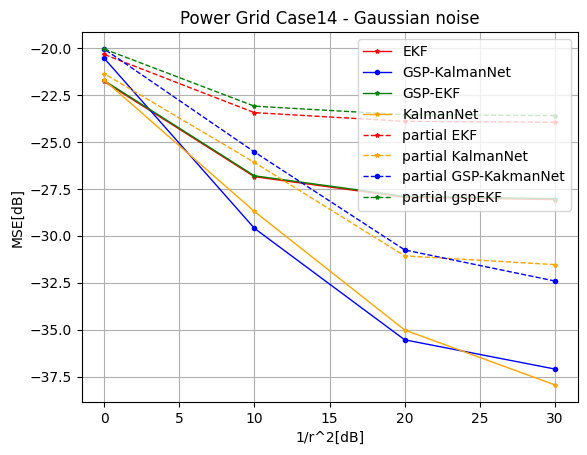

In [60]:
##########################Full ##########################
gspEKF_pyp       = torch.tensor([(-28.0228), (-27.8972), (-26.8039), (-21.7252)]).cpu()
EKF_pyp           = torch.tensor([(-28.0723), (-27.9465), (-26.8521), (-21.7763)]).cpu()
gsp_kalmanNet = torch.tensor([-37.1011, -35.5429, -29.6012, -20.537]).cpu() #, -11.7079]
KalmanNet = torch.tensor([(-37.9458),(-35.0206),(-28.7034),(-21.6987)]).cpu()

######################## partial #######################
gspEKFdiag_partial = torch.tensor([-23.5967,-23.5515,-23.0950,-20.0477]).cpu()
gspEKF_partial = torch.tensor([-23.9520,-23.9035,-23.4389,-20.3371]).cpu()
gsp_Knet_partial = torch.tensor([(-32.4118), (-30.7539), (-25.5338), (-20.0453)]).cpu()
KalmanNet_partial = torch.tensor([(-31.5370),(-31.0717),(-26.0936),(-21.3560)]).cpu()


r2 = torch.tensor([0.001,0.01,0.1,1])

plt.figure()
########### Full ############
line1, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), EKF_pyp, color='red',  linewidth=1,
                  marker='*', markerfacecolor='red', markersize=3, label="EKF")
line2, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gsp_kalmanNet, color='blue',  linewidth=1,
                  marker='o', markerfacecolor='blue', markersize=3, label="GSP-KalmanNet")
line3, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspEKF_pyp, color='green',  linewidth=1,
             marker='*', markerfacecolor='green', markersize=3, label="GSP-EKF")
line84, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), KalmanNet, color='orange',  linewidth=1,
             marker='*', markerfacecolor='green', markersize=3, label="KalmanNet")

########## Partial ##########
line4, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspEKF_partial, color='red', linestyle='dashed', linewidth=1,
                  marker='*', markerfacecolor='red', markersize=3, label="partial EKF")
line5, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), KalmanNet_partial, color='orange', linestyle='dashed', linewidth=1,
                  marker='*', markerfacecolor='red', markersize=3, label="partial KalmanNet")
line6, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gsp_Knet_partial, color='blue', linestyle='dashed', linewidth=1,
                  marker='o', markerfacecolor='blue', markersize=3, label="partial GSP-KakmanNet")
line7, = plt.plot(10*torch.log10(torch.tensor(1/r2.cpu())), gspEKFdiag_partial, color='green', linestyle='dashed', linewidth=1,
             marker='*', markerfacecolor='green', markersize=3, label="partial gspEKF")

leg = plt.legend(loc='upper right')
plt.xlabel('1/r^2[dB]')
plt.ylabel('MSE[dB]')
plt.grid()
plt.title('Power Grid Case14 - Gaussian noise')
plt.show()



# PyPower Data Generation

In [ ]:
# # # seed = 0
# # # torch.manual_seed(seed)
# x0 = torch.tensor([0.8, 0.3, 0.45, 0.25, 0.6, 0.1, 0.75, 0.22, 0.12, 0.95,0.1,0.7,0.3,0.5])
# l = torch.tensor([0.001, 0.01, 0.1, 1, 10])
# r2 = [0.001, 0.01, 0.1, 1, 10]
# r2 = l
# vdB = -20  # ratio v=q2/r2
# v = 10 ** (vdB / 10)
# q2 = torch.mul(v, r2)
# # q2 = [v*i for i in r2]
# nl_T = 200
# N_train = 1200
# N_valid = 100
# N_test = 100

# for index in range(len(r2)-3):
#     # print('r2 =', r2[index])
#     # ## Validation data create
#     # valid_X = torch.zeros(N_valid, pypower_n, nl_T)  # Tensor of m-by-T to contain the states thru time.
#     # valid_Y = torch.zeros(N_valid, pypower_m, nl_T)  # Tensor of n-by-T to contain the observations thru time.
#     # for n in range(N_valid):  # Train
#     #     valid_X[n, :, 0] = x0
#     #     valid_Y[n, :, 0] = pypower_h_EKF(x0)
#     #     for i in range(1, nl_T):  # create another T states in time
#     #         valid_X[n, :, i] = pypower_f_EKF(valid_X[n, :, i - 1]) + torch.randn(pypower_n) * q2[index] ** 0.5
#     #         valid_Y[n, :, i] = pypower_h_EKF(valid_X[n, :, i])
#     # valid_Y = valid_Y + torch.randn(valid_Y.shape) * r2[index] ** 0.5
#     # if True in torch.isnan(valid_X):
#     #   print('valid_X NANNNNN')
#     # else:
#     #   print('valid_X is good')
#     # if True in torch.isnan(valid_Y):
#     #   print('valid_Y NANNNNN')
#     # else:
#     #   print('valid_Y is good')
#     # torch.save(valid_X.type(torch.DoubleTensor), '/content/drive/MyDrive/Project/data/pypower14f/valid_target_r2_' + str(l[index]) + '.pt')
#     # torch.save(valid_Y.type(torch.DoubleTensor), '/content/drive/MyDrive/Project/data/pypower14f/valid_observation_r2_' + str(l[index]) + '.pt')
#     # print(valid_X[5,:,:])

#     ##### Train data create
#     train_X = torch.zeros(N_train, pypower_n, nl_T)  # Tensor of m-by-T to contain the states thru time.
#     train_Y = torch.zeros(N_train, pypower_m, nl_T)  # Tensor of n-by-T to contain the observations thru time.
#     for n in range(N_train):  # Train
#         if n % 100 == 0:
#           print("iter",n)
#         # torch.manual_seed(seed)
#         # torch.cuda.manual_seed(seed)
#         train_X[n, :, 0] = x0
#         train_X = train_X
#         train_Y[n, :, 0] = pypower_h_EKF(x0)
#         for i in range(1, nl_T):  # create another T states in time
#             train_X[n, :, i] = pypower_f_EKF(train_X[n, :, i - 1]) + torch.randn(pypower_n) * q2[index] ** 0.5
#             train_Y[n, :, i] = pypower_h_EKF(train_X[n, :, i])
#             # torch.manual_seed(seed * i)  # Insert any integer
#             # torch.cuda.manual_seed(seed * i)  # Insert any integer
#     train_Y = train_Y + torch.randn(train_Y.shape)*r2[index]**0.5

#     if True in torch.isnan(train_X):
#       print('train_X NANNNNN')
#     else:
#       print('train_X is good')
#     if True in torch.isnan(train_Y):
#       print('train_Y NANNNNN')
#     else:
#       print('train_Y is good')
#     torch.save(train_X.type(torch.DoubleTensor), '/content/drive/MyDrive/Project/data/pypower14f/train_target_r2_' + str(l[index]) + '.pt')
#     torch.save(train_Y.type(torch.DoubleTensor), '/content/drive/MyDrive/Project/data/pypower14f/train_observation_r2_' + str(l[index]) + '.pt')

#     ######### Test data create
#     # loc = 0
#     # # rand_r = torch.distributions.laplace.Laplace(0, r2[index])
#     # # rand_q = torch.distributions.laplace.Laplace(0, q2[index])
#     # test_X = torch.zeros(N_test, pypower_n, nl_T)  # Tensor of m-by-T to contain the states thru time.
#     # test_Y = torch.zeros(N_test, pypower_m, nl_T)  # Tensor of n-by-T to contain the observations thru time.
#     # for n in range(N_test):
#     #     test_X[n, :, 0] = x0
#     #     test_Y[n, :, 0] = pypower_h_EKF(x0)
#     #     for i in range(1, nl_T):  # create another T states in time
#     #         # test_X[n, :, i] = pypower_f_EKF(test_X[n, :, i - 1]) + torch.from_numpy(np.random.laplace(loc, q2[index], pypower_n)).cuda()  #torch.randn(pypower_n) * q2[index] ** 0.5
#     #         test_X[n, :, i] = pypower_f_EKF(test_X[n, :, i - 1]) + torch.randn(pypower_n) * q2[index] ** 0.5
#     #         test_Y[n, :, i] = pypower_h_EKF(test_X[n, :, i])
#     # # test_Y[:,:,:] = test_Y[:,:,:] + torch.tensor(np.random.laplace(loc, r2[index], N_test*pypower_n*nl_T)).reshape((N_test, pypower_n, nl_T)) * r2[index] #torch.randn(test_Y[:,:,:].shape) * r2[index] ** 0.5
#     # test_Y[:,:,:] = test_Y[:,:,:] + torch.randn(test_Y[:,:,:].shape) * r2[index] ** 0.5
#     # torch.save(test_X.type(torch.DoubleTensor), '/content/drive/MyDrive/Project/data/pypower14f/test_target_r2_' + str(l[index]) + '.pt')
#     # torch.save(test_Y.type(torch.DoubleTensor), '/content/drive/MyDrive/Project/data/pypower14f/test_observation_r2_' + str(l[index]) + '.pt')
#     # if True in torch.isnan(test_X):
#     #   print('NANNNNN')
#     # else:
#     #   print('target is good')
#     # if True in torch.isnan(test_Y):
#     #   print('NANNNNN')
#     # else:
#     #   print('target is good')